# Basic setup

## Setup check-up

In [8]:
try:
    import langchain
    print("Langchain est installé, version:", langchain.__version__)
except ImportError:
    print("Langchain n'est pas installé.")

Langchain est installé, version: 0.3.20


In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=$CONDA_PREFIX"
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # or "true"

try:
    from transformers import pipeline
    print(pipeline('sentiment-analysis')('we love you'))
    print("Hugging Face Transformers est installé.")
except ImportError:
    print("Hugging Face Transformers n'est pas installé.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9998704195022583}]
Hugging Face Transformers est installé.


In [10]:
try:
    import tensorflow as tf
    print(tf.sysconfig.get_build_info())
    print(tf.config.list_physical_devices('GPU'))
    print("TensorFlow est installé, version:", tf.__version__)
except ImportError:
    print("TensorFlow n'est pas installé.")
    

OrderedDict({'is_cuda_build': False, 'is_rocm_build': False, 'is_tensorrt_build': False})
[]
TensorFlow est installé, version: 2.17.0


In [11]:
import torch

print(torch.version.cuda)
print(torch.cuda.is_available())

11.8
True


## Setup the LLM manager

### Purge the system

In [ ]:
# !yes | docker system prune -a

### Install the Ollama Server

In [ ]:
!docker create --gpus=all -v ollama:/root/.ollama -p 11434:11434 --name llm_server ollama/ollama

In [ ]:
!docker ps

### Update the Ollama server

In [ ]:
!docker pull ollama/ollama

In [ ]:
!docker exec -it llm_server ollama --version

### Run or stop the LLM server

In [ ]:
!docker stop llm_server

In [ ]:
!docker start llm_server

### Pull the modules (llms)

In [ ]:
!docker exec -it llm_server ollama pull llama3.2

In [ ]:
!docker exec -it llm_server ollama pull nomic-embed-text

In [ ]:
!docker exec -it llm_server ollama pull mistral

In [ ]:
!docker exec -it llm_server ollama pull nemotron-mini

In [ ]:
!docker exec -it llm_server ollama pull granite3.2-vision

#### List the pulled model

In [ ]:
!docker exec -it llm_server ollama list

#### Remove a pulled model

In [ ]:
# !docker exec -it llm_server ollama rm llava-phi3

#### Test the pulled model

In [ ]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="llama3.2", temperature=0.03)

In [ ]:
llm.invoke("The first publicly large scale available chat AI was ...")

## Setup the environment

In [3]:
from dotenv import dotenv_values
import os

# Load OPENAI_API_KEY
env_vars = dotenv_values("config.env")
api_key = env_vars.get("OPENAI_API_KEY")
if api_key:
    os.environ["OPENAI_API_KEY"] = api_key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [38]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="llama3.2", temperature=0.03, max_retries=10)

# Exemples Langchain

## Un simple chaîne

In [5]:
# Importing necessary modules from the LangChain core library
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage  # To manage message types (human/system)
from langchain_core.output_parsers import StrOutputParser  # To parse the output from the model
from langchain_core.prompts import ChatPromptTemplate  # To create prompt templates for the LLM

# Defining a system message template with a prompt that explains a specific topic
system_template = "Explain to the user the story of the {topic} he asked for."

# Creating a ChatPromptTemplate object using system and user messages
# The system message uses the 'system_template', while the user message contains the user's input as 'text'
sc_prompt_template = ChatPromptTemplate.from_messages(
    [system_template, "{text}"]
)

# Creating a string output parser to handle the output as plain text
sc_parser = StrOutputParser()

# Defining a chain that connects the prompt template, the LLM, and the output parser
# This chain processes the prompt, generates the response, and parses it
simplechain = sc_prompt_template | llm | sc_parser

In [6]:
display(simplechain.invoke({"topic": "Natural Language Processing", "text": "Tell me more about IBM Watson"}))

"I'd be happy to explain the concept of Natural Language Processing (NLP) and its applications, including IBM Watson.\n\n**What is Natural Language Processing (NLP)?**\n\nNatural Language Processing (NLP) is a subfield of artificial intelligence (AI) that deals with the interaction between computers and humans in natural language. It involves the use of algorithms and statistical models to process, understand, and generate human language.\n\nThe goal of NLP is to enable computers to perform tasks that typically require human intelligence, such as:\n\n1. Text analysis: extracting insights from unstructured text data\n2. Sentiment analysis: determining the emotional tone or sentiment behind a piece of text\n3. Language translation: translating text from one language to another\n4. Speech recognition: recognizing spoken words and converting them into text\n\n**How does NLP work?**\n\nNLP involves several steps:\n\n1. **Text preprocessing**: cleaning and normalizing the input text data\n2.

## Structured Output Parser

In [7]:
from pydantic import BaseModel, Field

# Définition d'un modèle Pydantic pour la sortie
class ResponseFormatter(BaseModel):
    answer: str = Field(description="La réponse à la question de l'utilisateur.")
    followup_question: str = Field(description="Une question de suivi que l'utilisateur pourrait poser.")

# Lier le modèle à l'output structuré
structured_model = llm.with_structured_output(ResponseFormatter, include_raw=True)

# Exemple d'invocation
response = structured_model.invoke("Quel est le capital de l'Allemagne ?")

# Afficher la sortie structurée
print(response)

{'raw': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-10T15:04:28.32805884Z', 'done': True, 'done_reason': 'stop', 'total_duration': 537347980, 'load_duration': 25519931, 'prompt_eval_count': 193, 'prompt_eval_duration': 11000000, 'eval_count': 35, 'eval_duration': 500000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-87cae4a6-88b7-4f0c-a793-ea4fa243cadf-0', tool_calls=[{'name': 'ResponseFormatter', 'args': {'answer': 'Berlin', 'followup_question': 'Quelle est la langue officielle de Berlin?'}, 'id': '12796d73-c248-4aeb-8379-6e76cb442f1d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 193, 'output_tokens': 35, 'total_tokens': 228}), 'parsed': ResponseFormatter(answer='Berlin', followup_question='Quelle est la langue officielle de Berlin?'), 'parsing_error': None}


In [8]:
print(response['parsed'].followup_question)

Quelle est la langue officielle de Berlin?


In [9]:
from langchain.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=ResponseFormatter)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"answer": {"description": "La réponse à la question de l'utilisateur.", "title": "Answer", "type": "string"}, "followup_question": {"description": "Une question de suivi que l'utilisateur pourrait poser.", "title": "Followup Question", "type": "string"}}, "required": ["answer", "followup_question"]}
```


## Le Templates

In [10]:
from langchain_core.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template("Donne-moi une blague sur {sujet}.")
response = prompt_template.invoke({"sujet": "les chats"})
response

StringPromptValue(text='Donne-moi une blague sur les chats.')

In [11]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_messages([
    ("system", "Tu es un assistant utile."),
    ("user", "Raconte-moi une blague sur les chats.")
])
response = prompt_template.invoke({})
response

ChatPromptValue(messages=[SystemMessage(content='Tu es un assistant utile.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Raconte-moi une blague sur les chats.', additional_kwargs={}, response_metadata={})])

## Les Embeddings

In [12]:
# Installer la version mise à jour si nécessaire

from langchain_ollama import OllamaEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# Initialisation du modèle d'embeddings avec la version mise à jour
embeddings = OllamaEmbeddings(model="nomic-embed-text")

# Exemple de texte pour le vector store
text = "LangChain est le framework pour construire des applications de raisonnement contextuelles."
vector = embeddings.embed_query(text)

# Affichage des dimensions (pour démonstration)
print(len(vector))           # Affiche la taille totale du vecteur
print(vector[10:20])         # Affiche 10 dimensions sur 768 pour un aperçu

768
[0.0010725434, 0.0030604883, 0.060706183, 0.0071099284, 0.0038056541, -0.0041046985, -0.008076469, -0.0066963593, -0.030127706, 0.043762457]


## Les Vector Stores

In [13]:
# Create an in-memory vector store and populate it with embeddings of the sample text
vectorstore = InMemoryVectorStore.from_texts(
    [
        "It's cool to be a BBS student",
        "I wish I could have chicken wings right now",
        "Sorry, wasn't listening"
    ],
    embedding=embeddings
)

In [14]:
for doc in vectorstore.similarity_search(query="fried chicken",k=1):
    print(f"* {doc.page_content} [{doc.metadata}]")

* I wish I could have chicken wings right now [{}]


In [15]:
for doc, score in vectorstore.similarity_search_with_score(query="fried chicken",k=2):
    print(f"* [SIM={(score*100):3f}%] {doc.page_content} [{doc.metadata}]")

* [SIM=56.295007%] I wish I could have chicken wings right now [{}]
* [SIM=34.996360%] Sorry, wasn't listening [{}]


## Les retrievers

In [16]:
from langchain_community.retrievers import WikipediaRetriever

wikiretriever = WikipediaRetriever()
documents = wikiretriever.invoke("intelligence artificielle")
documents

[Document(metadata={'title': 'Les Prophéties', 'summary': 'Les Prophéties (The Prophecies) is a collection of prophecies by French physician Nostradamus, the first edition of which appeared in 1555 by the publishing house Macé Bonhomme. His most famous work is a collection of poems, quatrains, united in ten sets of verses ("Centuries") of 100 quatrains each.\nThe first edition included three whole Centuries and 53 quatrains. The book begins with a preface, in the form of a message to his son César, followed by the Centuries themselves. The second edition was published in the same year and has minor differences from the first.\nThe third edition was published in 1557, and included the full text of the previous edition, supplemented by three more Centuries. The fourth edition was published two years after the death of the author, in 1568. It is the first edition to include all ten Centuries, as well as a second preface, the Letter to King Henry II. However, quatrains 55 to 100 of the sev

### Vector Store Retrievers

In [17]:
# Use the vector store as a retriever (Can be “similarity” (default), “mmr”, or “similarity_score_threshold”)
mmrretriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 1, "fetch_k": 2, "lambda_mult": 0.5},
)

# Query the retriever with a relevant question
retrieved_documents = mmrretriever.invoke("Fried chicken?")

# Show the retrieved document's content
retrieved_documents

[Document(id='9aacd4c4-631f-44c7-b7e8-53a9409ea2e7', metadata={}, page_content='I wish I could have chicken wings right now')]

In [18]:
# Create an in-memory vector store and populate it with embeddings of the sample text
wikivectorstore = InMemoryVectorStore.from_documents(
    documents,
    embedding=embeddings
)

# Use the vector store as a retriever (all defaults to cosine similarity)
wikiretriever = wikivectorstore.as_retriever()

# Query the retriever with a relevant question
retrieved_documents = wikiretriever.invoke("Any knowledge about teh Dartmouth conference?")

# Show the retrieved document's content
retrieved_documents

[Document(id='8d089f80-726d-4bbc-872e-99ff02de4e1b', metadata={'title': 'Yann LeCun', 'summary': 'Yann André Le Cun ( lə-KUN, French: [ləkœ̃]; usually spelled LeCun; born 8 July 1960) is a French-American computer scientist working primarily in the fields of machine learning, computer vision, mobile robotics and computational neuroscience. He is the Silver Professor of the Courant Institute of Mathematical Sciences at New York University and Vice President, Chief AI Scientist at Meta.\nHe is well known for his work on optical character recognition and computer vision using convolutional neural networks (CNNs). He is also one of the main creators of the DjVu image compression technology (together with Léon Bottou and Patrick Haffner). He co-developed the Lush programming language with Léon Bottou.\nIn 2018, LeCun, Yoshua Bengio, and Geoffrey Hinton, received the Turing Award for their work on deep learning. The three are sometimes referred to as the "Godfathers of AI" and "Godfathers of

## Tools

In [19]:
query = "What is 3 * 12? Also, what is 11 + 49? and please, what is the greatest singer of all time in current google trend ?"

In [20]:
# Tools déclarés 
from langchain_core.output_parsers import PydanticToolsParser
from pydantic import BaseModel, Field

class add(BaseModel):
    """Add two integers."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")

class multiply(BaseModel):
    """Multiply two integers."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")

class websearch(BaseModel):
    """search online a query."""

    a: str = Field(..., description="The Query to search online")

available_tools = [add, multiply, websearch]
llm_with_tools = llm.bind_tools(available_tools)
response = llm_with_tools.invoke(query)

In [21]:
# Print the tool calls to show how they are invoked
for call in response.tool_calls:
    print(f"Tool: {call['name']}")
    print(f"Arguments: {call['args']}")

Tool: multiply
Arguments: {'a': 3, 'b': 12}
Tool: add
Arguments: {'a': 11, 'b': 49}
Tool: websearch
Arguments: {'a': 'greatest singer of all time'}


### Tool output parser

In [22]:
chain = llm_with_tools | PydanticToolsParser(tools=available_tools)

response = chain.invoke(query)
response

[multiply(a=3, b=12),
 add(a=11, b=49),
 websearch(a='greatest singer of all time')]

## Tracing

In [23]:
from typing import Any, Dict, List, Optional, Sequence
from uuid import UUID

# from langchain_ollama import OllamaLLM
# from langchain_core.callbacks.base import BaseCallbackHandler
# from langchain_core.agents import AgentAction, AgentFinish
# from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.schema import GenerationChunk, ChatGenerationChunk, RetryCallState
# from langchain_core.retrievers import Document

from langchain_ollama import OllamaLLM
from langchain_core.callbacks.base import BaseCallbackHandler
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages.base import BaseMessage
from langchain_core.outputs.llm_result import LLMResult
from langchain_core.outputs.chat_generation import ChatGenerationChunk
from langchain_core.outputs.generation import GenerationChunk
from langchain_core.documents.base import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langchain_ollama import OllamaLLM

In [24]:
class LoggingHandler(BaseCallbackHandler):
    ##### GENERAL CASE INSPECTIONS
    # def on_retry(
    #     self,
    #     retry_state: RetryCallState,
    #     *,
    #     run_id: UUID,
    #     parent_run_id: Optional[UUID] = None,
    #     **kwargs: Any
    # ) -> Any:
    #     print(f"[Run ID: {run_id}] Retry occurred. Retry state: {retry_state}")

    def on_text(
        self,
        text: str,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Text event: {text}")

    ##### AGENTS INSPECTIONS 
    def on_agent_action(
        self,
        action: AgentAction,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Agent Action: {action}")

    def on_agent_finish(
        self,
        finish: AgentFinish,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Agent Finished: {finish}")

    ##### CHAINS INSPECTIONS
    def on_chain_end(
        self,
        outputs: Dict[str, Any],
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Chain Ended with outputs: {outputs}")

    def on_chain_error(
        self,
        error: BaseException,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Chain Error: {error}")

    def on_chain_start(
        self,
        serialized: Optional[Dict[str, Any]],  # Allow serialized to be Optional
        inputs: Dict[str, Any],
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        **kwargs: Any
    ) -> Any:
        if serialized is None:
            chain_name = "Unnamed Chain"
            print(f"[Run ID: {run_id}] WARNING: Received None for 'serialized' in on_chain_start.")
        else:
            chain_name = serialized.get("name", "Unnamed Chain")

        print(f"[Run ID: {run_id}] INFO: Chain '{chain_name}' started with inputs: {inputs}")


    ##### CHAT MODEL INSPECTIONS
    def on_chat_model_start(
        self,
        serialized: Dict[str, Any],
        messages: List[List[BaseMessage]],
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        **kwargs: Any
    ) -> Any:
        model_name = serialized.get("model", "Unnamed Model")
        print(f"[Run ID: {run_id}] Chat Model '{model_name}' started with messages: {messages}")

    ##### CUSTOM EVENTS INSPECTIONS
    def on_custom_event(
        self,
        name: str,
        data: Any,
        *,
        run_id: UUID,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Custom Event '{name}' triggered with data: {data}")

    ##### LLM INSPECTIONS
    def on_llm_end(
        self,
        response: Any,  # Adjusted to Any since OllamaLLM might return different types
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] LLM Ended with response: {response}")

    def on_llm_error(
        self,
        error: BaseException,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] LLM Error: {error}")

    def on_llm_new_token(
        self,
        token: str,
        *,
        chunk: Optional[GenerationChunk] = None,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] New LLM Token: {token}")

    def on_llm_start(
        self,
        serialized: Dict[str, Any],
        prompts: List[str],
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        **kwargs: Any
    ) -> Any:
        llm_name = serialized.get("model", "Unnamed LLM")
        print(f"[Run ID: {run_id}] LLM '{llm_name}' started with prompts: {prompts}")

    ##### RETRIEVERS INSPECTIONS
    def on_retriever_end(
        self,
        documents: Sequence[Document],
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Retriever Ended with documents: {documents}")

    def on_retriever_error(
        self,
        error: BaseException,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Retriever Error: {error}")

    def on_retriever_start(
        self,
        serialized: Dict[str, Any],
        query: str,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        **kwargs: Any
    ) -> Any:
        retriever_name = serialized.get("name", "Unnamed Retriever")
        print(f"[Run ID: {run_id}] Retriever '{retriever_name}' started with query: '{query}'")

    ##### TOOLS INSPECTIONS
    def on_tool_end(
        self,
        output: Any,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Tool Ended with output: {output}")

    def on_tool_error(
        self,
        error: BaseException,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any
    ) -> Any:
        print(f"[Run ID: {run_id}] Tool Error: {error}")

    def on_tool_start(
        self,
        serialized: Dict[str, Any],
        input_str: str,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        tags: Optional[List[str]] = None,
        metadata: Optional[Dict[str, Any]] = None,
        inputs: Optional[Dict[str, Any]] = None,
        **kwargs: Any
    ) -> Any:
        tool_name = serialized.get("name", "Unnamed Tool")
        print(f"[Run ID: {run_id}] Tool '{tool_name}' started with input: '{input_str}'")

In [25]:
# Initialize the callback handler
callbacks = [LoggingHandler()]

# Invoke the chain with input and callback configuration
simplechain.invoke(
    {"topic": "Natural Language Processing", "text": "Tell me more about IBM Watson"},
    config={"callbacks": callbacks}
)

[Run ID: 7fa45dd5-7d96-4efa-a128-f590c3f82f5b] WARNING: Received None for 'serialized' in on_chain_start.
[Run ID: 7fa45dd5-7d96-4efa-a128-f590c3f82f5b] INFO: Chain 'Unnamed Chain' started with inputs: {'topic': 'Natural Language Processing', 'text': 'Tell me more about IBM Watson'}
[Run ID: 9e19ac5c-3673-45b0-a9dd-1cfbdb91459e] INFO: Chain 'ChatPromptTemplate' started with inputs: {'topic': 'Natural Language Processing', 'text': 'Tell me more about IBM Watson'}
[Run ID: 9e19ac5c-3673-45b0-a9dd-1cfbdb91459e] Chain Ended with outputs: messages=[HumanMessage(content='Explain to the user the story of the Natural Language Processing he asked for.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Tell me more about IBM Watson', additional_kwargs={}, response_metadata={})]
[Run ID: 7900025b-ef93-4abb-a725-e6f326099b97] Chat Model 'Unnamed Model' started with messages: [[HumanMessage(content='Explain to the user the story of the Natural Language Processing he asked for.', a

'I\'d be happy to explain the concept of Natural Language Processing (NLP) and its applications, including IBM Watson.\n\n**What is Natural Language Processing (NLP)?**\n\nNatural Language Processing (NLP) is a subfield of artificial intelligence (AI) that deals with the interaction between computers and humans in natural language. It\'s a way for machines to understand, interpret, and generate human language, enabling them to perform tasks such as text analysis, sentiment analysis, machine translation, and more.\n\n**How does NLP work?**\n\nNLP involves several steps:\n\n1. **Text Preprocessing**: The input text is cleaned, tokenized (broken down into individual words or tokens), and normalized (standardized) to prepare it for processing.\n2. **Part-of-Speech Tagging**: The system identifies the part of speech (noun, verb, adjective, etc.) for each word in the text.\n3. **Named Entity Recognition**: The system identifies named entities such as people, places, organizations, and dates.

# Exemples Langraph

In [1]:
import os

from langchain_ollama import ChatOllama
from langchain.prompts import ChatPromptTemplate
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.output_parsers import PydanticOutputParser

from pydantic import BaseModel, Field


In [2]:
# Importing the ChatOllama class from the langchain_ollama module
from langchain_ollama import ChatOllama

# Initializing a language model (LLM) using the ChatOllama class
# temperature is set to 0, meaning deterministic responses with no randomness
llm = ChatOllama(model="llama3.2", temperature=0.03, max_retry=10)

## Une simple One-Shot Chat

In [3]:
# Importing Annotated from typing to allow advanced type annotations
from typing import Annotated
# Importing TypedDict from typing_extensions to define a dictionary with fixed keys and value types
from typing_extensions import TypedDict

# Importing AnyMessage from langchain_core.messages to define a general message type
from langchain_core.messages import AnyMessage

# Importing necessary components from langgraph to build a state graph
from langgraph.graph import StateGraph, START, END  # START and END mark the flow of states in the graph
from langgraph.graph.message import add_messages  # add_messages defines how messages should be added to the state

# Defining the State class as a TypedDict
# This class represents the structure of the state, with one key: "messages"
class State(TypedDict):
    # The "messages" key stores a list of AnyMessage instances
    # The Annotated type allows the `add_messages` function to handle how messages are updated
    # In this case, `add_messages` appends new messages to the existing list
    messages: Annotated[list[AnyMessage], add_messages]

# Creating an instance of StateGraph using the defined State structure
# This graph will manage the state transitions, where each state holds the messages
graph_builder = StateGraph(State)


In [4]:
# Defining the chatbot function which takes the current state as input
# The state is expected to be of type "State", containing a list of messages
def chatbot(state: State):
    # The function returns a dictionary with the key "messages"
    # It invokes the language model (llm) on the list of messages in the current state
    # The llm.invoke() method generates a response based on the input messages
    return {"messages": [llm.invoke(state["messages"])]}

# Adding an edge to the graph from the START node to the "chatbot" node
# This signifies that the process starts at the START node and moves to the "chatbot" node
graph_builder.add_edge(START, "chatbot")

# Adding the "chatbot" node to the graph, which points to the chatbot function
# Whenever this node is used, the chatbot function will be called
graph_builder.add_node("chatbot", chatbot)

# Adding an edge from the "chatbot" node to the END node
# This means that once the "chatbot" function is executed, the process moves to the END node, signaling completion
graph_builder.add_edge("chatbot", END)

# Compiling the graph to make it ready for execution
# This graph consists of nodes and edges, representing the flow of state transitions and function calls
from langgraph.graph.state import CompiledStateGraph
graph = graph_builder.compile()


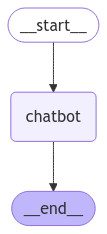

In [5]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Importing AIMessage and HumanMessage to represent different types of messages
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Defining a function to send user input to the chatbot and process responses
def send_msg(user_input: str):
    # Creating a dictionary with a "messages" key containing a list of HumanMessage objects
    # The content of the HumanMessage is set to the user's input
    messages = {"messages": [HumanMessage(content=user_input)]}
    
    # Streaming events from the graph by providing the user messages as input
    for event in graph.stream(input=messages):
        # Looping through the event's values (responses generated by the assistant)
        for value in event.values():
            # Printing the last message in the list of responses from the assistant
            print("Assistant:", value["messages"][-1].content)

# A continuous loop to interact with the chatbot
def invoke_chat():
    print('quit by typing "quit", "exit", or "q"')
    while True:
        try:
            # Asking for user input via the console
            user_input = input("User: ")
            # Checking if the user wants to quit by typing "quit", "exit", or "q"
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break  # Exiting the loop if the user wants to quit
    
            # Sending the user input to the send_msg function to get a response from the chatbot
            send_msg(user_input)
    
        except:
            # Fallback behavior if input() is not available (e.g., in some environments or for testing)
            # In this case, the user input is hardcoded to a specific question
            user_input = "What do you know about LangGraph?"
            print("User: " + user_input)
            # Sending the hardcoded input to the chatbot
            send_msg(user_input)
            break  # Ending the loop after this fallback interaction

In [7]:
invoke_chat()

quit by typing "quit", "exit", or "q"


User:  hello


Assistant: Hello! How can I assist you today?


User:  quit


Goodbye!


## Intent analyzer graph

In [15]:
# Importing the ChatOllama class from the langchain_ollama module
from langchain_ollama import ChatOllama

# Initializing a language model (LLM) using the ChatOllama class
# temperature is set to 0, meaning deterministic responses with no randomness
llm = ChatOllama(model="llama3.2", temperature=0.03, max_retry=10)

In [16]:
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import TypedDict, List, Dict

# Predefined intent options
INTENT_OPTIONS = ["login", "query", "translate", "summarize", "verify", "analyze", "extract", "calculate"]

# Pydantic Model for enforcing structured output with detailed descriptions
class IntentOutput(BaseModel):
    intents: List[str] = Field(
        description="An ordered list of user intents chosen from predefined options: "
                    "query, translate, summarize, verify, extract, calculate."
    )
    what: Dict[str, str] = Field(
        description=(
            "Additional details describing what specifically each intent applies to:\n"
            "- login: 'Which credentials to fetch, e.g., api credentials for Twitter'.\n"
            "- query: 'What to query, e.g., population data for France in 2023'.\n"
            "- translate: 'Source and target languages, e.g., from English to French'.\n"
            "- summarize: 'Main subject to summarize, e.g., climate change report'.\n"
            "- verify: 'Facts to check, e.g., GDP accuracy in report'.\n"
            "- extract: 'Entities to extract, e.g., company names or dates'.\n"
            "- calculate: 'Variables and operations, e.g., square root of age of author'."
        )
    )

# Prompt template for classification
INTENT_PROMPT = PromptTemplate(
    input_variables=["message", "options"],
    template=(
        "Analyze the user's message: {message}\n"
        "Classify its intent using these predefined options: {options}.\n"
        "Output a JSON object containing:\n"
        "  1. 'intents': an ordered list of intents.\n"
        "  2. 'what': a dictionary where each intent has specific details.\n"
        "Follow this schema strictly:\n"
        "{{'intents': ['option1', 'option2'], 'what': {{'option1': 'details1', 'option2': 'details2'}}}}"
    ),
)

# Define the graph's state schema
class IntentState(TypedDict):
    message: str
    intents: List[str]  # Ordered list of classified intents
    what: Dict[str, str]  # Details for each intent

# Build the LangGraph
def build_graph():
    # Create the state graph
    graph = StateGraph(IntentState)

    # Node for intent classification
    def classify_intent(state: IntentState):
        # Bind structured output using Pydantic
        structured_model = llm.with_structured_output(IntentOutput, method="function_calling")

        # Prepare the prompt for classification
        prompt = INTENT_PROMPT.format(
            message=state["message"],
            options=", ".join(INTENT_OPTIONS)
        )

        # Invoke the model and enforce structured output
        response = structured_model.invoke(prompt)

        # Return the results
        return {"intents": response.intents, "what": response.what}

    # Add nodes and edges to the graph
    graph.add_node("classify", classify_intent)
    graph.add_edge(START, "classify")
    graph.add_edge("classify", END)

    return graph.compile()

# Build and execute the graph
compiled_graph = build_graph()

In [17]:
# Example usage with retry loop
def invoke_with_retry(message):
    try:
        result = compiled_graph.invoke({"message": message})
        print(f"Identified intents: {result['intents']}")
        print(f"Details (what): {result['what']}")
        return result
    except ValidationError as e:
        invoke_with_retry(message)
            
# Example Input
message = "concerning the story of life of the author of Harry potter, translate this document from English to French and summarize it."
result = invoke_with_retry(message)

Identified intents: ['translate', 'summarize']
Details (what): {'summarize': 'story of life of the author of Harry potter', 'translate': 'English to French'}


## Intent analyzer agent

In [18]:
from dotenv import dotenv_values
import os

# Load OPENAI_API_KEY
env_vars = dotenv_values("config.env")
api_key = env_vars.get("OPENAI_API_KEY")
if api_key:
    os.environ["OPENAI_API_KEY"] = api_key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [45]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.03,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_API_KEY,
    # base_url="...",
    # organization="...",
    # other params...
)

In [46]:
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict, List, Dict

In [47]:
class IntentStepState(TypedDict):
    order: int  # The execution order for this intent
    intent: str  # The type of intent (e.g., 'action', 'query', 'extract', etc.)
    what: str  # A detailed description of the task
    sources: List[int]  # List of dependencies, referencing previous steps by order number
    inputs: List[str] # Required inputs to execute this step
    outputs: List[str] # Expected outputs generated by this step
    # method: str  # Algorithm, tool, or technique to be used for execution


class IntentState(TypedDict):
    message: str  # Original user query
    intents: List[IntentStepState]  # Ordered list of structured intents
    feedback: str  # Feedback from the critic

In [48]:
class IntentOutputStep(BaseModel):
    order: int = Field(
        ...,
        description=(
            "The execution order of the intent. Must follow sequential numbering."
            "Steps are executed in increasing order, enforcing dependencies."
        )
    )
    intent: str = Field(
        ...,
        description=(
            "The type of intent."
            " Allowed values:"

            "**Login:**"
            "- Read either asking from a humain or by internal database some credentials."
            "- **What:** Which credentials to retrieve to login into a system."
            "- **Example:** 'Retrieve the Twitter API login credentials.'"
            
            "**Action:**"
            "- Prepare environment or tools (e.g., 'Open Twitter')."
            "- **What:** Specify the tool, API, or app to prepare."
            "- **Example:** 'Open Twitter API and authenticate.'"

            "**Query:**"
            "- Retrieve information using predefined tools."
            "- **What:** Specify the data source, target data, and query."
            "- **Example:** 'Fetch the latest tweet from Donald Trump using Twitter API.'"

            "**Extract:**"
            "- Extract structured information from retrieved data."
            "- **What:** Define the data to extract and the format."
            "- **Example:** 'Extract sentiment and keywords from tweet text.'"

            "**Summarize:**"
            "- Condense extracted or queried data into simplified insights."
            "- **What:** Define the summary goal and required format."
            "- **Example:** 'Summarize key points and sentiment trends from the tweet.'"

            "**Translate:**"
            "- Translate extracted or summarized data into another language."
            "- **What:** Specify source, target language, and text."
            "- **Example:** 'Translate extracted sentiment from English to French.'"

            "**Analyze:**"
            "- Process extracted or queried data for insights or patterns."
            "- **What:** Define the method of analysis and expected output."
            "- **Example:** 'Perform NLP sentiment analysis using extracted keywords.'"

            "**Verify:**"
            "- Validate extracted or analyzed data against references."
            "- **What:** Specify the criteria for verification."
            "- **Example:** 'Verify sentiment consistency against stock market trends.'"

            "**Calculate:**"
            "- Perform calculations using pre-defined formulas and variables."
            "- **What:** Define the formula, variables, and output."
            "- **Example:** 'Calculate sentiment score as (positive_weight - negative_weight) / total.'"

            "**Rules:**"
            "- 'extract' MUST depend on 'action' or 'query'."
            "- 'analyze', 'translate', 'verify', 'calculate' MUST depend on prior 'extract' or 'query'."
        )
    )
    what: str = Field(
        ...,
        description=(
            "A detailed description of the task, specifying methods, tools, inputs, outputs, and expected results."
            "- Must clearly state **what** to do, **how** to do it, and expected **outputs**."
            "- Example: 'Extract sentiment and keywords from the tweet text retrieved earlier.'"
        )
    )
    sources: List[int] = Field(
        ...,
        description=(
            "The order number(s) of prior intents this step depends on."
            "- Example: 'extract' (step 3) depends on 'query' (step 2), so sources=[2]."
            "- Supports multiple sources for complex tasks (e.g., 'calculate')."
        )
    )
    inputs: List[str] = Field(
        default=[],
        description=(
            "Explicit input data required to execute this step."
            "- Example for 'calculate': 'sentiment_score', 'tweet_length'."
            "- Example for 'analyze': 'sentiment analysis of inputs'."
        )
    )
    outputs: List[str] = Field(
        default=[],
        description=(
            "Expected outputs generated by this step."
            "- Example for 'extract': 'sentiment', 'keywords'."
            "- Example for 'analyze': 'sentiment_score'."
        )
    )
    # method: str = Field(
    #     ...,
    #     description=(
    #         "The specific method, algorithm, or tool used for execution."
    #         "- Example for 'analyze': 'Sentiment analysis using NLP transformer model.'"
    #         "- Example for 'calculate': 'Sentiment score = sum(positive_weight - negative_weight)'."
    #     )
    # )


class IntentOutput(BaseModel):
    intents: List[IntentOutputStep] = Field(
        ...,
        description=(
            "A structured list of ordered intents with dependencies, inputs, outputs, and methods."
        )
    )

In [49]:
# Use the output parser directly
parser = PydanticOutputParser(pydantic_object=IntentOutput)

# Generate the raw instructions appended to the LLM
schema_instructions = parser.get_format_instructions()

print("=== Schema Instructions Sent to LLM ===")
print(schema_instructions)

=== Schema Instructions Sent to LLM ===
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"IntentOutputStep": {"properties": {"order": {"description": "The execution order of the intent. Must follow sequential numbering.Steps are executed in increasing order, enforcing dependencies.", "title": "Order", "type": "integer"}, "intent": {"description": "The type of intent. Allowed values:**Login:**- Read either asking from a humain or by internal database some credentials.- **What:** Which credentials to retrieve to login into a system.- **Example:** 'Retrieve the Twitter API login cred

In [50]:
INTENT_PROMPT = PromptTemplate(
    input_variables=["message", "feedback"],
    template=(
        "### User Query:\n"
        "```{message}```\n"

        "### Feedback and Iteration:\n"
        "- Take into account the following **feedback** from the last review:\n"
        "```{feedback}```\n"

        "### Task:\n"
        "Analyze the user's query and classify its intent into steps using the following predefined categories:\n"
        "Break down the query into steps based on these intents:\n"
        "**Allowed Intents:** 'action', 'query', 'extract', 'summarize', 'translate', 'analyze', 'verify', 'calculate'\n"
        
        "### Rules for Output:\n"
        "1. **Order and Dependencies:**\n"
        "- Each intent must have a **sequential order number**.\n"
        "- Higher-order intents ('translate', 'analyze', 'verify', 'calculate') **must depend on prior intents** ('action', 'query', 'extract').\n"
        "- No skipped steps or unordered dependencies.\n"
        "- Provide output as a **JSON object matching the schema**.\n"
        "- Do **not** skip required fields.\n"
        "- Field names are **fixed**—errors will cause rejection.\n"
        "- Respond only with **raw JSON** matching the schema—no extra text, quotes, or formatting.\n"

        "2. **Detailed Instructions for Each Intent:**\n"
        "- 'login': Specify the **exact credentials** to be fetched** (e.g., 'Fetch the Twitter API credentials.').\n"
        "- 'action': Specify the **exact tool** and **environment setup** (e.g., 'Open Twitter and authenticate API.').\n"
        "- 'query': Define the **source**, **data target**, and **retrieval method** (e.g., 'Fetch the latest tweet from Twitter API.').\n"
        "- 'extract': Specify **what data** to extract, **where from**, and **format** (e.g., 'Extract sentiment from tweet text.').\n"
        "- 'summarize': Define **what to summarize** and expected **level of detail**.\n"
        "- 'translate': Specify **source text**, **target language**, and **method**.\n"
        "- 'analyze': Define **type of analysis**, **inputs**, and **outputs** (e.g., 'Perform NLP sentiment analysis.').\n"
        "- 'verify': Specify **data to verify** and **comparison criteria**.\n"
        "- 'calculate': Define **formula**, **variables**, and **expected output** (e.g., 'Calculate average sentiment score.').\n\n"

        "3. **Inputs, Outputs, and Methods:**\n"
        "- Each intent must define **inputs** and **outputs** (e.g., 'inputs': ['tweet_text'], 'outputs': ['sentiment_score']).\n"
        # "- Each intent must specify a **method** (e.g., 'Sentiment analysis using transformer model').\n\n"
    )
)

In [51]:
class FeedbackDetail(BaseModel):
    check: str = Field(
        ...,
        description="The name of the validation check that failed or passed (e.g., 'Relevance Check')."
    )
    status: str = Field(
        ...,
        description="The status of the check—either 'passed' or 'failed'."
    )
    reason: str = Field(
        default="",
        description="Explanation for why the check failed (if applicable) and how to fix it."
    )


class CriticOutput(BaseModel):
    status: str = Field(
        ...,
        description="Overall status of the evaluation—either 'approved' or 'rejected'."
    )
    feedback: List[FeedbackDetail] = Field(
        ...,
        description="A list of detailed feedback for each validation check."
    )

In [52]:
# Use the output parser directly
parser = PydanticOutputParser(pydantic_object=CriticOutput)

# Generate the raw instructions appended to the LLM
schema_instructions = parser.get_format_instructions()

print("=== Schema Instructions Sent to LLM ===")
print(schema_instructions)

=== Schema Instructions Sent to LLM ===
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"FeedbackDetail": {"properties": {"check": {"description": "The name of the validation check that failed or passed (e.g., 'Relevance Check').", "title": "Check", "type": "string"}, "status": {"description": "The status of the check—either 'passed' or 'failed'.", "title": "Status", "type": "string"}, "reason": {"default": "", "description": "Explanation for why the check failed (if applicable) and how to fix it.", "title": "Reason", "type": "string"}}, "required": ["check", "status"], "title": 

In [53]:
CRITIC_PROMPT = PromptTemplate(
    input_variables=["intents", "message"],
    template=(
        "### User Query:\n"
        "```{message}```\n\n"

        "### Intent Review:\n"
        "Intents Provided: ```{intents}```\n\n"

        "### Task:\n"
        "Evaluate the provided intents based on the following **validation checks**. For each check, determine:\n"
        "- **Status:** 'passed' or 'failed'.\n"
        "- **Reason:** If failed, explain why and how to fix it.\n\n"

        "**Validation Checks:**\n"

        "**0. General Rules:**\n"
        "- **DON'T BE TOO PEDANTIC**. Each intent is designed for either a **human or a highly capable execution agent**. The goal is to break down the task into actionable steps, **not** to over-specify trivial details.\n"
        "- Assume that the execution agent can **infer obvious details** unless ambiguity **prevents execution**.\n\n"

        "**1. Relevance Check:**\n"
        "- Confirm that the chain of intents **directly contributes** to fulfilling the query.\n"
        "- **Fail only if** an intent is **completely unrelated** to the task.\n\n"

        "**2. Dependency Validation:**\n"
        "- Verify that higher-order intents ('translate', 'analyze', 'verify', 'calculate') **depend on prior steps** ('action', 'query', 'extract').\n"
        "- Ensure all intents list **sources** referencing earlier steps.\n"
        "- **Allow implicit dependencies** if the connection is obvious.\n"
        "- **Fail only if** required dependencies are **missing or unordered**, making execution **impossible**.\n\n"

        "**3. Intent Order Check:**\n"
        "- Confirm that intents are **logically sequenced**.\n"
        "- **Minor reordering issues should not cause failure** unless they break execution.\n"
        "- **Fail only if** an intent appears **before its required input is generated**.\n\n"

        "**4. Clarity and Specificity Check:**\n"
        "- The instruction should be **understandable and executable** by an intelligent agent.\n"
        "- Accept **reasonable general descriptions** (e.g., 'Summarize report' is fine if summarization is implied in context).\n"
        "- **Fail only if**:\n"
        "  - The intent is **too vague** for a smart agent to understand.\n"
        "  - Inputs/outputs are **completely missing**, making execution **impossible**.\n"
        "  - There is an **actual ambiguity** preventing an agent from taking action.\n\n"

        "**5. Data Flow Validation:**\n"
        "- Confirm that **inputs match outputs** of referenced sources.\n"
        "- Allow **reasonable implicit references** (e.g., if 'report_text' flows into 'resume_text', no need to over-specify).\n"
        "- **Fail only if**:\n"
        "  - An input is **completely missing** and cannot be inferred from prior steps.\n"
        "  - The intent **skips necessary steps**, making execution **incoherent**.\n\n"

        "### Feedback Requirements:\n"
        "- Respond with **structured feedback** for each check, indicating:\n"
        "  1. **Status** ('passed' or 'failed').\n"
        "  2. **Reason** for failure (if applicable) and suggestions for fixes.\n"
        "- **Approve the intent chain** if **all checks pass** OR **minor issues are non-blocking**.\n"
        "- **Reject only if execution would fail due to major gaps or inconsistencies**.\n"
        "- Use **natural language explanations only**—do **not generate code**.\n"
    )
)

In [54]:
# Build the LangGraph
def build_graph():
    # Create the state graph
    graph = StateGraph(IntentState)

    # Node for intent classification
    def classify_intent(state: IntentState):
        print("Agent: Classify Intent - Processing input message...")
    
        # Bind structured output using the updated Pydantic model
        classify_structured_model = llm.with_structured_output(IntentOutput, method="function_calling")
    
        # Prepare the prompt for classification
        prompt = INTENT_PROMPT.format(
            message=state["message"],
            feedback=state.get("feedback", "no previous feedback."),
        )
    
        # Invoke the model and enforce structured output
        response = classify_structured_model.invoke(prompt)
        print(response)
    
        # Extract intents and prepare the response
        intents = []
        for step in response.intents:  # Updated to loop through the structured intents
            intents.append({
                "order": step.order,
                "intent": step.intent,
                "what": step.what,
                "sources": step.sources,
                "inputs": step.inputs,
                "outputs": step.outputs,
                # "method": step.method
            })
    
        # Log the extracted intents
        print(f"Agent: Classify Intent - Intents: {intents}")
    
        # Return structured output compatible with the updated IntentState
        return {"intents": intents}


    # Node for critic evaluation
    def critic_agent(state: IntentState):
        print("Agent: Critic - Evaluating intents and dependencies...")
    
        # Prepare the critic prompt
        critic_prompt = CRITIC_PROMPT.format(
            intents=state["intents"],
            message=state["message"]
        )
    
        # Enforce structured output using the CriticOutput model
        critic_structured_model = llm.with_structured_output(CriticOutput, method="function_calling")
    
        # Get response from the critic model
        response = critic_structured_model.invoke(critic_prompt)
            
        # Log the results
        print(f"Agent: Critic - Status: {response.status}")
        for feedback in response.feedback:
            print(f"Check: {feedback.check}, Status: {feedback.status}, Reason: {feedback.reason}")
    
        # Process results
        if response.status == "approved":
            return {"feedback": "approved"}  # Approved, exit the loop
        else:
            # Construct detailed feedback for refinement
            feedback_summary = "\n".join(
                [f"{fb.check}: {fb.reason}" for fb in response.feedback if fb.status == "failed"]
            )
            return {"feedback": feedback_summary}  # Return feedback for refinement


    # Add nodes and edges to the graph
    graph.add_node("classify", classify_intent)
    graph.add_node("critic", critic_agent)

    # Define edges with feedback tracking in the state
    graph.add_edge(START, "classify")
    graph.add_edge("classify", "critic")
    graph.add_conditional_edges(
        "critic",
        lambda state: "approved" if state["feedback"] == "approved" else "classify",
        {"approved": END, "classify": "classify"}
    )

    return graph.compile()


# Compile the agentic system
compiled_graph = build_graph()

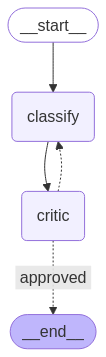

In [55]:
from IPython.display import Image, display
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [56]:
def process_intent_agent():
    # Initialize the input state based on the updated schema
    initial_state = {
        "message": message,
        "intents": [],    # Empty initial intents
        "feedback": ""    # Empty initial feedback
    }
    
    # Invoke the compiled graph
    result = compiled_graph.invoke(initial_state)
    
    # Display the final result
    print("\n===== Final Results =====")
    
    # Print extracted intents
    print("\n--- Identified Intents ---")
    for intent in result['intents']:
        print(f"Order: {intent['order']}")
        print(f"Intent: {intent['intent']}")
        print(f"What: {intent['what']}")
        print(f"Sources: {intent['sources']}")
        print(f"Inputs: {intent['inputs']}")
        print(f"Outputs: {intent['outputs']}")
        # print(f"Method: {intent['method']}")
        print("-" * 30)
    
    # Print critic feedback
    print("\n--- Critic Feedback ---")
    if isinstance(result['feedback'], str):
        # Plain text feedback
        print(result['feedback'])
    else:
        # Structured feedback
        print(f"Status: {result['feedback']['status']}")
        print("\nDetailed Feedback:")
        for fb in result['feedback']['feedback']:
            print(f"Check: {fb['check']}")
            print(f"Status: {fb['status']}")
            print(f"Reason: {fb['reason']}")
            print("-" * 30)


In [57]:
# Test run
message = "Process the latests Tweets from Emmanuel Macron about cryptos by summarizing theirs sentiments and emailing them to contact@bbschool.fr."
process_intent_agent()

Agent: Classify Intent - Processing input message...
intents=[IntentOutputStep(order=1, intent='login', what="Fetch the Twitter API credentials to access Emmanuel Macron's tweets.", sources=[], inputs=[], outputs=['twitter_api_credentials']), IntentOutputStep(order=2, intent='action', what='Open Twitter API and authenticate using the fetched credentials.', sources=[1], inputs=['twitter_api_credentials'], outputs=['authenticated_twitter_api']), IntentOutputStep(order=3, intent='query', what='Fetch the latest tweets from Emmanuel Macron about cryptos using the authenticated Twitter API.', sources=[2], inputs=['authenticated_twitter_api'], outputs=['tweets_data']), IntentOutputStep(order=4, intent='extract', what='Extract sentiment and relevant information from the fetched tweets about cryptos.', sources=[3], inputs=['tweets_data'], outputs=['sentiments', 'keywords']), IntentOutputStep(order=5, intent='summarize', what='Summarize the extracted sentiments and keywords from the tweets.', so

# Exemples LangSmith et Langraph Studio

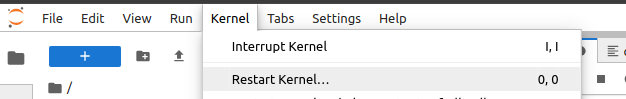

**Restart le kernel ici** pour permettre à Langchain et Langsmith de se configurer pour l'usage de votre instance hébérgée de LangSmith.

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from the custom file
load_dotenv("config.env")

True

In [2]:
# Retrieve and store the variables exactly as named
LANGCHAIN_ENDPOINT = os.getenv("LANGCHAIN_ENDPOINT")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
NGROK_AUTHTOKEN = os.getenv("NGROK_AUTHTOKEN")
NGROK_SUBDOMAIN = os.getenv("NGROK_SUBDOMAIN")

In [3]:
import openai

from langsmith import Client, tracing_context, traceable
from langsmith.wrappers import wrap_openai

from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.output_parsers import PydanticOutputParser

from pydantic import BaseModel, Field

In [12]:
# Initialisation du client LangSmith
from langsmith import Client

langsmith_client = Client()

url = next(langsmith_client.list_runs(project_name="test")).url
print(url)

https://smith.langchain.com/o/74691241-c822-4de0-ae26-8753e737cc9c/projects/p/e4c4c688-6469-4614-b74c-314d8e6f6ad6/r/8b2d5394-5472-48ff-a7b2-f546ba2a3ae9?trace_id=8b2d5394-5472-48ff-a7b2-f546ba2a3ae9&start_time=2025-03-10T15:37:32.361091


In [5]:
# Initializing a language model (LLM) using the ChatOllama class
# temperature is set to 0, meaning deterministic responses with no randomness
target_llm = ChatOllama(model="llama3.2", temperature=0, max_retries=2)

In [6]:
ext_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_retries=2,
    api_key=OPENAI_API_KEY
)

In [7]:
# Avec un client ollama compatible OpenAI API
# openai_llm = openai.Client(
#     api_key="ollama", 
#     base_url="http://localhost:11434/v1"
# )

## Une première trace

In [10]:
# Avec le client de Langchain

display(ext_llm.invoke("Hello BBS!"))

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-8b2d5394-5472-48ff-a7b2-f546ba2a3ae9-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

https://smith.langchain.com/o/74691241-c822-4de0-ae26-8753e737cc9c/projects/p/e4c4c688-6469-4614-b74c-314d8e6f6ad6/r/98a224b9-6a8c-4ed6-9ad3-59bbae435c63?trace_id=98a224b9-6a8c-4ed6-9ad3-59bbae435c63&start_time=2025-03-10T15:35:16.203953


In [ ]:
next(langsmith_client.list_runs(project_name="test")).url

In [13]:
# Avec le client de OpenAI
openai_llm = openai.Client(
    api_key=OPENAI_API_KEY
)
wrapped_openai_client = wrap_openai(openai_llm)

@traceable # Auto-trace this function
def pipeline(user_input: str):
    result = wrapped_openai_client.chat.completions.create(
        messages=[{"role": "user", "content": user_input}],
        model="gpt-4o-mini"
    )
    return result.choices[0].message.content

pipeline("Bonjour les apprenants de la BBS!")

"Bonjour ! Comment puis-je vous aider aujourd'hui ?"

In [14]:
next(langsmith_client.list_runs(project_name="test")).url

'https://smith.langchain.com/o/74691241-c822-4de0-ae26-8753e737cc9c/projects/p/e4c4c688-6469-4614-b74c-314d8e6f6ad6/r/5a2c5b0d-0860-4089-bb36-71b1c610bd3a?trace_id=5dd9e5ad-18b5-4fb9-a928-083cfcc67dec&start_time=2025-03-10T15:39:50.451085'

## Une évaluation

### Un dataset

In [15]:
# 📚 Création du dataset pour des tests de question/réponse
dataset = langsmith_client.create_dataset(
    "BBS_QA_Dataset",
    description="Exemples de questions et réponses pour la Blockchain Business School, incluant les programmes en IA depuis 2024.",
)

# 🌟 Ajout d'exemples dans le dataset
langsmith_client.create_examples(
    inputs=[
        {"question": "Qu'est-ce que la Blockchain Business School?"},
        {"question": "Quels sont les programmes proposés par la BBS?"},
        {"question": "Depuis quand la BBS propose-t-elle des programmes en IA?"},
        {"question": "Comment postuler à la Blockchain Business School?"},
    ],
    outputs=[
        {"answer": "La Blockchain Business School est un établissement dédié à l'enseignement des technologies blockchain et des modèles économiques décentralisés."},
        {"answer": "La BBS propose des programmes sur la blockchain, la tokenisation, les smart contracts, la finance décentralisée, ainsi que sur l'intelligence artificielle depuis 2024."},
        {"answer": "La BBS propose des programmes en intelligence artificielle depuis 2024, en complément de ses cursus sur la blockchain."},
        {"answer": "Pour postuler, rendez-vous sur le site officiel de la Blockchain Business School et suivez les instructions d'inscription."},
    ],
    dataset_id=dataset.id,
)

print("Dataset créé 🎉 Les questions/réponses sont disponibles dans LangSmith!")

Dataset créé 🎉 Les questions/réponses sont disponibles dans LangSmith!


### Un scenario

In [16]:
# Fonction principale pour gérer les requêtes utilisateur
def target(inputs: dict) -> dict:
    # Historique en dur intégré dans les messages
    messages = [
        SystemMessage(content="Répondez aux questions avec précision en tenant compte de l'historique."),
        HumanMessage(content="Qu'est-ce que la Blockchain Business School?"),
        AIMessage(content="La Blockchain Business School est un établissement dédié à l'enseignement des technologies blockchain."),
        HumanMessage(content="Quels sont les programmes proposés par la BBS?"),
        AIMessage(content="La BBS propose des programmes sur la blockchain et l'intelligence artificielle depuis 2024."),
        # Ajout de la question actuelle
        HumanMessage(content=inputs["question"]),
    ]

    # Préparer le prompt avec le template LangChain
    prompt = ChatPromptTemplate.from_messages(messages)

    # Appel au modèle
    response = target_llm.invoke(prompt.format())

    # Retourne la réponse
    return {"response": response.content.strip()}


In [17]:
# target({"question": "Depuis quand la BBS propose-t-elle des programmes en IA?"})

### Un juge

Pour ajouter du "impartiel", nous allons utiliser ChatGPT pour evaluer notre modèle Ollama.

In [18]:
# Define Output Schema
class Grade(BaseModel):
    score: bool = Field(
        description="Boolean indicating whether the response is conceptually accurate relative to the reference."
    )

# Enable Structured Output Parsing
structured_llm = ext_llm.with_structured_output(Grade, method="function_calling")

# Define Evaluation Function
def accuracy(outputs: dict, reference_outputs: dict) -> bool:
    # Instructions intégrées
    instructions = """
    Évaluez la réponse donnée par le Target par rapport à la Réponse de Référence pour vérifier la similarité conceptuelle et classifiez comme vrai ou faux :
    - Faux : Aucun lien conceptuel ou similarité.
    - Vrai : Correspondance conceptuelle partielle ou totale.
    - Critères clés : Les concepts doivent correspondre, même si la formulation est différente.
    """

    # Préparer la requête
    prompt = f"""
    {instructions}

    Réponse de Référence : {reference_outputs['answer']}
    Réponse du Target : {outputs['response']}
    """

    # Appel au modèle avec sortie structurée
    try:
        response = structured_llm.invoke(prompt)
        return response.score
    except Exception as e:
        print(f"Erreur de parsing : {e}")
        return False


In [19]:
# accuracy({"response": "La BBS propose des programmes sur la blockchain et l'intelligence artificielle depuis 2024."}, {"answer": "La BBS enseigne la blockchain et l'IA depuis 2024."})

### Une expérience

Il s'agit en fait d'une évaluation sur un dataset avec un juge

In [20]:
# After running the evaluation, a link will be provided to view the results in langsmith
from langsmith import evaluate

experiment_results = evaluate(
  target,
  data="BBS_QA_Dataset",
  evaluators=[
      accuracy,
      # can add multiple evaluators here
  ],
  experiment_prefix="ma-première-xp",
  max_concurrency=1,
)

View the evaluation results for experiment: 'ma-première-xp-3f13497b' at:
https://smith.langchain.com/o/74691241-c822-4de0-ae26-8753e737cc9c/datasets/1d163d28-3180-42df-ac27-217747c0c2cc/compare?selectedSessions=b1e8412f-4e30-48f1-976b-85ffa82d5ee9




0it [00:00, ?it/s]

## Langraph Studio

Langraph Studio est un utilitaire qui nous permet de tester en conditions reèlle le fonctionnement de nos pipelines (input->graph->state->résultat).
Pour établir un environnement de validation E2E (end-to-end), nous devons déclarer et construir un environnement de deploiement indépendant de notre environnement de développement.

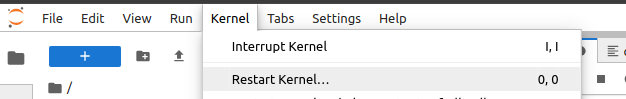

**Restart le kernel ici** pour permettre à Langchain et Langsmith de se configurer pour l'usage de votre instance hébérgée de LangSmith.

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from the custom file
load_dotenv("config.env")

True

### Ce projet n'est qu'un simple exemple, il n'est pas d'interêt particulier

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama


# Define state structure
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Chat interface 
target_llm = ChatOllama(model="llama3.2", temperature=0, max_retries=2)


# Create and configure graph
graph = (
    StateGraph(State)
    .add_node("chatbot", lambda state: {"messages": [target_llm.invoke(state["messages"])]})
    .add_edge(START, "chatbot")
    .add_edge("chatbot", END)
    .compile()
)


# Chat interface
def chat():
    while True:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        messages = {"messages": [HumanMessage(content=user_input)]}
        for event in graph.stream(input=messages):
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)

### Préparer le projet de debug

In [3]:
import pkg_resources
import os


def generate_requirements(base_filename="requirements"):
    # Get all installed packages and their versions
    installed_packages = pkg_resources.working_set

    # Create two lists: one with versions and one without
    packages_with_versions = sorted([f"{pkg.key}=={pkg.version}" for pkg in installed_packages])
    packages_without_versions = sorted([f"{pkg.key}" for pkg in installed_packages])

    try:
        # Write requirements.txt (without versions)
        requirements_file = f"{base_filename}.txt"
        with open(requirements_file, "w") as file:
            file.write("\n".join(packages_without_versions))
        print(f"Successfully generated '{requirements_file}' with package names.")

        # Write requirements-versions.txt (with versions)
        versions_file = f"{base_filename}-versions.txt"
        with open(versions_file, "w") as file:
            file.write("\n".join(packages_with_versions))
        print(f"Successfully generated '{versions_file}' with package names and versions.")

    except IOError as e:
        print(f"Failed to write requirements files: {e}")


# Run the function
generate_requirements()

Successfully generated 'requirements.txt' with package names.
Successfully generated 'requirements-versions.txt' with package names and versions.


/tmp/ipykernel_1175041/2260285281.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [3]:
import json

def write_langgraph_json():
    # Contenu du fichier
    data = {
        "dependencies": ["."],
        "graphs": {},
        "env": "config.env"
    }
    
    # Écriture dans le fichier langgraph.json
    with open('langgraph.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Fichier 'langgraph.json' écrit avec succès.")

# Initialisation du script 
write_langgraph_json()

Fichier 'langgraph.json' écrit avec succès.


#### Export du code source à débug

In [4]:
import ast
from typing import Set, Dict, List

def gather_notebook_source():
    ip = get_ipython()
    if ip is None or not hasattr(ip, 'user_ns'):
        raise RuntimeError("This script must be executed from a Jupyter Notebook.")
    notebook_cells = ip.user_ns.get('In', [])
    return "\n".join(notebook_cells)


def export_notebook_function(entry_point, graph_name):
    """
    Exports a specified object or function and its dependencies from a Jupyter Notebook to a standalone Python file.
    Updates the `langgraph.json` file to include the new function.

    Args:
        entry_point (str, object, or callable): The name, reference of the object, or function to export.
        output_file (str, optional): The name of the output Python file. If not provided, it will be derived from the entry_point name.
    """
    # Step 1: Gather notebook source code
    source_code = gather_notebook_source()
    try:
        module_ast = ast.parse(source_code)
    except SyntaxError as e:
        raise RuntimeError(f"Failed to parse notebook source: {e}")

    top_level_nodes = module_ast.body
    symbol_table = build_symbol_table(top_level_nodes)

    # Step 2: Determine the entry point name
    if isinstance(entry_point, str):
        entry_point_name = entry_point
    elif callable(entry_point):
        entry_point_name = entry_point.__name__
    elif hasattr(entry_point, '__class__') and hasattr(entry_point.__class__, '__name__'):
        entry_point_name = entry_point.__class__.__name__
    else:
        raise TypeError("entry_point must be a string, callable, or object with a class name.")

    # Derive output file name if not provided
    output_file = f"{entry_point_name}.py"

    # Step 3: Perform dependency analysis
    dependencies = collect_dependencies(entry_point_name, symbol_table, top_level_nodes)
    imports = collect_imports(top_level_nodes, dependencies)
    cleaned_imports = deduplicate_imports(imports, list(dependencies))
    ordered_dependencies = order_dependencies(dependencies, top_level_nodes)
    reconstructed_code = reconstruct_code(cleaned_imports + ordered_dependencies)

    # Step 4: Write the reconstructed code to the output file
    graph_folder = f"./{graph_name}"
    output_path = os.path.join(graph_folder, output_file)
    init_file_path = os.path.join(graph_folder, "__init__.py")
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Write to the file
        with open(output_path, 'w') as file:
            file.write(reconstructed_code)

        # Write the __init__.py file
        with open(init_file_path, 'w') as init_file:
            init_file.write(f"from .{output_file} import {graph_name}\n\n")
            init_file.write(f'__all__ = ["{graph_name}"]\n\n')
            init_file.write(f'__version__ = "0.0.1"\n\n')
            
    except IOError as e:
        raise RuntimeError(f"Failed to write to file '{output_path}': {e}")
    print(f"Exported successfully to {output_path}")

    # Step 5: Update langgraph.json
    langgraph_file = "langgraph.json"
    try:
        if os.path.exists(langgraph_file):
            with open(langgraph_file, 'r') as json_file:
                langgraph_data = json.load(json_file)
        else:
            langgraph_data = {"dependencies": ["."], "graphs": {}, "env": ".env"}

        # Add or update the entry in "graphs"
        langgraph_data["graphs"][entry_point_name] = f"./{graph_name}/{output_file}:{graph_name}"

        with open(langgraph_file, 'w') as json_file:
            json.dump(langgraph_data, json_file, indent=4)
        print(f"Updated '{langgraph_file}' with new entry for '{entry_point_name}'.")
    except IOError as e:
        raise RuntimeError(f"Failed to update '{langgraph_file}': {e}")


def build_symbol_table(nodes: List[ast.AST]) -> Dict[str, ast.AST]:
    symbol_table = {}
    for node in nodes:
        if isinstance(node, (ast.FunctionDef, ast.ClassDef)):
            symbol_table[node.name] = node
        elif isinstance(node, ast.Assign):
            for target in node.targets:
                if isinstance(target, ast.Name):
                    symbol_table[target.id] = node
        elif isinstance(node, (ast.Import, ast.ImportFrom)):
            symbol_table[f"import_{len(symbol_table)}"] = node
    return symbol_table


def collect_dependencies(obj_name: str, symbol_table: Dict[str, ast.AST], 
                         top_level_nodes: List[ast.AST],
                         visited: Set[str] = None) -> Set[ast.AST]:
    """
    Recursively collects all dependencies for a given object, including global method calls.
    """
    if visited is None:
        visited = set()

    if obj_name in visited:
        return set()
    visited.add(obj_name)

    obj_node = symbol_table.get(obj_name)
    if not obj_node:
        raise RuntimeError(f"Object '{obj_name}' not found in symbol table.")

    dependencies = {obj_node}

    # Collect all names used in the object's definition
    used_names = {node.id for node in ast.walk(obj_node) if isinstance(node, ast.Name)}

    # Include relevant global method calls
    for node in top_level_nodes:
        if isinstance(node, ast.Expr) and isinstance(node.value, ast.Call):
            call_obj = node.value.func
            # Check if the method call uses known symbols (functions or variables)
            if isinstance(call_obj, ast.Name) and call_obj.id == obj_name:
                dependencies.add(node)
            elif isinstance(call_obj, ast.Attribute) and isinstance(call_obj.value, ast.Name):
                if call_obj.value.id == obj_name:
                    dependencies.add(node)
            # Add arguments that reference known symbols
            for arg in node.value.args:
                if isinstance(arg, ast.Name) and arg.id in symbol_table:
                    dependencies.update(collect_dependencies(arg.id, symbol_table, top_level_nodes, visited))

    # Collect dependencies of the used names
    for name in used_names:
        if name in symbol_table:
            dependencies.update(collect_dependencies(name, symbol_table, top_level_nodes, visited))

    return dependencies


def collect_imports(top_level_nodes: List[ast.AST], dependencies: Set[ast.AST]) -> List[ast.AST]:
    imports = []
    for node in top_level_nodes:
        if isinstance(node, (ast.Import, ast.ImportFrom)):
            imports.append(node)
    return imports


def deduplicate_imports(imports: List[ast.AST], dependencies: List[ast.AST]) -> List[ast.AST]:
    used_symbols = set()
    for dep in dependencies:
        for node in ast.walk(dep):
            if isinstance(node, ast.Name):
                used_symbols.add(node.id)

    import_statements = set()
    from_imports = {}

    for node in imports:
        if isinstance(node, ast.Import):
            for alias in node.names:
                if alias.asname:
                    if alias.asname in used_symbols:
                        import_statements.add(f"import {alias.name} as {alias.asname}")
                elif alias.name.split('.')[0] in used_symbols:
                    import_statements.add(f"import {alias.name}")
        elif isinstance(node, ast.ImportFrom):
            module = node.module
            for alias in node.names:
                if alias.asname:
                    if alias.asname in used_symbols:
                        if module not in from_imports:
                            from_imports[module] = set()
                        from_imports[module].add(f"{alias.name} as {alias.asname}")
                elif alias.name in used_symbols:
                    if module not in from_imports:
                        from_imports[module] = set()
                    from_imports[module].add(alias.name)

    deduplicated_imports = []

    for statement in sorted(import_statements):
        deduplicated_imports.append(ast.parse(statement).body[0])

    for module, names in sorted(from_imports.items()):
        import_line = f"from {module} import {', '.join(sorted(names))}"
        deduplicated_imports.append(ast.parse(import_line).body[0])

    return deduplicated_imports


def order_dependencies(dependencies: Set[ast.AST], top_level_nodes: List[ast.AST]) -> List[ast.AST]:
    return [node for node in top_level_nodes if node in dependencies]


def reconstruct_code(nodes: List[ast.AST]) -> str:
    try:
        return "\n".join(ast.unparse(node) for node in nodes)
    except AttributeError:
        raise RuntimeError("This script requires Python 3.9 or later to use 'ast.unparse'.")


# Example usage:

In [5]:
export_notebook_function(chat, 'graph')

Exported successfully to ./graph/chat.py
Updated 'langgraph.json' with new entry for 'chat'.


### Configurer LangraphStudio

Voir le notebook SetupBBS.ipynb

In [6]:
!curl --request GET --url 0.0.0.0:2024/ok

{"ok":true}

In [7]:
!python -m pip install flask pyngrok python-dotenv

In [8]:
!python LangraphStudioProxy.py

ngrok tunnel: NgrokTunnel: "https://901e-2a01-e0a-271-4050-00-362b-b06c.ngrok-free.app" -> "http://localhost:8123"
 * Serving Flask app 'LangraphStudioProxy'
 * Debug mode: off
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8123
 * Running on http://192.168.0.8:8123
Press CTRL+C to quit
127.0.0.1 - - [10/Mar/2025 16:48:16] "GET / HTTP/1.1" 404 -
t=2025-03-10T16:48:16+0100 lvl=warn msg="failed to check for update" obj=updater err="Post \"https://update.equinox.io/check\": context deadline exceeded"
127.0.0.1 - - [10/Mar/2025 16:48:16] "GET /favicon.ico HTTP/1.1" 204 -
127.0.0.1 - - [10/Mar/2025 16:48:35] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [10/Mar/2025 16:48:36] "GET /favicon.ico HTTP/1.1" 204 -
127.0.0.1 - - [10/Mar/2025 16:48:44] "OPTIONS /assistants/search HTTP/1.1" 200 -
127.0.0.1 - - [10/Mar/2025 16:48:44] "POST /assistants/search HTTP/1.1" 200 -
127.0.0.1 - - [10/Mar/2025 16:48:45] "OPTIONS /assistants/eb6db400-e3c8-5d06-a834-015cb89efe69/schemas HTTP/1.1" 2

Vous devriez avoir un URL, il faut ouvrir la page et accepter la rédirection

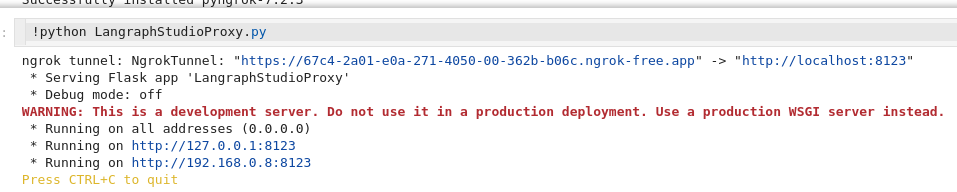

Cliquez sur 'Visiter' puis fermez l'onglet.

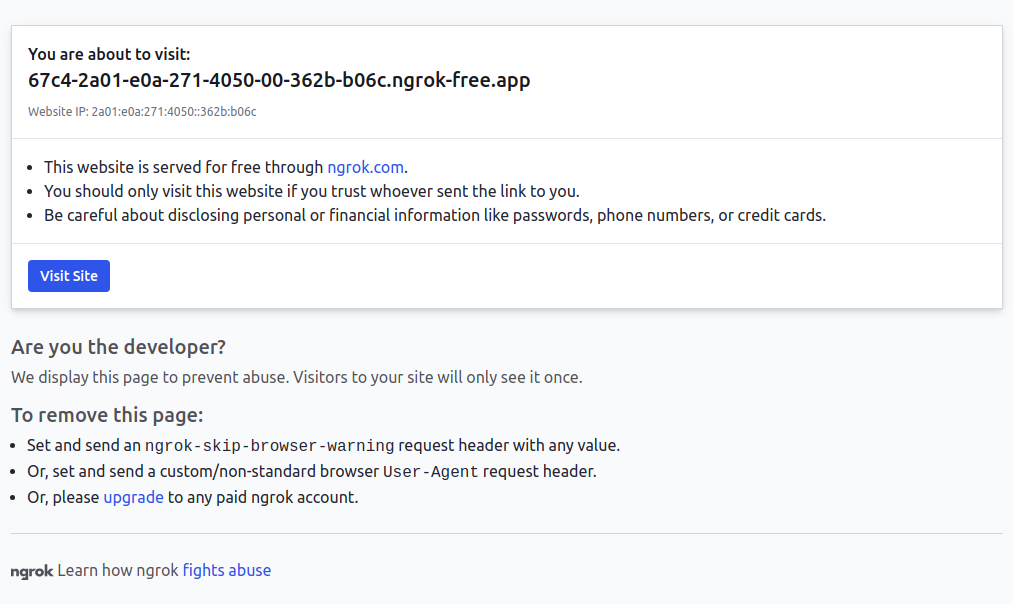

Copiez dans le presse-papier le URL de la page et allez sur le dashboard de [LangGraph](https://smith.langchain.com)  puis ouvrez le studio avec le URL que vous avez dans le presse papier:

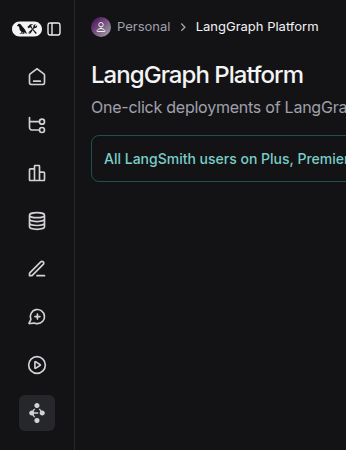
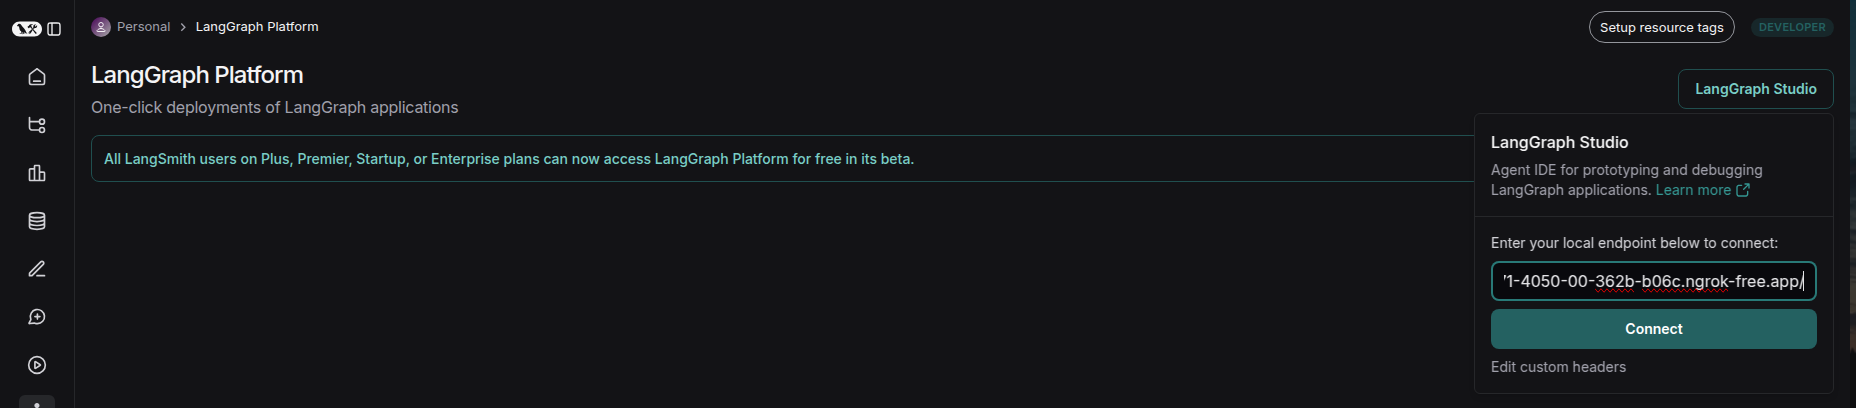

Happy testing! :)

---

# Partie pratiques et exemples

# RAG

Un Retrieval Augmented Generation est un système complèxe composé de trois stades: **ingestion** -> **recupération** -> **restitution**.  

Il est important de noter que, sauf si vous avez implementé une logique différent, l'utilisateur intéragis avec le moteur de recherche (et pas avec le modèle de language directement) donc les résultats sont proches de ce l'utilisateur recherche. S'il est possible d'ajouter de l'intélligence (comme avec un prototype de analyser d'intention pour ventiler les responsabilités), ce comportement sera à la résponsabilité du développeur de le rendre possible.  

Dans ce chapitre, je vous propose plusieurs implementations, les unes plus complèxe que les autres qui par contre necessitent progressivemment de plus de puissance de calcul, plus de crédits et plus de temps pour fonctionner.  

Il sera de votre ressort de les évaluer de la pertinence à vos besoins.

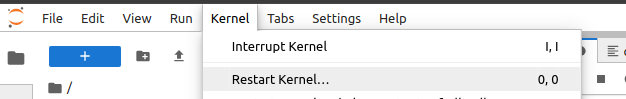

**Restart le kernel ici** pour permettre avoir un environnment propre de toute exécution précédente.

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from the custom file
load_dotenv("config.env")

True

## RAG niveau 1

Cette implémentation propose une **organisation modulaire** d’un pipeline **Retrieval-Augmented Generation (RAG)** en utilisant **Langraph** et une **classe Pydantic State** pour structurer les flux de données.  

#### Pourquoi cette approche ?
✅ **Modularité** : Chaque agent a une responsabilité spécifique (ingestion, récupération, restitution).  
✅ **Utilisation de Langraph** : Permet de structurer le pipeline sous forme de graphe d’exécution.  
✅ **Centralisation de l’état** : Grâce à une classe `RAGState`, toutes les étapes partagent leurs données de manière fluide.  
✅ **Extensibilité** : Facile à enrichir avec de nouvelles fonctionnalités (ex: feedback loop, post-traitement, analyse sémantique avancée).

---

#### 🏗️ Organisation du pipeline

Ce **pipeline RAG** est structuré autour de **trois agents** :

1. **📥 IngestionAgent**  
   - Charge un document depuis une URL.  
   - Effectue une segmentation en morceaux exploitables.  
   - Crée un index vectoriel pour la récupération d’informations.

2. **🔍 RetrievalAgent**  
   - Crée un index vectoriel pour la récupération d’informations.
   - Recherche les documents les plus pertinents en fonction de la requête.  
   - Formate les résultats pour qu'ils soient compréhensibles par le modèle de langage.

4. **📝 RestitutionAgent**  
   - Utilise un modèle **GPT-3.5-turbo** pour générer une réponse basée sur le contexte récupéré.  
   - Retourne une réponse structurée et optimisée.

---

#### ⚙️ Technologies utilisées

| 📌 Technologie | 🔎 Rôle |
|--------------|------------|
| **Langchain** | Gestion de la récupération et de la génération de texte |
| **Langraph** | Organisation du pipeline sous forme de graphe |
| **Pydantic** | Définition et validation des états de l’application |
| **ChromaDB** | Stockage et recherche des embeddings |

---

#### 📌 Structure du Code

Le pipeline est construit sous la forme d’un **graphe d’agents**, où chaque étape suit un ordre logique :

1️⃣ **Ingestion** → 2️⃣ **Récupération** → 3️⃣ **Restitution**  

Le graphe est ensuite compilé et exécuté pour traiter une requête utilisateur.

#### 🚀 Vos exércises

📌 **Ajout d'un feedback loop** pour affiner les résultats avec les retours utilisateurs.  
📌 **Extension à plusieurs sources de données** (fichiers PDF, bases de connaissances internes, API externes).  
💡 **À vous de jouer !** Expérimentez et adaptez cette implémentation selon vos besoins.

In [52]:
import os
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0"

from typing import List, Optional
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage  # To manage message types (human/system)
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph
from pydantic import BaseModel
import bs4

In [61]:
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

def get_chat_model(config):
    model_type = config["configurable"].get("model_type", "ollama")
    model_name = config["configurable"].get("model", "llama3.2")
    model_temperature = config["configurable"].get("temperature", 0.03)
    model_max_retries = config["configurable"].get("max_retry", 3)
    
    print(f"Selected Configuration:\n"
          f"Model Type: {model_type}\n"
          f"Model Name: {model_name}\n"
          f"Temperature: {model_temperature}\n"
          f"Max Retries: {model_max_retries}")

    if model_type.lower() == "ollama":
        # Return ChatOllama if the model type is "ollama"
        return ChatOllama(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries
        )
    elif model_type.lower() == "openai":
        # Return ChatOpenAI if the model type is "openai"
        return ChatOpenAI(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")

def get_embeddings(config):
    model_type = config["configurable"].get("embedding_type", "ollama")
    model_name = config["configurable"].get("embedding_model", "nomic-embed_text")

    print(f"Selected Embedding Configuration:\n"
          f"Embedding Type: {model_type}\n"
          f"Embedding Model: {model_name}")
    
    if model_type.lower() == "ollama":
        return OllamaEmbeddings(
            model=model_name
        )
    elif model_type.lower() == "openai":
        return OpenAIEmbeddings(
            model=model_name
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")

In [62]:
#### 🏗️ Définition de l'état global ####
class RAGState(BaseModel):
    query: str
    sources: List[str]
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[str]] = None
    answer: Optional[str] = None

In [63]:
#### 📥 Agent d'Ingestion ####
def ingestion_agent(state: RAGState) -> RAGState:
    loader = WebBaseLoader(
        web_paths=state.sources
    )
    docs = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    splits = text_splitter.split_documents(docs)

    # On retourne l'état avec le retriever prêt à l'emploi
    return {"available_docs": len(docs), "ingested": splits}

In [64]:
#### 🔍 Agent de Récupération ####
def retrieval_agent(state: RAGState) -> RAGState:
    if not state.available_docs > 0:
        raise ValueError("Aucun document indexé !")

    target_embedding = get_embeddings({
        "configurable": {
            "embedding_type": "ollama",
            "embedding_model": "nomic-embed-text"
        }
    })
    vectorstore = Chroma.from_documents(documents=state.ingested, embedding=target_embedding)
    retriever = vectorstore.as_retriever()
    docs = retriever.invoke(state.query)
    formatted_docs = "\n\n".join(doc.page_content for doc in docs)

    return {"retrieved_docs": [formatted_docs]}

In [65]:
#### 📝 Agent de Restitution ####
def restitution_agent(state: RAGState) -> RAGState:
    if not state.retrieved_docs:
        raise ValueError("Aucun document récupéré !")

    target_llm = get_chat_model({
        "configurable": {
            "model_type": "ollama",
            "model": "llama3.2",
            "temperature": 0,
            "max_retry": 2
        }
    })

    prompt_template = ChatPromptTemplate.from_template("""
    Répondez à la question en utilisant uniquement le contexte suivant :
    {context}

    Question : {question}
    """)
    chain = prompt_template | target_llm | StrOutputParser()
    response = chain.invoke({"context": state.retrieved_docs[0], "question": state.query})

    return {"answer": response}

In [66]:
#### 📌 Construction du graphe ####
graph = StateGraph(RAGState)

# Ajout des agents
graph.add_node("ingestion", ingestion_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)

# Connexion des étapes
graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "retrieval")
graph.add_edge("retrieval", "restitution")

# Exécution du pipeline
executor = graph.compile()

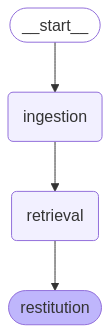

In [67]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [68]:
#### 🚀 Test du RAG organisé avec Langraph ####
query = "Comment utiliser un tool in LangChain?"
source= "https://github.com/P2Enjoy/academy-tutorial-python/blob/main/rag/rag/04-explain-langchain.md"
result = executor.invoke(RAGState(query=query, sources=[source]))

print("💬 Réponse :", result['answer'])

Selected Embedding Configuration:
Embedding Type: ollama
Embedding Model: nomic-embed-text
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 2
💬 Réponse : Pour répondre à la question "Comment utiliser un tool en LangChain ?", nous devons d'abord comprendre ce que sont les outils de LangChain et comment les intégrer dans notre code.

Les outils de LangChain sont des bibliothèques préconçues pour aider les développeurs à créer des agents de questions-réponses intelligents. Ils offrent une variété d'outils pour effectuer des tâches telles que la recherche, le traitement du langage naturel et l'intelligence artificielle.

Pour utiliser un outil de LangChain dans notre code, nous devons suivre les étapes suivantes :

1. Importer l'outil de LangChain que nous voulons utiliser.
2. Charger l'outil en utilisant la fonction `hub.load_tool` ou `create_react_agent`.
3. Utiliser l'outil pour effectuer des tâches spécifiques.

Voici un exemple de code qui ut

## RAG niveau 2 avec MultiQuery

Cette implémentation propose une **organisation modulaire avancée** d'un pipeline **Retrieval-Augmented Generation (RAG)** en utilisant **Langraph**, des **classes Pydantic State** pour structurer les flux de données, et une **stratégie MultiQuery** pour améliorer la qualité des résultats.

#### Pourquoi cette approche ?
✅ **Centralisation de l'état** : Grâce à des classes Pydantic (`RAGState`, `MultiQueryOutput`, `ResponseFormatter`), toutes les étapes partagent leurs données de manière structurée.  
✅ **Robustesse** : Utilisation de sorties structurées pour chaque étape du pipeline.  
✅ **Amélioration de la récupération** : Stratégie MultiQuery pour obtenir des résultats plus complets et pertinents.

---

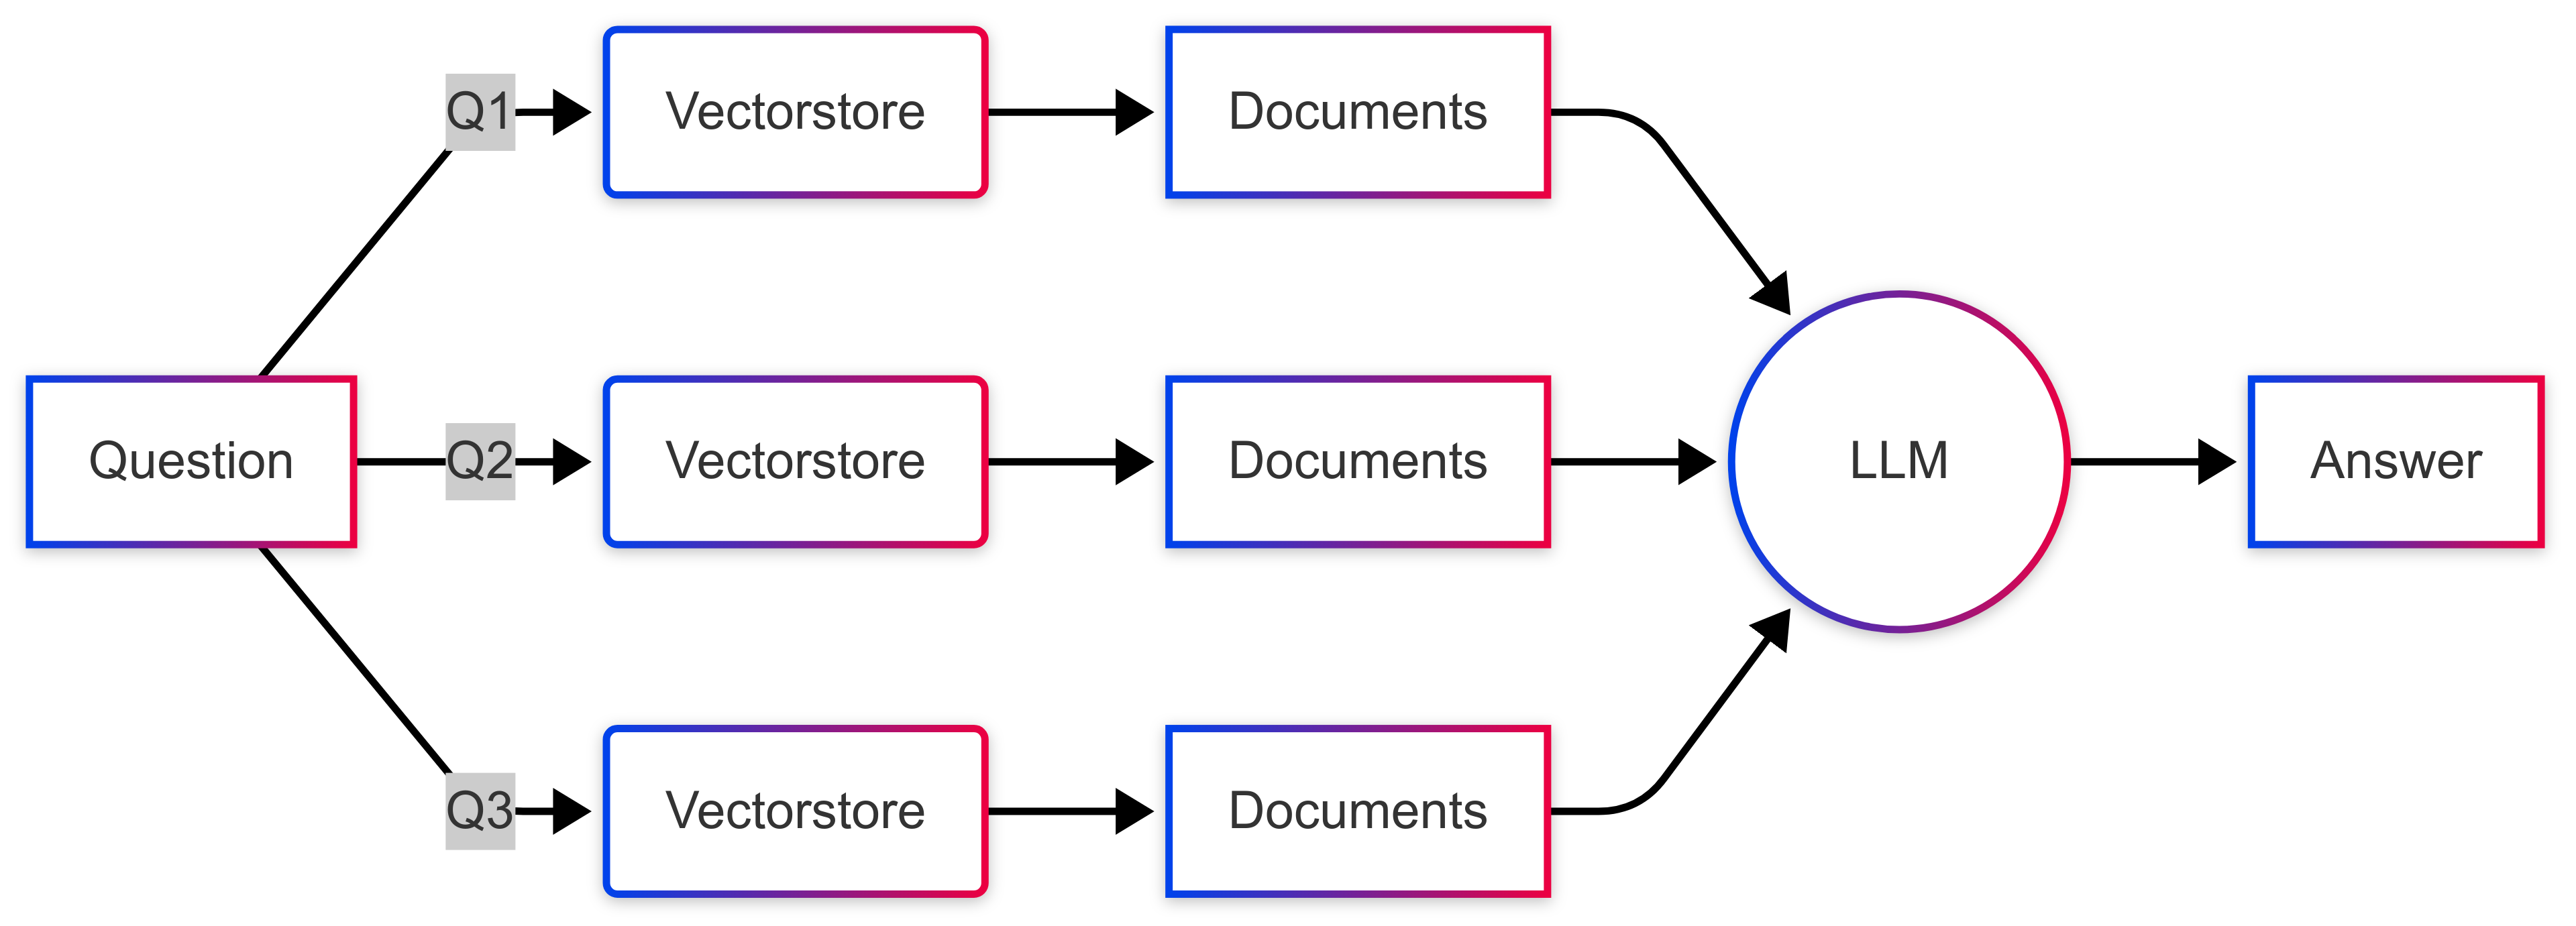

#### 🏗️ Organisation du pipeline

Ce **pipeline RAG** est structuré autour de **quatre agents** :

1. **📥 IngestionAgent**  
2. **🎯 MultiQueryAgent**  
   - Génère 3 à 5 variations de la question originale.  
   - Fournit un raisonnement explicite pour chaque variation.  
   - Utilise une sortie structurée (`MultiQueryOutput`) pour garantir la qualité.
3. **🔍 RetrievalAgent**  
4. **📝 RestitutionAgent**  
   - Utilise un modèle LLM pour générer une réponse basée sur le contexte enrichi.  
   - Retourne une réponse structurée (`ResponseFormatter`) avec sources.

---

#### 📌 Structure du Code

Le pipeline est construit sous la forme d'un **graphe d'agents**, avec un flux enrichi :

1️⃣ **Ingestion** → 2️⃣ **MultiQuery** → 3️⃣ **Récupération** → 4️⃣ **Restitution**

#### 🔍 Sorties Structurées

Le pipeline utilise trois classes Pydantic principales :

1. **MultiQueryOutput**
   ```python
   class MultiQueryOutput(BaseModel):
       queries: List[str]      # Liste des variations de requêtes
       reasoning: str          # Explication du raisonnement
   ```

2. **ResponseFormatter**
   ```python
   class ResponseFormatter(BaseModel):
       answer: str            # Réponse finale
       sources: List[str]     # Sources utilisées
   ```

3. **RAGState**
   ```python
   class RAGState(BaseModel):
       query: str
       sources: List[str]
       multiple_queries: Optional[MultiQueryOutput]
       answer: Optional[ResponseFormatter]
       # ... autres champs
   ```

#### 🚀 Exercises d'améliorations

📌 **Ajout d'un système de scoring** pour évaluer la qualité des variations de requêtes.  
📌 **Implémentation d'un feedback loop** pour affiner les résultats avec les retours utilisateurs.  
📌 **Extension à plusieurs sources de données** (PDF, bases de connaissances, API externes).  
📌 **Ajout d'un système de cache** pour les requêtes fréquentes.  

#### 📊 Avantages du MultiQuery

1. **Couverture améliorée** : Capture différentes perspectives d'une même question
2. **Robustesse** : Réduit la dépendance à une formulation unique
3. **Transparence** : Fournit un raisonnement explicite pour chaque variation
4. **Qualité** : Validation structurée des sorties à chaque étape

In [69]:
from typing import List, Optional
from pydantic import BaseModel, Field
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph
from operator import itemgetter
from langchain.load import dumps, loads

In [70]:
# Define structured outputs
class MultiQueryOutput(BaseModel):
    queries: List[str] = Field(
        description="List of alternative queries generated from the original question",
        min_items=1,
        max_items=5
    )
    reasoning: str = Field(
        description="Explanation of how the alternative queries were generated"
    )


class ResponseFormatter(BaseModel):
    answer: str = Field(description="The response to the user's question.")
    sources: List[str] = Field(description="The sources used to generate the answer.")


# Enhanced state definition
class RAGState(BaseModel):
    query: str
    sources: List[str]
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[str]] = None
    multiple_queries: Optional[MultiQueryOutput] = None
    answer: Optional[ResponseFormatter] = None

In [71]:
# Multiquery generation agent with structured output
def multiquery_agent(state: RAGState) -> RAGState:
    template = """You are an AI language model assistant. Your task is to:
    1. Generate between 3-5 different versions of the given user question
    2. Each version should provide a different perspective or approach to the original question
    3. Explain your reasoning for generating these specific variations

    Original question: {question}

    Provide your response in a structured format with:
    - A list of alternative queries
    - Your reasoning for generating these specific variations
    """

    target_llm = get_chat_model({
        "configurable": {
            "model_type": "ollama",
            "model": "llama3.2",
            "temperature": 0,
            "max_retry": 2
        }
    })
    prompt = ChatPromptTemplate.from_template(template)
    structured_llm = target_llm.with_structured_output(MultiQueryOutput, method="function_calling")
    chain = prompt | structured_llm

    result = chain.invoke({"question": state.query})
    return {"multiple_queries": result}

In [72]:
def get_unique_union(documents: list[list]) -> List[Document]:
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]


# Modified retrieval agent to use structured multiquery output
def retrieval_agent(state: RAGState) -> RAGState:
    if not state.available_docs > 0:
        raise ValueError("No documents indexed!")

    target_embedding = get_embeddings({
        "configurable": {
            "embedding_type": "ollama",
            "embedding_model": "nomic-embed-text"
        }
    })

    vectorstore = Chroma.from_documents(documents=state.ingested, embedding=target_embedding)
    retriever = vectorstore.as_retriever()

    # Retrieve documents for each query
    all_docs = []
    for query in state.multiple_queries.queries:  # Now accessing the structured output
        docs = retriever.invoke(query)
        all_docs.append(docs)

    # Get unique documents
    unique_docs = get_unique_union(all_docs)
    formatted_docs = "\n\n".join(doc.page_content for doc in unique_docs)

    return {"retrieved_docs": [formatted_docs]}

In [73]:
# Restitution agent remains the same
def restitution_agent(state: RAGState) -> RAGState:
    if not state.retrieved_docs:
        raise ValueError("No documents retrieved!")

    prompt_template = ChatPromptTemplate.from_template("""
    Answer the question using only the following context:
    {context}

    Question: {question}
    
    Return your response in a structured format with the answer and the sources used.
    """)

    target_llm = get_chat_model({
        "configurable": {
            "model_type": "ollama",
            "model": "llama3.2",
            "temperature": 0,
            "max_retry": 2
        }
    })

    structured_llm = target_llm.with_structured_output(ResponseFormatter, method="function_calling")
    chain = prompt_template | structured_llm

    response = chain.invoke({
        "context": state.retrieved_docs[0],
        "question": state.query
    })

    return {"answer": response}

In [74]:
# Build the graph
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)

# Connect the steps
graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "multiquery")
graph.add_edge("multiquery", "retrieval")
graph.add_edge("retrieval", "restitution")

# Compile the pipeline
executor = graph.compile()

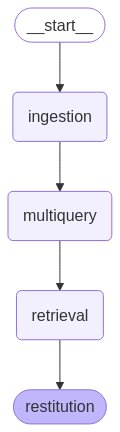

In [75]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [76]:
query = "Comment implementer un tool in LangChain in python?"
source = "https://github.com/P2Enjoy/academy-tutorial-python/blob/main/rag/rag/04-explain-langchain.md"
result = executor.invoke(RAGState(query=query, sources=[source]))

display("💬 Generated Queries:", result['multiple_queries'].queries)
display("🤔 Query Generation Reasoning:", result['multiple_queries'].reasoning)
print("📝 Final Answer:", result['answer'].answer)

Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 2
Selected Embedding Configuration:
Embedding Type: ollama
Embedding Model: nomic-embed-text
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 2


'💬 Generated Queries:'

['How to implement a tool in LangChain using Python?',
 'What is the best way to integrate a tool in LangChain with Python?',
 'Can you provide an example of implementing a tool in LangChain using Python?']

'🤔 Query Generation Reasoning:'

'The alternative queries were generated by considering different perspectives on the original question, including providing more specific information about the implementation process, asking for the best approach or method, and requesting an example to illustrate the concept.'

📝 Final Answer: To implement a tool in LangChain using Python, you can use the Tool class from langchain.tools. Here is an example: 

import langchain  
from langchain import OpenAI  
from langchain.tools import Tool  

# Create an instance of the OpenAI model  
openai = OpenAI()  

# Define a new tool that uses the OpenAI model  
tool = Tool(  
    name='my_tool',  
    description='A simple tool using OpenAI',  
    run_func=openai.run,  
    model_name='babbage/chiome',  
    max_tokens=2000,  
    num_returned_answers=1  
)  

# Use the new tool to get an answer


## RAG level 3 avec FAISS, stored index, configurable

Cette nouvelle version introduit notamment un **initializer_agent** pour déterminer dynamiquement le chemin à suivre (ingestion ou multiquery) et inclut des modifications dans la gestion des sources, l’indexation FAISS et la restitution.

---

#### 🏗️ Organisation du pipeline

Ce **pipeline RAG** est désormais structuré autour de **cinq agents** :

1. **🏁 initializer_agent**  
   - Vérifie l'existence d'un index FAISS local.  
   - Oriente le flux vers l'agent d’ingestion ou directement vers l’agent multiquery.
2. **📥 ingestion_agent**  
3. **🎯 multiquery_agent**  
4. **🔍 retrieval_agent**  
   - Crée ou recharge un index FAISS local (avec `OllamaEmbeddings`).  
   - Effectue une recherche par similarité et consolide les résultats (dédoublonnage).  
   - Retourne la liste des documents pertinents.
5. **📝 restitution_agent**

---

#### 🔄 Amélioration du Retrieval avec RRF (Reciprocal Rank Fusion)

Le `retrieval_agent` a été optimisé pour intégrer le **Reciprocal Rank Fusion**, une méthode sophistiquée de fusion des résultats de recherche.

##### Pourquoi RRF ?
✅ **Fusion intelligente** : Combine les résultats de plusieurs requêtes en une seule liste ordonnée  
✅ **Robustesse** : Réduit l'impact des résultats aberrants et favorise les documents pertinents récurrents  
✅ **Pas de normalisation** : Fonctionne directement sur les rangs, sans nécessiter de normalisation des scores

##### Fonctionnement du RRF

1. **Collecte des résultats**
   ```python
   # Pour chaque variante de requête générée par multiquery_agent
   query_results = []
   for query in queries:
       docs = vectorstore.similarity_search(query, k=10)
       query_results.append(docs)
   ```

2. **Calcul des scores RRF**
   ```python
   RRF_score(document) = Σ 1/(rang + k)
   ```
   où:
   - `rang` est la position du document dans chaque liste de résultats
   - `k` est une constante (60 par défaut) qui atténue l'impact des rangs élevés
   
3. **Exemple de scoring**
   Si un document apparaît aux positions :
   - Rang 1 dans Query 1 : 1/(1 + 60) = 0.0164
   - Rang 3 dans Query 2 : 1/(3 + 60) = 0.0159
   - Rang 5 dans Query 3 : 1/(5 + 60) = 0.0154
   Son score RRF final sera : 0.0477

##### Impact sur le pipeline

- **Simplification** : Fusion de la récupération et du ré-ordonnancement en une seule étape
- **Performance** : Réduction du nombre d'opérations sur le vectorstore
- **Qualité** : Meilleure pertinence des résultats grâce à la prise en compte de multiples perspectives de recherche

In [77]:
from typing import List, Optional, Dict, Literal, Any
from pydantic import BaseModel, Field
from operator import itemgetter

from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader

from langchain_community.vectorstores import Chroma
from langchain_community.vectorstores import FAISS

from langchain_core.runnables.config import RunnableConfig
from langchain_core.runnables import RunnablePassthrough
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from langchain.load import dumps, loads

In [78]:
# Structured Output Models
class DocumentMetadata(BaseModel):
    source_url: str
    chunk_id: int


class MultiQueryOutput(BaseModel):
    queries: List[str] = Field(
        description="List of alternative queries generated from the original question",
        min_items=1,
        max_items=5
    )
    reasoning: str = Field(
        description="Explanation of how the alternative queries were relevant to expand the search space for the user query"
    )


class ResponseFormatter(BaseModel):
    answer: str = Field(description="The response to the user's question.")


class ResponseOutput(BaseModel):
    answer: str = Field(description="The response to the user's question.")
    sources: List[DocumentMetadata] = Field(description="The metadata of sources used to generate the answer.")

In [79]:
# State Management
class RAGState(BaseModel):
    query: str
    sources: Dict[str, Any] = None
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[Document]] = None
    multiple_queries: Optional[MultiQueryOutput] = None
    answer: Optional[ResponseOutput] = None

In [80]:
# Source Loader Factory
class SourceLoader:
    @staticmethod
    def get_loader(source_type: str, location: str):
        loaders = {
            "web": lambda loc: WebBaseLoader(web_paths=[loc]),
            "pdf": lambda loc: PyPDFLoader(loc),
        }

        loader = loaders.get(source_type.lower())
        if not loader:
            raise ValueError(f"Unsupported source type: {source_type}")

        return loader(location)

In [7]:
def get_vector_store(config, target_embedding, index_name, state):
    """
    Retrieves or builds a FAISS vector store based on the provided configuration.
    
    Args:
        config (dict): Configuration dictionary containing the path to the stored index.
        target_embedding: Embedding function or model.
        index_name (str): The name of the index.
        state: An object containing the ingested documents if the index needs to be rebuilt.

    Returns:
        FAISS: The FAISS vector store instance.
    """
    stored_index_base = config["configurable"].get("stored_index")
    stored_index_type = config["configurable"].get("embedding_type")
    stored_index_model = config["configurable"].get("embedding_model")

    # La base vectorielle change avec le modèle de embedding (la dimensionnalité et le typage pourraient changer)
    stored_index_path = f"{stored_index_base}.{stored_index_type}.{stored_index_model}"

    try:
        vectorstore = FAISS.load_local(
            folder_path=stored_index_path,
            embeddings=target_embedding,
            index_name=index_name,
            allow_dangerous_deserialization=True
        )
        print("✅ Data index loaded from cache!")
    except Exception as e:
        print(f"⚠️ Failed to load index from cache.")
        print("🔄 Building the index from documents...")
        
        vectorstore = FAISS.from_documents(
            documents=state.ingested,
            embedding=target_embedding
        )
        
        vectorstore.save_local(stored_index_path, index_name=index_name)
        print("💾 Index saved locally!")

    return vectorstore

In [82]:
def initializer_agent(state: RAGState, config: RunnableConfig) -> Literal["ingestion", "multiquery"]:
    """
    Determines the flow based on whether documents need to be loaded
    and if FAISS index exists
    """
    faiss_index_path = config["configurable"].get("stored_index")
    faiss_index_exists = os.path.exists(faiss_index_path)

    if not faiss_index_exists:
        return "ingestion"
    else:
        return "multiquery"

In [83]:
def ingestion_agent(state: RAGState, config: RunnableConfig):
    """
    Handles document ingestion from multiple sources with proper document splitting
    and metadata preservation.
    """
    all_docs = []
    total_docs = 0
    global_chunk_id = 0

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config["configurable"].get("chunk_size", 500),
        chunk_overlap=config["configurable"].get("chunk_overlap", 100)
    )

    for source_type, source_locations in state.sources.items():
        if isinstance(source_locations, str):
            source_locations = [source_locations]

        for location in source_locations:
            try:
                loader = SourceLoader.get_loader(source_type, location)
                docs = loader.load()

                for doc in docs:
                    if not hasattr(doc, 'metadata'):
                        doc.metadata = {}

                    original_metadata = {
                        "source_url": location
                    }

                    splits = text_splitter.split_text(doc.page_content)

                    for split_text in splits:
                        split_doc = Document(
                            page_content=split_text,
                            metadata={
                                **original_metadata,
                                "chunk_id": global_chunk_id
                            }
                        )
                        all_docs.append(split_doc)
                        global_chunk_id += 1
                        total_docs += 1

            except Exception as e:
                continue

    if not all_docs:
        raise ValueError("No documents were successfully loaded")

    return {
        "available_docs": total_docs,
        "ingested": all_docs
    }


In [84]:
def multiquery_agent(state: RAGState, config: RunnableConfig):
    """
    Generates multiple query variations using structured output.
    """
    template = """You are an AI language model assistant. Your task is to:
    1. Generate between 3-5 different versions of the given user question
    2. Each version should provide a different perspective or approach to the original question
    3. Explain your reasoning for generating these specific variations

    Original question: {question}

    Provide your response in a structured format with:
    - A list of alternative queries
    - Your reasoning for generating these specific variations
    """

    target_llm = get_chat_model(config)

    # Initialize LLM and embeddings
    target_llm = get_chat_model(config)

    prompt = ChatPromptTemplate.from_template(template)
    structured_llm = target_llm.with_structured_output(MultiQueryOutput, method="function_calling")
    chain = prompt | structured_llm

    result = chain.invoke({
        "question": state.query
    })
    return {"multiple_queries": result}

In [85]:
def retrieval_agent(state: RAGState, config: RunnableConfig):
    """
    Retrieves relevant documents using FAISS with persistence.
    """

    # Create or load FAISS index
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    # Itérer sur toutes les requêtes générées + la query originale
    all_queries = [state.query] + state.multiple_queries.queries
    
    retrieved_docs = []
    seen_keys = set()
    
    for query in all_queries:
        docs = vectorstore.max_marginal_relevance_search(
            query=query,
            k=len(all_queries),
            fetch_k=2 * len(all_queries)
        )

        for doc in docs:
            key = (doc.page_content, doc.metadata.get('chunk_id'))
            if key not in seen_keys:
                retrieved_docs.append(doc)
                seen_keys.add(key)

    return {"retrieved_docs": retrieved_docs}

In [86]:
def restitution_agent(state: RAGState, config: RunnableConfig):
    """
    Generates final response with source attribution.
    """
    if not state.retrieved_docs:
        raise ValueError("No retrieved documents to generate response from")

    # Prepare context from retrieved documents
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)

    # Generate the response using the LLM
    target_llm = get_chat_model(config)
    response = target_llm.invoke(
        f"""Based on the following context, answer the question: ```{state.query}```
        
        Context: ```
{context}
        ```
        
        Provide a clear and direct answer."""
    )

    # Extract source metadata
    sources = [
        DocumentMetadata(
            source_url=doc.metadata.get("source_url", ""),
            chunk_id=doc.metadata.get("chunk_id", 0)
        )
        for doc in state.retrieved_docs
    ]

    # Format the response
    formatted_response = ResponseOutput(
        answer=response.content,
        sources=sources
    )

    return {"answer": formatted_response}

In [87]:
# Graph Construction
"""
Constructs and returns the RAG processing graph.
"""
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)

# Connect nodes
graph.add_conditional_edges(
    START,
    initializer_agent
)
# graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "multiquery")
graph.add_edge("multiquery", "retrieval")
graph.add_edge("retrieval", "restitution")
graph.add_edge("restitution", END)

from langgraph.graph.state import CompiledStateGraph
executor = graph.compile()

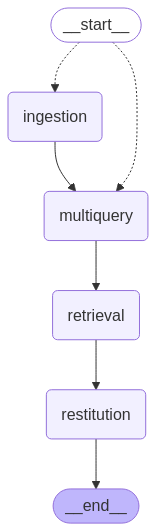

In [88]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [89]:
def process_query(query: str, sources: Dict[str, Any], config: Any):
    """
    Processes a query using the RAG system.
    """
    result = executor.invoke(RAGState(query=query, sources=sources), config=config)

    # Format and return results
    return {
        "answer": result['answer'].answer,
        "sources": set(source.source_url for source in result['answer'].sources),
    }

In [90]:
sources = {
    "web": [
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langraph.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md",
    ]
}
query = "C'est quoi et comment fonctionne un VectorStore en LangChain?"
config = {
    "configurable": {
        "max_contexts": 3,
        "model_type": "ollama",
        "model": "llama3.2",
        "temperature": 0.3,
        "embedding_type": "ollama",
        "embedding_model": "nomic-embed-text",
        "stored_index": "./faiss_index_rag3",
        "chunk_size": 500,
        "chunk_overlap": 100
    }
}

result = process_query(query, sources, config)
print("💬 Answer:", result['answer'])
print("\n\n📚 Sources Used:")
for source in result['sources']:
    print(f"- {source}")

Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 2
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0.3
Max Retries: 3
Selected Embedding Configuration:
Embedding Type: ollama
Embedding Model: nomic-embed-text
✅ Data index loaded from cache!
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0.3
Max Retries: 3
💬 Answer: Un VectorStore en LangChain est un magasin de vecteurs qui permet de stocker et d'interroger des documents sous forme de vecteurs. Il s'agit d'un composant clé pour les applications basées sur l'intelligence artificielle, notamment pour la recherche et le classification de documents.

Un VectorStore fonctionne en utilisant un système de récupérateur basé sur des vecteurs, qui permet de récupérer des documents liés à une question ou à un mot-clé spécifique. Les documents sont stockés sous forme de vecteurs, ce qui permet de les comparer et de les classer de manière efficace.


## RAG level 4 avec Reciprocal Rank Fusion

#### 🔄 Amélioration du Retrieval avec RRF (Reciprocal Rank Fusion)

Le `retrieval_agent` a été optimisé pour intégrer le **Reciprocal Rank Fusion**, une méthode sophistiquée de fusion des résultats de recherche.

---

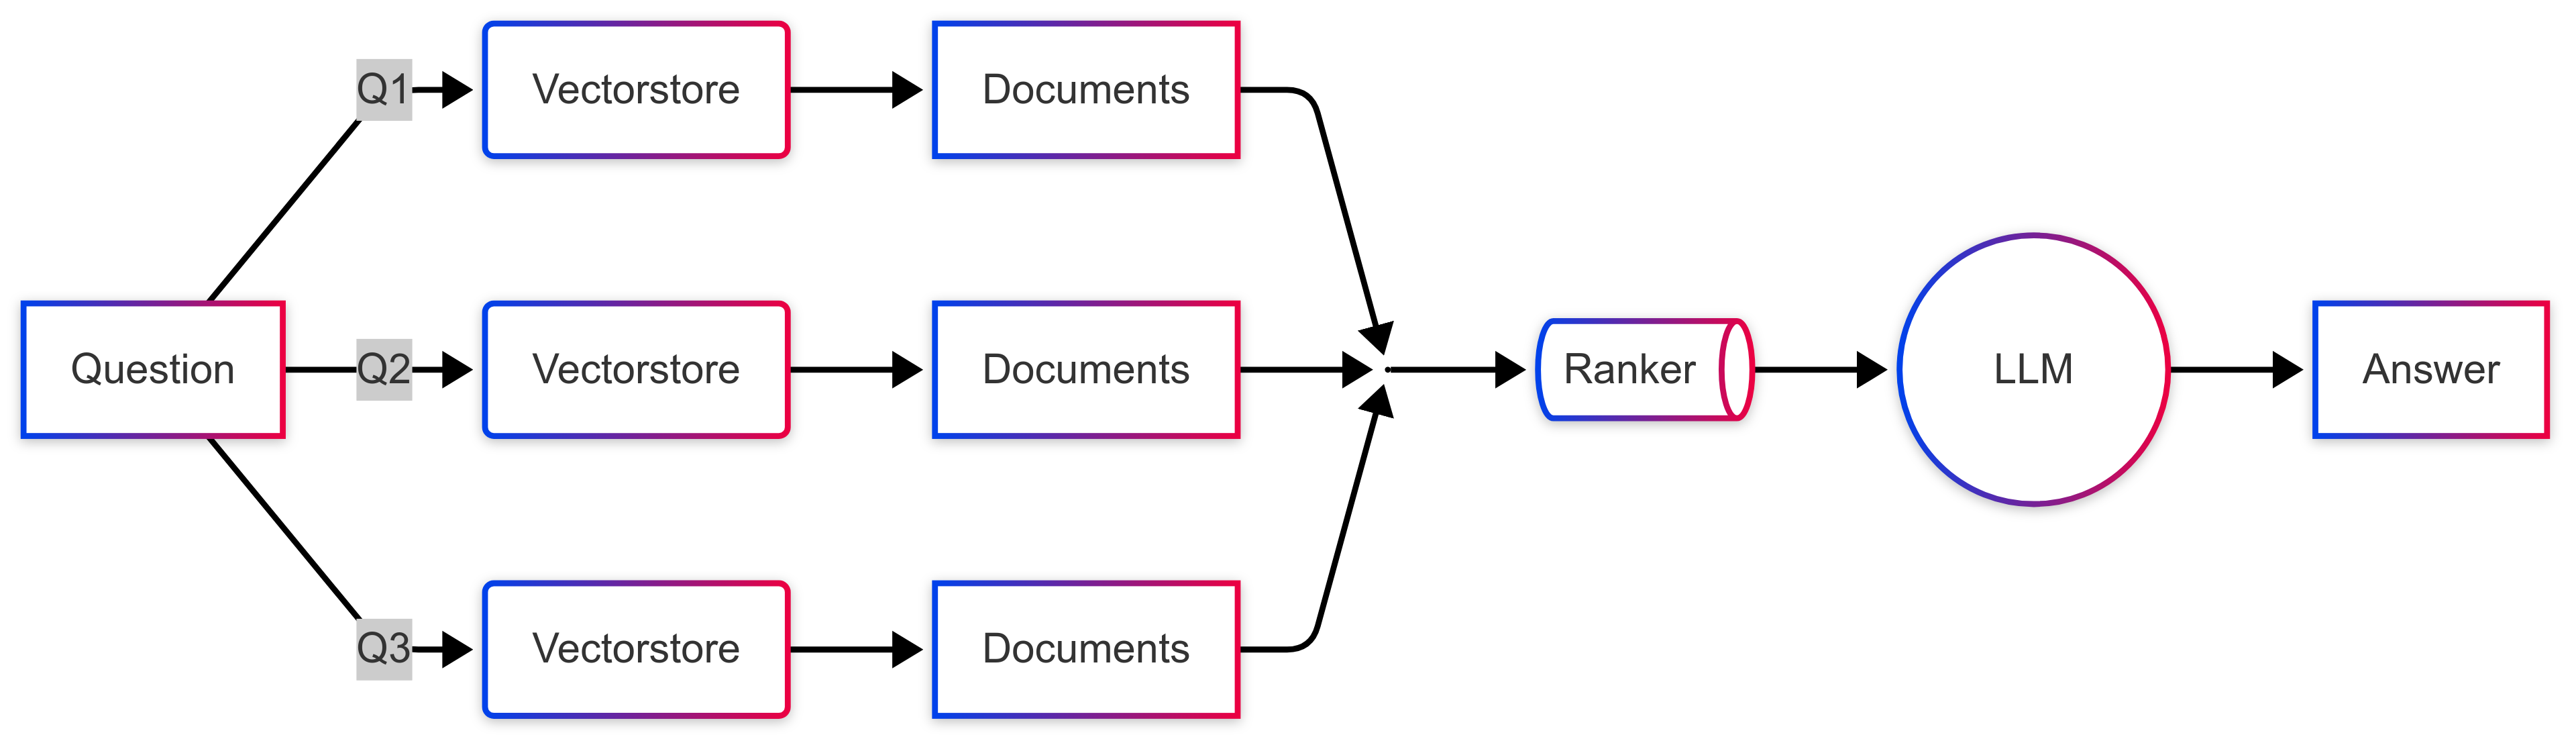

##### Pourquoi RRF ?
✅ **Fusion intelligente** : Combine les résultats de plusieurs requêtes en une seule liste ordonnée  
✅ **Robustesse** : Réduit l'impact des résultats aberrants et favorise les documents pertinents récurrents  
✅ **Pas de normalisation** : Fonctionne directement sur les rangs, sans nécessiter de normalisation des scores

##### Fonctionnement du RRF

1. **Collecte des résultats**
   ```python
   # Pour chaque variante de requête générée par multiquery_agent
   query_results = []
   for query in queries:
       docs = vectorstore.similarity_search(query, k=10)
       query_results.append(docs)
   ```

2. **Calcul des scores RRF**
   ```python
   RRF_score(document) = Σ 1/(rang + k)
   ```
   où:
   - `rang` est la position du document dans chaque liste de résultats
   - `k` est une constante (60 par défaut) qui atténue l'impact des rangs élevés
   
3. **Exemple de scoring**
   Si un document apparaît aux positions :
   - Rang 1 dans Query 1 : 1/(1 + 60) = 0.0164
   - Rang 3 dans Query 2 : 1/(3 + 60) = 0.0159
   - Rang 5 dans Query 3 : 1/(5 + 60) = 0.0154
   Son score RRF final sera : 0.0477

##### Impact sur le pipeline

- **Simplification** : Fusion de la récupération et du ré-ordonnancement en une seule étape
- **Performance** : Réduction du nombre d'opérations sur le vectorstore
- **Qualité** : Meilleure pertinence des résultats grâce à la prise en compte de multiples perspectives de recherche

In [91]:
def retrieval_agent(state: RAGState, config: RunnableConfig):
    """
    Retrieves and ranks relevant documents using FAISS with RRF ranking.
    """
    # Create or load FAISS index
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    # Step 1: Get initial results for each query variation
    # For each query, we get a ranked list of documents with similarity scores
    query_results = []
    print("\nStep 1: Initial retrieval for each query variant:")
    for i, query in enumerate(state.multiple_queries.queries):
        docs = vectorstore.similarity_search(query, k=config["configurable"].get("max_contexts", 5))
        query_results.append(docs)
        print(f"Query {i + 1}: '{query[:50]}...' retrieved {len(docs)} documents")

    # Step 2: Apply Reciprocal Rank Fusion
    # RRF score = sum across all rankings of 1/(rank + k)
    # where k is a constant that mitigates the impact of high rankings
    k = config["configurable"].get("rrf_k", 60)
    fused_scores = {}

    print("\nStep 2: RRF Scoring Details:")
    for query_index, docs in enumerate(query_results):
        print(f"\nProcessing results from Query {query_index + 1}:")

        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0

            # Calculate RRF score contribution for this document in this ranking
            rrf_contribution = 1 / (rank + k)
            fused_scores[doc_str] += rrf_contribution

            print(f"Document (chuck_id): '{doc.metadata.get('chunk_id')}'")
            print(f"  Rank in this query: {rank + 1}")
            print(f"  RRF score contribution: {rrf_contribution:.4f}")
            print(f"  Current total RRF score: {fused_scores[doc_str]:.4f}")

    # Step 3: Sort documents by their final RRF scores
    print("\nStep 3: Final Rankings:")
    sorted_docs = sorted(
        fused_scores.items(),
        key=itemgetter(1),
        reverse=True
    )

    # Print top 5 results with scores
    print("\nTop max_contexts (or 5) Documents after RRF:")
    for i, (doc_str, score) in enumerate(sorted_docs[:config["configurable"].get("max_contexts", 5)]):
        doc = loads(doc_str)
        print(f"{i + 1}. Score: {score:.4f} - '{doc.metadata.get('chunk_id')}...'")

    # Step 4: Create final retrieved_docs list with deduplication
    retrieved_docs = []
    seen_keys = set()

    for doc_str, _ in sorted_docs:
        doc = loads(doc_str)
        key = (doc.page_content, doc.metadata.get('chunk_id'))
        if key not in seen_keys:
            retrieved_docs.append(doc)
            seen_keys.add(key)

    print(f"\nFinal unique documents after deduplication: {len(retrieved_docs)}")
    return {"retrieved_docs": retrieved_docs}

In [92]:
# Graph Construction
"""
Constructs and returns the RAG processing graph.
"""
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)

# Connect nodes
graph.add_conditional_edges(
    START,
    initializer_agent
)
# graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "multiquery")
graph.add_edge("multiquery", "retrieval")
graph.add_edge("retrieval", "restitution")
graph.add_edge("restitution", END)

from langgraph.graph.state import CompiledStateGraph
executor = graph.compile()

In [93]:
def process_query(query: str, sources: Dict[str, Any], config: Any):
    """
    Processes a query using the RAG system.
    """
    result = executor.invoke(RAGState(query=query, sources=sources), config=config)

    # Format and return results
    return {
        "answer": result['answer'].answer,
        "sources": set(source.source_url for source in result['answer'].sources),
    }

In [94]:
sources = {
    "web": [
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langraph.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md",
    ]
}
query = "C'est quoi et comment fonctionne un VectorStore en LangChain?"
config = {
    "configurable": {
        "max_contexts": 3,
        "model_type": "ollama",
        "model": "llama3.2",
        "temperature": 0.3,
        "embedding_type": "ollama",
        "embedding_model": "nomic-embed-text",
        "stored_index": "./faiss_index_rag3",
        "chunk_size": 500,
        "chunk_overlap": 100,
        "rrf_k": 60
    }
}

result = process_query(query, sources, config)
print("💬 Answer:", result['answer'])
print("\n\n📚 Sources Used:")
for source in result['sources']:
    print(f"- {source}")

Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 2
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0.3
Max Retries: 3
Selected Embedding Configuration:
Embedding Type: ollama
Embedding Model: nomic-embed-text
✅ Data index loaded from cache!

Step 1: Initial retrieval for each query variant:
Query 1: 'Explain the concept and functionality of a VectorS...' retrieved 3 documents
Query 2: 'How does a VectorStore work in LangChain?...' retrieved 3 documents
Query 3: 'What is the purpose of a VectorStore in natural la...' retrieved 3 documents

Step 2: RRF Scoring Details:

Processing results from Query 1:
Document (chuck_id): '62'
  Rank in this query: 1
  RRF score contribution: 0.0167
  Current total RRF score: 0.0167
Document (chuck_id): '60'
  Rank in this query: 2
  RRF score contribution: 0.0164
  Current total RRF score: 0.0164
Document (chuck_id): '39'
  Rank in this query: 3
  RRF score contribution: 0.0161
  C

## RAG level 5 avec Query Response Decomposition

L'architecture a été enrichie avec **Query Response Decomposition (QRD)**, qui améliore la granularité et la pertinence des réponses dans le pipeline RAG.  

---

### 🏗 **Introduction à QRD**
La **décomposition des requêtes** permet de diviser une question complexe en sous-questions successives afin de mieux contextualiser et structurer la réponse. Ce procédé améliore l’alignement entre la requête et les résultats du **VectorStore**, rendant la récupération d’informations plus précise.  

---

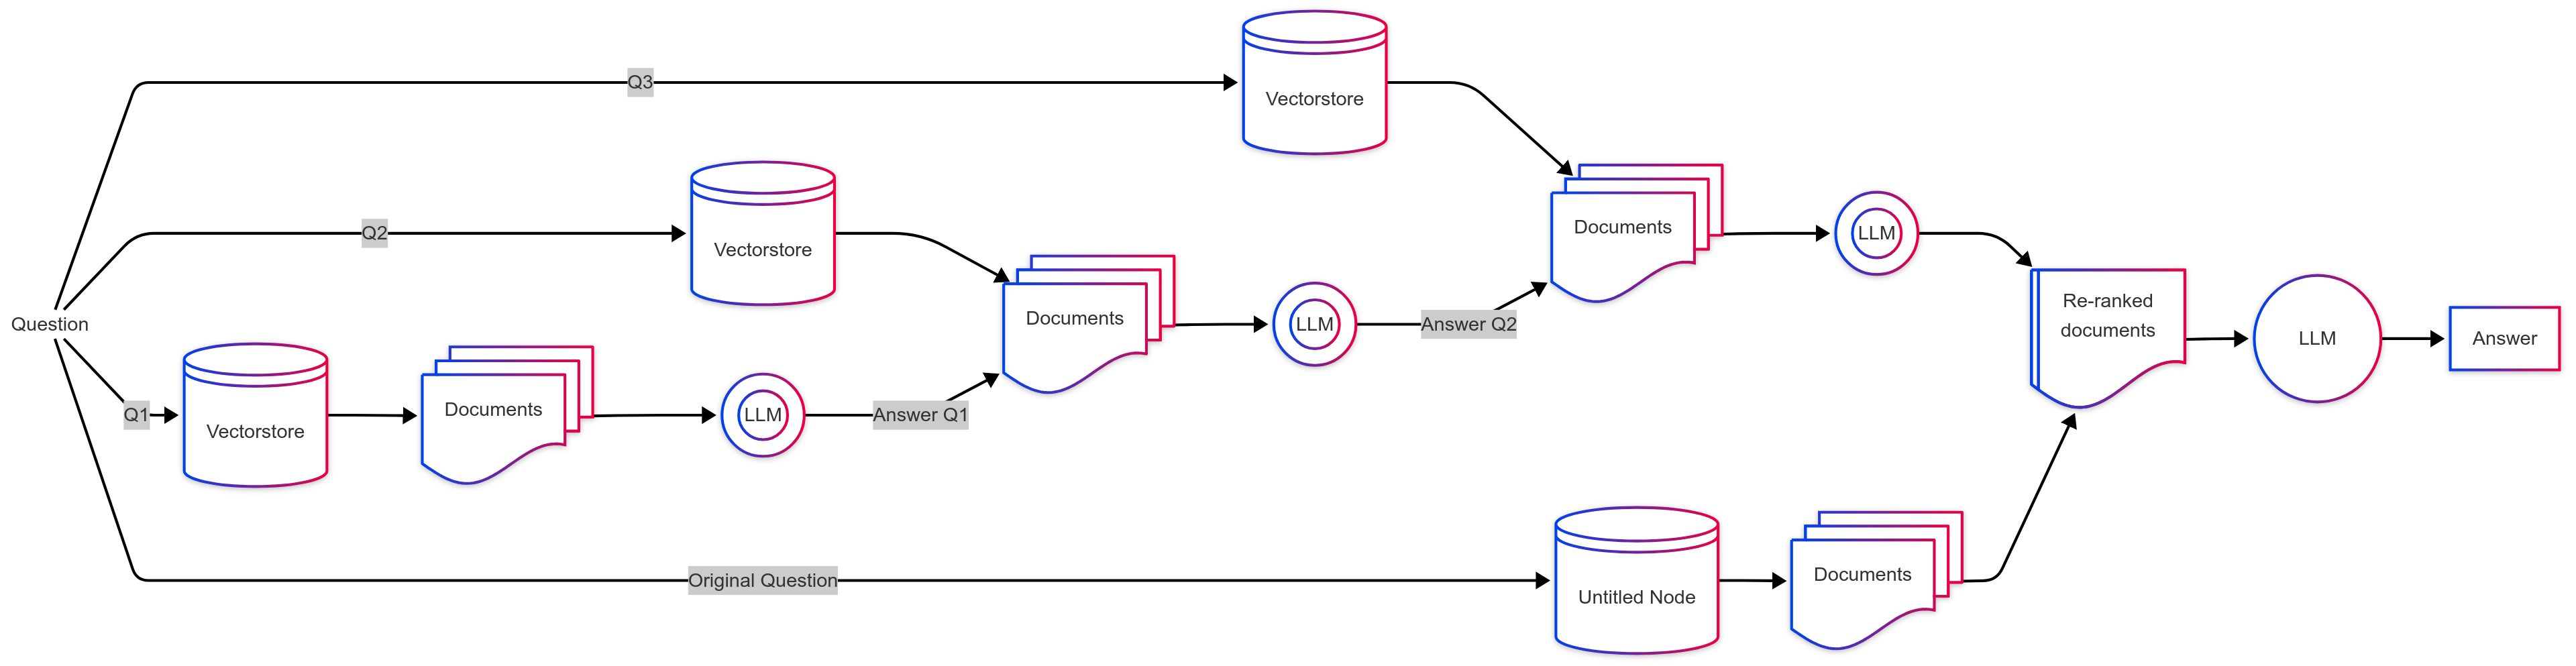

📌 **Graph de pipeline :**  

```plaintext
[Ingestion] → [MultiQuery] → [Decomposition] → [Recursive Response] → [Retrieval] → [RRF Ranking] → [Restitution]
```

💡 **Principales améliorations :**
- **Décomposition des questions** en sous-questions progressives
- **Réponses récursives** intégrant les sous-questions pour enrichir la recherche
- **Amélioration du retrieval** avec des requêtes multi-niveaux basées sur les réponses intermédiaires  

---

#### 🔍 **1. Décomposition des requêtes (Query Response Decomposition)**  

> **Objectif** : Transformer une question en une séquence logique de sous-questions autonomes pour améliorer le focus de chaque recherche.  

📌 **Exemple de décomposition** :  

🔹 **Question originale :**  
🧐 *"Comment fonctionne LangChain pour la récupération d'informations dans une architecture RAG ?"*  

🔹 **Sous-questions générées :**  
1️⃣ *"Qu'est-ce que LangChain et quel est son rôle dans l'IA générative ?"*  
2️⃣ *"Quels sont les principaux composants de LangChain utilisés pour la récupération d’informations ?"*  
3️⃣ *"Comment LangChain interagit-il avec un VectorStore pour récupérer et traiter les documents ?"*  

---

#### 🏗 **2. Réponses récursives avec maintien du contexte**  

Une fois les sous-questions générées, le **Recursive Response Agent** les traite séquentiellement en maintenant l’historique conversationnel :  

🔄 **Processus :**  
1️⃣ Extraction du contexte pour chaque sous-question  
2️⃣ Génération de réponses intermédiaires  
3️⃣ Synthèse finale en une réponse complète  

---

#### 📖 **3. Amélioration du Retrieval avec QRD & RRF**  

Le **retrieval_agent** est désormais capable d'exploiter les sous-réponses pour affiner la recherche d’informations :  

💡 **Méthodologie :**
- 🟢 Recherche basée sur **la requête principale**
- 🟢 Recherche optimisée avec **les sous-réponses** comme contexte supplémentaire
- 🟢 **Fusion RRF** des résultats pour ordonner les documents les plus pertinents  

```python
# Recherche améliorée avec réponses intermédiaires
for sub_answer in recursive_result.sub_answers:
    enhanced_query = f"{sub_answer.question} {sub_answer.answer}"
    sub_docs = vectorstore.similarity_search(
        enhanced_query,
        k=config["configurable"].get("max_contexts", 3)
    )
    all_docs.extend(sub_docs)
```

---

#### 🏆 **4. Restitution Finale : Synthèse multi-niveau**
Une fois les documents **classés et fusionnés avec RRF**, l’**assistant restitue la réponse finale en préservant la structure conversationnelle** :

📌 **Format conversationnel structuré :**
```plaintext
🧑‍💻 Human: "Comment fonctionne LangChain pour la récupération d'informations ?"
🤖 AI: "LangChain est une bibliothèque permettant d'enchaîner plusieurs étapes..."
🧑‍💻 Human: "Quels sont les principaux composants de LangChain pour la récupération ?"
🤖 AI: "Les principaux composants sont les outils de gestion de la mémoire..."
...
🧑‍💻 Human: "Synthétisez la réponse finale"
🤖 AI: "LangChain permet de récupérer des documents en exploitant..."
```

---

### 🔥 **Pourquoi cette approche ?**
✅ **Granularité améliorée** : La segmentation des requêtes évite les réponses trop larges  
✅ **Recherche plus précise** : Chaque réponse intermédiaire optimise le retrieval suivant  
✅ **Pipeline robuste & scalable** : La modularité permet d’améliorer chaque étape indépendamment  

In [2]:
import os
from operator import itemgetter
from typing import List, Optional, Dict, Literal, Any

from pydantic import BaseModel, Field
import bs4

# Set environment variable
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0"

# LangChain Imports
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma, FAISS

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.config import RunnableConfig

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langchain.load import dumps, loads

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# LangGraph Imports
from langgraph.graph import StateGraph, END, START


In [3]:
class SubQuestionAnswer(BaseModel):
    question: str = Field(description="The sub-question")
    answer: str = Field(description="Answer to the sub-question")


class RecursiveAnswer(BaseModel):
    final_answer: str = Field(description="The synthesized answer incorporating all sub-question responses")


class RecursiveOutput(BaseModel):
    final_answer: str = Field(description="The synthesized answer incorporating all sub-question responses")
    sub_answers: List[SubQuestionAnswer] = Field(
        description="List of answers to each sub-question in sequential order"
    )
    

class DecompositionOutput(BaseModel):
    sub_questions: List[str] = Field(
        description="List of sub-questions generated from the original question",
        min_items=1,
        max_items=3
    )


class ResponseOutput(BaseModel):
    answer: str = Field(description="The final comprehensive answer")

In [4]:
class MultiQueryOutput(BaseModel):
    queries: List[str] = Field(
        description="List of alternative queries generated from the original question",
        min_items=1,
        max_items=5
    )
    reasoning: str = Field(
        description="Explanation of how the alternative queries were relevant to expand the search space for the user query"
    )

In [5]:
class RAGState(BaseModel):
    query: str
    sources: Dict[str, Any] = None
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[Document]] = None
    ranked_docs: Optional[List[Document]] = None  # New field for ranked documents
    multiple_queries: Optional[MultiQueryOutput] = None
    decomposed_results: Optional[Dict[str, DecompositionOutput]] = None
    recursive_answers: Optional[Dict[str, RecursiveOutput]] = None
    answer: Optional[ResponseOutput] = None

In [6]:
def initializer_agent(state: RAGState, config: RunnableConfig) -> Literal["ingestion", "multiquery"]:
    """
    Determines the flow based on whether documents need to be loaded
    and if FAISS index exists
    """
    faiss_index_path = config["configurable"].get("stored_index")
    faiss_index_exists = os.path.exists(faiss_index_path)

    if not faiss_index_exists:
        return "ingestion"
    else:
        return "multiquery"

In [7]:
def multiquery_agent(state: RAGState, config: RunnableConfig):
    """
    Generates multiple query variations using structured output.
    """
    template = """You are an AI language model assistant. Your task is to:
    1. Generate between 3-5 different versions of the given user question
    2. Each version should provide a different perspective or approach to the original question
    3. Explain your reasoning for generating these specific variations

    Original question: {question}

    Provide your response in a structured format with:
    - A list of alternative queries
    - Your reasoning for generating these specific variations
    """

    target_llm = get_chat_model(config)

    # Initialize LLM and embeddings
    target_llm = get_chat_model(config)

    prompt = ChatPromptTemplate.from_template(template)
    structured_llm = target_llm.with_structured_output(MultiQueryOutput, method="function_calling")
    chain = prompt | structured_llm

    result = chain.invoke({
        "question": state.query
    })
    return {"multiple_queries": result}

In [8]:
def get_chat_model(config):
    model_type = config["configurable"].get("model_type", "ollama")
    model_name = config["configurable"].get("model", "llama3.2")
    model_temperature = config["configurable"].get("temperature", 0.03)
    model_max_retries = config["configurable"].get("max_retry", 3)
    
    print(f"Selected Configuration:\n"
          f"Model Type: {model_type}\n"
          f"Model Name: {model_name}\n"
          f"Temperature: {model_temperature}\n"
          f"Max Retries: {model_max_retries}")

    if model_type.lower() == "ollama":
        # Return ChatOllama if the model type is "ollama"
        return ChatOllama(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries
        )
    elif model_type.lower() == "openai":
        # Return ChatOpenAI if the model type is "openai"
        return ChatOpenAI(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")

In [9]:
def get_embeddings(config):
    model_type = config["configurable"].get("embedding_type", "ollama")
    model_name = config["configurable"].get("embedding_model", "nomic-embed_text")

    print(f"Selected Embedding Configuration:\n"
          f"Embedding Type: {model_type}\n"
          f"Embedding Model: {model_name}")
    
    if model_type.lower() == "ollama":
        return OllamaEmbeddings(
            model=model_name
        )
    elif model_type.lower() == "openai":
        return OpenAIEmbeddings(
            model=model_name
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")

In [10]:
def get_vector_store(config, target_embedding, index_name, state):
    """
    Retrieves or builds a FAISS vector store based on the provided configuration.
    
    Args:
        config (dict): Configuration dictionary containing the path to the stored index.
        target_embedding: Embedding function or model.
        index_name (str): The name of the index.
        state: An object containing the ingested documents if the index needs to be rebuilt.

    Returns:
        FAISS: The FAISS vector store instance.
    """
    stored_index_base = config["configurable"].get("stored_index")
    stored_index_type = config["configurable"].get("embedding_type")
    stored_index_model = config["configurable"].get("embedding_model")

    # La base vectorielle change avec le modèle de embedding (la dimensionnalité et le typage pourraient changer)
    stored_index_path = f"{stored_index_base}.{stored_index_type}.{stored_index_model}"

    try:
        vectorstore = FAISS.load_local(
            folder_path=stored_index_path,
            embeddings=target_embedding,
            index_name=index_name,
            allow_dangerous_deserialization=True
        )
        print("✅ Data index loaded from cache!")
    except Exception as e:
        print(f"⚠️ Failed to load index from cache.")
        print("🔄 Building the index from documents...")
        
        vectorstore = FAISS.from_documents(
            documents=state.ingested,
            embedding=target_embedding
        )
        
        vectorstore.save_local(stored_index_path, index_name=index_name)
        print("💾 Index saved locally!")

    return vectorstore

In [11]:
# Source Loader Factory
class SourceLoader:
    @staticmethod
    def get_loader(source_type: str, location: str):
        loaders = {
            "web": lambda loc: WebBaseLoader(web_paths=[loc]),
            "pdf": lambda loc: PyPDFLoader(loc),
        }

        loader = loaders.get(source_type.lower())
        if not loader:
            raise ValueError(f"Unsupported source type: {source_type}")

        return loader(location)

In [12]:
def ingestion_agent(state: RAGState, config: RunnableConfig):
    """
    Handles document ingestion from multiple sources with proper document splitting
    and metadata preservation.
    """
    all_docs = []
    total_docs = 0
    global_chunk_id = 0

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config["configurable"].get("chunk_size", 500),
        chunk_overlap=config["configurable"].get("chunk_overlap", 100)
    )

    for source_type, source_locations in state.sources.items():
        if isinstance(source_locations, str):
            source_locations = [source_locations]

        for location in source_locations:
            try:
                loader = SourceLoader.get_loader(source_type, location)
                docs = loader.load()

                for doc in docs:
                    if not hasattr(doc, 'metadata'):
                        doc.metadata = {}

                    original_metadata = {
                        "source_url": location
                    }

                    splits = text_splitter.split_text(doc.page_content)

                    for split_text in splits:
                        split_doc = Document(
                            page_content=split_text,
                            metadata={
                                **original_metadata,
                                "chunk_id": global_chunk_id
                            }
                        )
                        all_docs.append(split_doc)
                        global_chunk_id += 1
                        total_docs += 1

            except Exception as e:
                continue

    if not all_docs:
        raise ValueError("No documents were successfully loaded")

    return {
        "available_docs": total_docs,
        "ingested": all_docs
    }


In [35]:
def decomposition_agent(state: RAGState, config: RunnableConfig):
    """
    Decomposes each query from multiquery into sub-questions.
    """
    template = """You are an AI language model assistant. Your task is to:
    1. Break down the given question into sequential sub-questions
    2. Each sub-question should build upon the previous ones
    3. Design questions that progressively build understanding once answered in order
    4. **LIMIT TO 3 QUESTIONS**

    DO NOT create or use any other function types, even if the question is about function definition or any structure of any type, 
    like databases, or any other technical topic. All answer must use the DecompositionOutput function.

    Original question: {question}

    Each sub-question should be self-contained and specific. 
    """

    target_llm = get_chat_model(config)

    decomposed_results = {}

    for query in state.multiple_queries.queries:
        prompt = ChatPromptTemplate.from_template(template)
        structured_llm = target_llm.with_structured_output(DecompositionOutput, method="function_calling")
        chain = prompt | structured_llm

        decomposition = chain.invoke({
            "question": query
        })
        decomposed_results[query] = decomposition

    return {"decomposed_results": decomposed_results}

In [36]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

def recursive_response_agent(state: RAGState, config: RunnableConfig):
    """
    Processus récursif pour traiter des sous-questions en construisant un historique de conversation sans doublons.
    """
    target_llm = get_chat_model(config)
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    recursive_answers = {}

    for query, decomposition in state.decomposed_results.items():
        # Messages de base, partagés pour chaque requête
        base_messages = [
            SystemMessage(
                content="""
You are a helpful assistant that provides clear, accurate answers based on the provided context.
Build upon previous question-answer pairs to provide comprehensive responses.

DO NOT create or use any other function types, even if the question is about function definition or any structure of any type,
like databases, or any other technical topic. All responses must use the SubQuestionAnswer function.
                """
            )
        ]
        # Historique de conversation (Q/R) à ajouter une seule fois par itération
        conversation_history = []
        sub_answers = []

        # Traitement des sous-questions séquentiellement
        for sub_q in decomposition.sub_questions:
            # Récupération des documents pertinents
            docs = vectorstore.similarity_search(
                sub_q,
                k=config["configurable"].get("max_contexts", 5)
            )

            # Construction du message pour la sous-question courante
            messages = base_messages.copy()
            messages.append(SystemMessage(
                content=f"Context for the next question: {' '.join(doc.page_content for doc in docs)}"
            ))
            # Ajout de l'historique de conversation (chaque Q/R apparaît une seule fois)
            messages.extend(conversation_history)
            # Ajout de la question courante
            messages.append(HumanMessage(content=sub_q))

            # Appel du modèle avec le format structuré pour obtenir la réponse
            chain = target_llm.with_structured_output(SubQuestionAnswer, method="function_calling")
            response = chain.invoke(messages)

            # Mise à jour de l'historique de conversation avec la Q/R courante
            conversation_history.append(HumanMessage(content=sub_q))
            conversation_history.append(AIMessage(content=response.answer))
            sub_answers.append(response)

        # Construction du message final pour synthétiser la réponse complète à la requête initiale
        final_messages = base_messages.copy()
        final_messages.extend(conversation_history)
        final_messages.append(HumanMessage(
            content=f"Now provide a final comprehensive answer to the original query: {query}"
        ))
        final_response = target_llm.with_structured_output(RecursiveAnswer).invoke(final_messages)
        final_response = RecursiveOutput(final_answer=final_response.final_answer, sub_answers=sub_answers)
        recursive_answers[query] = final_response

    return {"recursive_answers": recursive_answers}

In [37]:
def retrieval_agent(state: RAGState, config: RunnableConfig):
    """
    Retrieves documents using FAISS, incorporating both multiquery and recursive answer results.
    """
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    all_docs = []

    # Get results for original queries
    for query in state.multiple_queries.queries:
        # Get documents for original query
        docs = vectorstore.similarity_search(
            query,
            k=config["configurable"].get("max_contexts", 5)
        )
        all_docs.extend(docs)

        # Get documents based on recursive answers
        if query in state.recursive_answers:
            recursive_result = state.recursive_answers[query]

            # Use sub-answers to enhance retrieval
            for sub_answer in recursive_result.sub_answers:
                enhanced_query = f"{sub_answer.question} {sub_answer.answer}"
                sub_docs = vectorstore.similarity_search(
                    enhanced_query,
                    k=config["configurable"].get("max_contexts", 3)
                )
                all_docs.extend(sub_docs)

            # Use final answer for additional context
            final_docs = vectorstore.similarity_search(
                recursive_result.final_answer,
                k=config["configurable"].get("max_contexts", 3)
            )
            all_docs.extend(final_docs)

    return {"retrieved_docs": all_docs}

In [38]:
from collections import defaultdict

def rrf_ranking_agent(state: RAGState, config: RunnableConfig):
    """
    Applies Reciprocal Rank Fusion to rank and deduplicate retrieved documents.
    """
    if not state.retrieved_docs:
        return {"ranked_docs": []}

    # Reciprocal Rank Fusion
    scored_docs = defaultdict(list)

    for i, doc in enumerate(state.retrieved_docs):
        doc_id = doc.metadata.get('chunk_id', str(i))
        rank = i + 1
        scored_docs[doc_id].append(1 / (config["configurable"].get("k_rrf", 60) + rank))

    # Aggregate RRF scores
    final_scores = {
        doc_id: sum(scores) for doc_id, scores in scored_docs.items()
    }

    # Sort documents by final RRF score
    ranked_docs = sorted(
        [(doc_id, score) for doc_id, score in final_scores.items()],
        key=lambda x: x[1],
        reverse=True
    )

    # Get unique documents in ranked order
    seen_ids = set()
    unique_ranked_docs = []

    for doc in state.retrieved_docs:
        doc_id = doc.metadata.get('chunk_id', '')
        if doc_id in [d[0] for d in ranked_docs] and doc_id not in seen_ids:
            unique_ranked_docs.append(doc)
            seen_ids.add(doc_id)

    # Take top K documents
    top_k = config["configurable"].get("max_contexts", 5)
    ranked_docs = unique_ranked_docs[:top_k]

    return {"ranked_docs": ranked_docs}

In [39]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

def restitution_agent(state: RAGState, config: RunnableConfig):
    """
    Generates the final answer using ranked documents and recursive answers while preserving the conversational structure.
    """
    target_llm = get_chat_model(config)

    messages = [
        SystemMessage(content="""You are a helpful assistant that provides comprehensive answers.
        Use the context from ranked documents and previous recursive answers to provide a detailed response.
        Make sure to synthesize information from all sources coherently while maintaining a structured conversational flow.""")
    ]

    # Add ranked documents as context
    if state.ranked_docs:
        context = "\n".join(doc.page_content for doc in state.ranked_docs)
        messages.append(SystemMessage(content=f"Context from ranked documents:\n{context}"))

    # Add recursive answers as a conversation flow
    if state.recursive_answers:
        for query, result in state.recursive_answers.items():
            messages.append(HumanMessage(content=query))  # Original query
            messages.append(AIMessage(content=result.final_answer))  # Final synthesized answer

            # Include sub-questions and their answers in a conversational manner
            for qa in result.sub_answers:
                messages.append(HumanMessage(content=qa.question))
                messages.append(AIMessage(content=qa.answer))

    # Add the original query again for final synthesis
    messages.append(HumanMessage(content=state.query))

    # Generate the final structured response
    chain = target_llm.with_structured_output(ResponseOutput, method="function_calling")
    response = chain.invoke(messages)

    return {"answer": response}

In [40]:
# Graph Construction
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("decomposition", decomposition_agent)
graph.add_node("recursive_response", recursive_response_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("rrf_ranking", rrf_ranking_agent)  # New node
graph.add_node("restitution", restitution_agent)

# Connect nodes
graph.add_conditional_edges(
    START,
    initializer_agent
)
graph.add_edge("ingestion", "multiquery")
graph.add_edge("multiquery", "decomposition")
graph.add_edge("decomposition", "recursive_response")
graph.add_edge("recursive_response", "retrieval")
graph.add_edge("retrieval", "rrf_ranking")
graph.add_edge("rrf_ranking", "restitution")
graph.add_edge("restitution", END)

executor = graph.compile()

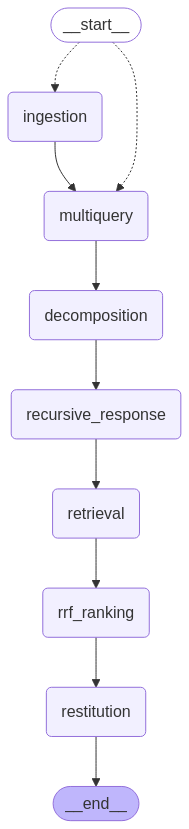

In [41]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [42]:
def process_query(query: str, sources: Dict[str, Any], config: Any):
    """
    Processes a query using the RAG system.
    """
    result = executor.invoke(RAGState(query=query, sources=sources), config=config)

    # Format and return results
    return result['answer']

In [44]:
sources = {
    "web": [
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langraph.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md",
    ]
}
query = "C'est quoi et comment fonctionne un VectorStore en LangChain?"
config = {
    "configurable": {
        "max_contexts": 3,
        "max_retry": 5,
        # "model_type": "openai",
        # "model": "gpt-4o",
        "model_type": "ollama",
        "model": "llama3.2",
        "temperature": 0,
        "embedding_type": "ollama",
        "embedding_model": "nomic-embed-text",
        "stored_index": "./faiss_index_rag5",
        "chunk_size": 500,
        "chunk_overlap": 100,
        "rrf_k": 60
    }
}
result = process_query(query, sources, config)
print("💬 Answer:", result.answer)

Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 5
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 5
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 5
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 5
Selected Embedding Configuration:
Embedding Type: ollama
Embedding Model: nomic-embed-text
✅ Data index loaded from cache!
Selected Embedding Configuration:
Embedding Type: ollama
Embedding Model: nomic-embed-text
✅ Data index loaded from cache!
Selected Configuration:
Model Type: ollama
Model Name: llama3.2
Temperature: 0
Max Retries: 5
💬 Answer: Un VectorStore est une base de données vectorielle qui stocke et indexe des documents sous forme de vecteurs densément représentés. Il permet des recherches efficaces et rapides sur le contenu des documents, ce qui est particulièrement utile dans les applications de traitem

---

# Partie mise en situation

Ici vous pouvez créer vos propres implementation à partir des exemples données.  

Pour chanque challange, des implementations de l'allgorithme de base vous sera fournis et explicité et le challange sera de finaliser cette ebauche dans une chaîne complète et fonctionnelle.  

Encore une fois, n'oubliez pas que le niveau d'intélligence de votre LLM sera un élément majeure de votre réussite: testez plusieurs modèles, tester diverses API et choississez la meilleur pour chaque usage.  

Dernier conseil, **lorsque que vous pouvez utiliser une approche deterministe** (du code) au lieu du LLM, n'hésitez pas à le faire: les LLM ne sont pas fait pour être utilisés comme des solutions _"one-size-fits-all"_ et spécialement les modèles souvrains (en local) avec des paramètres limités ont tendence à halluciner et perdre les instructions au fur et à mésure que le prompt se complexifie ou se rallonge: alors, n'allez pas trop lui en démander et ça se passera bien!

**Pratiquez et bon courage**

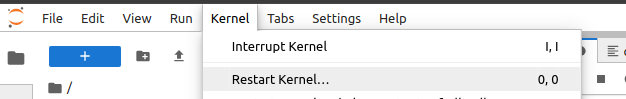

**Restart le kernel ici** pour permettre avoir un environnment propre de toute exécution précédente.

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from the custom file
load_dotenv("config.env")

True

# Les optimisations et améliorations

Dan ce chapitre, des implementation de techniques avancées vous sont expliquées et partiellement implementées.  
En raison de la complexité de ces rêquetes, il est conseillé d'utiliser des LLM hébérgés puisque l'intelligence limitée des modèles locaux risquerait de nuire à vos résultats mais vous êtes **bien sûr** encouragés à tester par vous-même et constater les résultats.



## Activation de LogProb  
LogProb représente les probabilités logarithmiques attribuées par le modèle aux tokens prédits. Un token est une unité de texte individuelle, comme un mot, un caractère ou une partie de mot. La probabilité indique la confiance du modèle dans la prédiction de chaque token.  

#### Cas d'utilisation :  
LogProb est utile pour évaluer la confiance du modèle dans ses prédictions, déboguer des problèmes et optimiser les invites (prompts). En analysant les données LogProb, on peut comprendre pourquoi le modèle a sélectionné certains tokens.  

#### Précaution :  
L'activation de LogProb augmente la taille des données de réponse, ce qui peut affecter la vitesse et le coût de l'API. Il est recommandé de l'activer uniquement lorsque cela est nécessaire.  

In [2]:
from langchain_openai import ChatOpenAI

# Initialisation du modèle avec LogProb activé
llm_with_logprob = ChatOpenAI(model="gpt-3.5-turbo-0125").bind(logprobs=True)

# Contenu de la requête
question = "Quelle est la capitale de l'Inde ?"

# Exécution de la requête
response = llm_with_logprob.invoke(question)

In [3]:
# Affichage des métadonnées de la réponse
display(response.response_metadata)

{'token_usage': {'completion_tokens': 13,
  'prompt_tokens': 19,
  'total_tokens': 32,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-3.5-turbo-0125',
 'system_fingerprint': None,
 'finish_reason': 'stop',
 'logprobs': {'content': [{'token': 'La',
    'bytes': [76, 97],
    'logprob': -0.008886012,
    'top_logprobs': []},
   {'token': ' capit',
    'bytes': [32, 99, 97, 112, 105, 116],
    'logprob': -0.0001472836,
    'top_logprobs': []},
   {'token': 'ale',
    'bytes': [97, 108, 101],
    'logprob': -7.107425e-06,
    'top_logprobs': []},
   {'token': ' de',
    'bytes': [32, 100, 101],
    'logprob': -1.6240566e-06,
    'top_logprobs': []},
   {'token': ' l',
    'bytes': [32, 108],
    'logprob': -3.7697225e-06,
    'top_logprobs': []},
   {'token': "'",
    'bytes': [39],
    'logprob': -4.

## Le Multi-Modale

La multi-modalité permet à un modèle d’intelligence artificielle de traiter plusieurs types de données simultanément, comme du texte, des images, de l’audio ou encore des vidéos. Cette capacité améliore la compréhension du contexte en combinant différentes sources d’informations.

### **Cas d'utilisation :**  
- **Analyse d’images et de texte** : Extraction d’informations pertinentes d’une image en fonction d’une requête textuelle.  
- **Génération d’explications visuelles** : Description d’images ou aide à la reconnaissance d’objets.  
- **Interactions avancées** : Fusion des entrées textuelles et visuelles pour des applications comme les assistants intelligents, la réalité augmentée ou la robotique.  
- **Accessibilité** : Amélioration des outils d’accessibilité, comme la description vocale d’images pour les malvoyants.  

### **Précaution :**  
L’activation de la multi-modalité peut nécessiter davantage de puissance de calcul et augmenter le temps de réponse du modèle. De plus, le traitement de certaines données (ex. images haute résolution, fichiers audio longs) peut être limité par la capacité de l’API ou des modèles utilisés. Il est recommandé d’optimiser les entrées pour équilibrer performance et précision.  

In [4]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image

from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

In [5]:
def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="BMP")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]

In [6]:
llm = ChatOllama(model="granite3.2-vision", temperature=0)

In [7]:
chain = prompt_func | llm | StrOutputParser()

In [8]:
query_chain = chain.invoke(
    {"text": "What is the color of the floating baloon?", "image": convert_to_base64(Image.open("demo1.webp"))}
)
print(query_chain)


Red and white


In [9]:
query_chain = chain.invoke(
    {"text": "Extract the table of data without the total", "image": convert_to_base64(Image.open("demo2.png"))}
)
print(query_chain)


| Article | Quantité | Coût / unité | Coût total |
|---|---|---|---|
| Article 1 | 5 | 245,90 € | 1229,50 € |
| Article 2 | 65 | 26,75 € | 1738,75 € |
| Article 3 | 32 | 12,00 € | 384,00 € |
| Article 4 | 8 | 68,30 € | 546,40 € |
| Article 5 | 0 | 45,00 € | 0,00 € |
| Article 6 | 150 | 8,61 € | 1291,50 € |
| Article 7 | 12 | 478,00 € | 5736,00 € |
| Article 8 | 90 | 25,10 € | 2259,00 € |
| Article 9 | 400 | 2,37 € | 948,00 € |
| Article 10 | 22 | 74,50 € | 1639,00 € |


## Le caching

Ce tutoriel présente **InMemoryCache**, un mécanisme de mise en cache permettant d'améliorer les performances des applications utilisant **LangChain**.  

**InMemoryCache** stocke temporairement les résultats des requêtes en mémoire, réduisant ainsi la latence et évitant les recalculs inutiles. Cela est particulièrement utile pour les modèles coûteux en ressources ou les interactions répétitives avec une base de connaissances.  

#### **Cas d'utilisation :**  
- **Optimisation des performances** : Accélération des requêtes en évitant des appels redondants aux modèles d’IA.  
- **Réduction des coûts** : Moins de requêtes vers des services externes payants grâce à la mise en cache.  
- **Amélioration de la réactivité** : Temps de réponse plus rapides pour des conversations interactives ou des applications en temps réel.  

#### **Précaution :**  
La mise en cache en mémoire étant volatile, les données stockées disparaissent en cas de redémarrage du programme. Pour un cache persistant, il est recommandé d’utiliser une solution comme **Redis** ou **SQLite**.  

In [10]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.globals import set_llm_cache
from langchain_core.caches import InMemoryCache

In [11]:
# Create model
llm = ChatOllama(model="llama3.2")

# Generate prompt
prompt = PromptTemplate.from_template(
    "Tell me all about the {country} in about 250 characters"
)

# Create chain
chain = prompt | llm

In [12]:
# Set InMemoryCache
set_llm_cache(InMemoryCache())

In [13]:
%%time
# Invoke chain
response = chain.invoke({"country": "Italy"})
print(response.content)

Italy is a Mediterranean country known for its rich history, art, architecture, fashion, and delicious cuisine. Home to Rome's Colosseum, Venice's canals, Florence's Uffizi Gallery, and Tuscany's vineyards. Famous dishes include pasta, pizza, and gelato. With a population of around 60 million, Italy is the 25th most populous country in the world.
CPU times: user 41.5 ms, sys: 2.54 ms, total: 44.1 ms
Wall time: 3.91 s


In [14]:
%%time
# Invoke chain
response = chain.invoke({"country": "Italy"})
print(response.content)

Italy is a Mediterranean country known for its rich history, art, architecture, fashion, and delicious cuisine. Home to Rome's Colosseum, Venice's canals, Florence's Uffizi Gallery, and Tuscany's vineyards. Famous dishes include pasta, pizza, and gelato. With a population of around 60 million, Italy is the 25th most populous country in the world.
CPU times: user 5.06 ms, sys: 242 μs, total: 5.3 ms
Wall time: 4.5 ms


## Résumé de Conversation avec ConversationSummaryMemory

ConversationSummaryMemory optimise l'utilisation de la mémoire en condensant le contenu des échanges, facilitant ainsi la gestion efficace des conversations longues.

Dans ce tutoriel, nous allons démontrer comment implémenter la fonctionnalité de résumé de conversation en utilisant ConversationSummaryMemory de LangChain.

Ce type de mémoire génère un **résumé de la conversation au fil du temps**, ce qui permet de compresser les informations conversationnelles à mesure que l’échange progresse: **ConversationSummaryMemory** résume continuellement la conversation et stocke le résumé actuel en mémoire.  

Cette mémoire peut ensuite être utilisée pour insérer l’historique résumé dans des **prompts** ou des **chaînes de traitement**.  

Elle est particulièrement utile pour les **conversations longues**, où conserver l’intégralité de l’historique dans le prompt consommerait trop de tokens.  

In [15]:
from langchain.memory import ConversationSummaryMemory
from langchain_ollama import ChatOllama

In [ ]:
memory = ConversationSummaryMemory(
    llm=ChatOllama(model="llama3.2", temperature=0.03), return_messages=True
)

In [17]:
memory.save_context(
    inputs={"human": "Quels programmes de formation propose la Blockchain Business School ?"},
    outputs={
        "ai": "La Blockchain Business School propose plusieurs programmes de formation, notamment :\n\n- **The Original - Tech Lead** : Formation de 3 mois visant à devenir un professionnel du Web3 en tant que Tech Lead blockchain.\n- **The Original - Product Manager** : Formation de 3 mois pour devenir Product Manager spécialisé en Web3.\n- **DeFi** : Programme de 12 semaines pour maîtriser la finance décentralisée.\n- **Intelligence Artificielle** : Formation de 8 semaines pour comprendre et utiliser l'intelligence artificielle.\n- **Utiliser et monétiser les NFTs** : Programme de 2 mois sur la création et la commercialisation de NFTs.\n- **À la découverte du Web3** : Formation de 33 heures pour découvrir l'univers du Web3 et son application en entreprise."
    },
)
memory.save_context(
    inputs={"human": "La BBS propose-t-elle des formations certifiantes ?"},
    outputs={
        "ai": "Oui, la Blockchain Business School propose des formations certifiantes. Par exemple, la licence blockchain en ligne est une formation universitaire permettant de devenir développeur blockchain certifié en un an. De plus, le mastère blockchain certifiant prépare aux métiers experts de la blockchain en six mois."
    },
)
memory.save_context(
    inputs={"human": "Quelles sont les modalités des formations à la BBS ?"},
    outputs={
        "ai": "Les formations à la Blockchain Business School sont flexibles et s'adaptent aux besoins des apprenants. Elles sont proposées en formats hybride ou 100% en ligne, avec des sessions en présentiel ou en visioconférence. Les programmes sont conçus pour être suivis en parallèle d'une activité professionnelle, avec des rythmes de 6 à 8 heures par semaine sur des périodes de 3 mois."
    },
)
memory.save_context(
    inputs={"human": "La BBS offre-t-elle des programmes en partenariat avec d'autres institutions ?"},
    outputs={
        "ai": "Oui, la Blockchain Business School collabore avec des institutions telles que la NFT Factory pour proposer des formations spécialisées. Par exemple, des modules comme 'Introduction au Web3', 'Introduction au Développement Blockchain', 'DeFi', 'NFT et Metavers' et 'Tokenomics' sont disponibles en partenariat avec la NFT Factory."
    },
)
memory.save_context(
    inputs={"human": "Quels sont les avantages de suivre une formation à la Blockchain Business School ?"},
    outputs={
        "ai": "Suivre une formation à la Blockchain Business School offre plusieurs avantages :\n\n- **Expertise spécialisée** : Les programmes sont conçus par des professionnels du secteur, assurant une formation de qualité.\n- **Flexibilité** : Les formations s'adaptent aux emplois du temps des apprenants, avec des options en ligne ou hybrides.\n- **Certifications reconnues** : Les formations sont certifiantes, augmentant la valeur sur le marché de l'emploi.\n- **Réseau professionnel** : Les partenariats avec des institutions comme la NFT Factory offrent des opportunités de networking et d'immersion dans l'écosystème blockchain."
    },
)


In [18]:
print(memory.load_memory_variables({})["history"])

[SystemMessage(content='Here is the updated text:\n\nThe human asks about the benefits of following a formation at Blockchain Business School for professionals, to which the AI responds that they offer several advantages, including acquiring specific blockchain skills, developing their professional network and launching themselves into a rapidly growing market. The programs are designed to be flexible and adaptable to the needs of professionals, with sessions in person or via video conference to facilitate collaboration with partners and clients.\n\nThe human then asks about the partnerships offered by Blockchain Business School, to which the AI responds that they collaborate with institutions such as NFT Factory to offer specialized training programs. For example, modules like "Introduction to Web3", "Introduction to Blockchain Development", "DeFi", "NFT and Metavers" and "Tokenomics" are available in partnership with NFT Factory.\n\nThe human then asks about the advantages of followi

## **Segmentation de texte**  

La segmentation de texte est une étape essentielle du prétraitement en **Traitement du Langage Naturel (NLP)**. Ce tutoriel explore différentes méthodes et outils de segmentation, en mettant en avant leurs avantages, inconvénients et cas d’utilisation appropriés.  

**Segmentation basée sur les phrases**  

- **spaCy** : Segmentation de texte exploitant des capacités avancées de traitement linguistique (sujet, verbe, complément). Il s’appuie sur des modèles pré-entraînés et des règles spécifiques aux langues pour identifier les limites des phrases avec précision.  
- **SentenceTransformers** : Segmente le texte tout en maintenant la cohérence sémantique. Il permet de découper un texte en unités ayant du sens tout en préservant les relations entre les idées, ce qui est particulièrement utile pour les tâches de résumé et de génération de texte.  
- **SemanticChunker** : Utilisé principalement dans les applications nécessitant une compréhension fine du contexte, il segmente le texte en unités sémantiques plutôt qu’en phrases strictes. Il est souvent employé dans des tâches comme l’extraction d’informations ou le résumé intelligent.  

**Segmentation basée sur les tokens**  

- **nltk.tokenize** : Fournit plusieurs méthodes de tokenisation, y compris la segmentation en mots et en phrases. C’est un outil simple mais efficace pour le prétraitement des données textuelles.  
- **BERT Tokenizer** : Utilisé dans les modèles de type Transformer, il segmente le texte en sous-unités (subwords) pour mieux gérer les mots inconnus et les variations morphologiques.  
- **GPT Tokenizer** : Fonctionne selon un modèle de compression où les mots courants sont conservés en entier et les mots rares sont décomposés en sous-mots.  

**Segmentation par taille ou heuristiques**  

- **Fixed-Length Segmentation** : Découpe le texte en segments de taille fixe, indépendamment du sens ou de la syntaxe. Méthode rapide mais souvent imprécise.  
- **Sliding Window** : Utilise une fenêtre mobile pour capturer le contexte environnant des segments, ce qui permet d’améliorer la fluidité dans certaines applications.  
- **RecursiveChunking** : Une méthode adaptative qui segmente le texte de manière récursive en fonction de critères spécifiques, comme la longueur des phrases ou la structure syntaxique.  

**Applications et cas d’usage**  

- **Chatbots et assistants virtuels** : Assurent une compréhension fluide des requêtes en segmentant efficacement le texte utilisateur.  
- **Analyse de sentiment** : La segmentation précise des avis et commentaires permet d’obtenir des analyses plus fines.  
- **Résumé automatique** : Permet de générer des résumés cohérents en identifiant les unités d’information clés.  
- **Traduction automatique** : Améliore la qualité des traductions en segmentant les textes en unités linguistiques appropriées.  

En combinant ces différentes approches en fonction des besoins spécifiques, il est possible d’optimiser le prétraitement du texte pour diverses applications en NLP.

### Utilisation de **spaCy**, une bibliothèque Open-Source pour le NLP  

**spaCy** est une bibliothèque **open-source** dédiée au **Traitement du Langage Naturel (NLP)**, écrite en **Python** et **Cython**. Elle est conçue pour être rapide, efficace et adaptée aux applications de production. Grâce à son architecture optimisée, elle est largement utilisée dans des domaines tels que l'analyse de texte, l'extraction d'informations et le développement d'assistants virtuels.  

#### **Caractéristiques principales de spaCy**  

- **Segmentation de texte** : Découpage du texte en phrases et en tokens en respectant les règles linguistiques et la ponctuation.  
- **Analyse syntaxique** : Identification des relations grammaticales entre les mots via un arbre de dépendances.  
- **Reconnaissance d’entités nommées (NER)** : Extraction automatique des entités comme les noms propres, les dates, les organisations, les lieux et d'autres catégories personnalisables.  
- **Lemmatisation** : Conversion des mots en leur forme canonique pour une meilleure analyse sémantique.  
- **Modèles pré-entraînés** : Disponibles pour plusieurs langues, allant de versions légères pour des applications rapides à des modèles avancés pour des analyses plus précises.  
- **Vectorisation des mots (Word Vectors)** : Intégration de modèles de plongement lexical permettant des comparaisons sémantiques entre mots et phrases.  
- **Pipeline NLP personnalisable** : Possibilité d’ajouter des composants spécifiques pour adapter spaCy à des besoins particuliers.  

#### **Avantages de spaCy**  

✅ **Optimisé pour la production** : Plus rapide et plus léger que d'autres bibliothèques comme NLTK, avec une gestion efficace de la mémoire.  
✅ **Facilité d'utilisation** : Interface intuitive avec des modèles pré-entraînés immédiatement exploitables.  
✅ **Extensibilité** : Possibilité d’ajouter des modèles personnalisés et de modifier le pipeline NLP.  
✅ **Interopérabilité** : Compatible avec d'autres outils NLP tels que TensorFlow, PyTorch et Hugging Face Transformers.  

#### **Cas d’utilisation courants**  

- **Analyse de texte et extraction d'informations** (journalisme, veille stratégique, analyse d’opinion).  
- **Développement de chatbots et assistants virtuels** (compréhension et génération de texte).  
- **Systèmes de recommandation et analyse des avis clients** (traitement des commentaires et feedbacks).  
- **Traduction et résumé automatique** (segmentation et compréhension du texte pour les modèles de génération).  

In [13]:
!python -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.8.4) =================
ℹ spaCy installation:
/home/martino/miniconda3/envs/jupyterlabs/lib/python3.12/site-packages/spacy

NAME              SPACY            VERSION                            
fr_core_news_sm   >=3.8.0,<3.9.0   3.8.0   ✔



In [3]:
import os
import spacy

os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0"
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_text_splitters import SpacyTextSplitter

In [12]:
# Charger un modèle pré-entraîné en français
nlp = spacy.load("fr_core_news_sm")

# Texte d'exemple
texte = "Emmanuel Macron est le président de la France depuis 2017. Il a étudié à l'École nationale d'administration."

# Traitement du texte avec spaCy
doc = nlp(texte)

# Affichage des tokens et de leurs propriétés
print("### Analyse des tokens ###")
for token in doc:
    print(f"Texte: {token.text}\tLemme: {token.lemma_}\tPOS: {token.pos_}\tDépendance: {token.dep_}")

# Affichage des entités nommées
print("\n### Entités nommées détectées ###")
for ent in doc.ents:
    print(f"Texte: {ent.text}\tType: {ent.label_}")

# Affichage des relations syntaxiques
print("\n### Analyse des dépendances syntaxiques ###")
for token in doc:
    print(f"Mot: {token.text}\tDépendance: {token.dep_}\tGouverneur: {token.head.text}")

# Détection des phrases
print("\n### Segmentation des phrases ###")
for sent in doc.sents:
    print(f"- {sent.text}")


### Analyse des tokens ###
Texte: Emmanuel	Lemme: Emmanuel	POS: PROPN	Dépendance: nsubj
Texte: Macron	Lemme: Macron	POS: PROPN	Dépendance: flat:name
Texte: est	Lemme: être	POS: AUX	Dépendance: cop
Texte: le	Lemme: le	POS: DET	Dépendance: det
Texte: président	Lemme: président	POS: NOUN	Dépendance: ROOT
Texte: de	Lemme: de	POS: ADP	Dépendance: case
Texte: la	Lemme: le	POS: DET	Dépendance: det
Texte: France	Lemme: France	POS: PROPN	Dépendance: nmod
Texte: depuis	Lemme: depuis	POS: ADP	Dépendance: case
Texte: 2017	Lemme: 2017	POS: NUM	Dépendance: nmod
Texte: .	Lemme: .	POS: PUNCT	Dépendance: punct
Texte: Il	Lemme: il	POS: PRON	Dépendance: nsubj
Texte: a	Lemme: avoir	POS: AUX	Dépendance: aux:tense
Texte: étudié	Lemme: étudier	POS: VERB	Dépendance: ROOT
Texte: à	Lemme: à	POS: ADP	Dépendance: case
Texte: l'	Lemme: le	POS: DET	Dépendance: det
Texte: École	Lemme: école	POS: NOUN	Dépendance: obl:arg
Texte: nationale	Lemme: national	POS: ADJ	Dépendance: amod
Texte: d'	Lemme: de	POS: ADP	Dépendanc

In [4]:
# A choisir en fonction de la langue ici: https://spacy.io/models
text_splitter = SpacyTextSplitter(
    pipeline="fr_core_news_sm",
    chunk_size=400,
    chunk_overlap=100
)

In [5]:
loader = WebBaseLoader(
    web_paths=[
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langraph.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md",
    ]
)
docs = loader.load()

In [6]:
splits = text_splitter.split_documents(docs)

Created a chunk of size 508, which is longer than the specified 400
Created a chunk of size 500, which is longer than the specified 400


In [7]:
splits[3:7]

[Document(metadata={'source': 'https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md'}, page_content='Un autre problème est que ces modèles ont du mal à expliquer leurs décisions (donner des preuves ou "provenance" de leurs réponses) et à mettre à jour les connaissances qu\'ils contiennent.\n\nPour surmonter ces limites, des chercheurs ont exploré des modèles qui combinent deux types de mémoire : une mémoire paramétrique (stockée dans les paramètres du modèle, comme un modèle de langage classique) et une mémoire non paramétrique (une base de données externe, comme Wikipédia, que le modèle peut interroger).'),
 Document(metadata={'source': 'https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md'}, page_content='Ce type de modèle est appelé "RAG" (Retrieval-Augmented Generation).\n\n\n\nIls ont expérimenté deux versions de ces modèles RAG :\n\nl\'une où le modèle utilise les mêmes

### **Utilisation de SentenceTransformers**  

**SentenceTransformersTokenTextSplitter** est un outil de segmentation de texte conçu spécifiquement pour les modèles **Sentence-Transformers**.  

Son objectif principal est de découper un texte en segments adaptés à la **fenêtre de tokens** du modèle utilisé, tout en **préservant la cohérence sémantique**. Cela permet d’assurer une bonne performance des modèles **BERT-based**, tout en minimisant la perte d’informations entre les segments.  

#### **Pourquoi utiliser SentenceTransformersTokenTextSplitter ?**  
✅ **Optimisé pour les modèles Sentence-Transformers** : Compatible avec des architectures comme **BERT, RoBERTa, DistilBERT**, etc.  
✅ **Respect des limites de tokens** : Chaque segment s’adapte à la longueur maximale que le modèle peut traiter.  
✅ **Préservation du contexte** : Contrairement aux segmentations naïves, cette approche tente de découper le texte en unités qui **ont du sens** plutôt qu’en simples morceaux arbitraires.  
✅ **Idéal pour les tâches NLP avancées** : Convient aux tâches nécessitant une **compréhension du contexte** comme l’analyse de sentiment, le résumé de texte et la recherche sémantique.  

#### **Quelque détail technique**
🚀 **Le modèle Sentence-Transformers utilisé** : *all-MiniLM-L6-v2*, un modèle léger et efficace.  
📏 **Segmentation respectant la fenêtre de tokens** : Le texte est découpé en segments adaptés sans couper les phrases de manière brutale.  
🔄 **Overlap des segments (recouvrement)** : Un chevauchement de **50 tokens** permet de maintenir la continuité du contexte.  

#### **Quand utiliser SentenceTransformersTokenTextSplitter ?**  

🔹 **Recherche sémantique** : Lorsqu'un texte long doit être indexé pour des requêtes similaires.  
🔹 **Chatbots intelligents** : Pour conserver la fluidité des réponses en segmentant des documents longs.  
🔹 **Résumé automatique** : Pour découper un texte en unités digestibles avant un résumé.  
🔹 **Traduction et génération de texte** : Pour travailler sur des segments de taille adaptée sans perdre de sens.  

In [13]:
from langchain_text_splitters import SentenceTransformersTokenTextSplitter

In [14]:
splitter = SentenceTransformersTokenTextSplitter(chunk_size=200, chunk_overlap=50)

In [15]:
splits = text_splitter.split_documents(docs)

Created a chunk of size 508, which is longer than the specified 400
Created a chunk of size 500, which is longer than the specified 400


In [16]:
splits[3:7]

[Document(metadata={'source': 'https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md'}, page_content='Un autre problème est que ces modèles ont du mal à expliquer leurs décisions (donner des preuves ou "provenance" de leurs réponses) et à mettre à jour les connaissances qu\'ils contiennent.\n\nPour surmonter ces limites, des chercheurs ont exploré des modèles qui combinent deux types de mémoire : une mémoire paramétrique (stockée dans les paramètres du modèle, comme un modèle de langage classique) et une mémoire non paramétrique (une base de données externe, comme Wikipédia, que le modèle peut interroger).'),
 Document(metadata={'source': 'https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md'}, page_content='Ce type de modèle est appelé "RAG" (Retrieval-Augmented Generation).\n\n\n\nIls ont expérimenté deux versions de ces modèles RAG :\n\nl\'une où le modèle utilise les mêmes

### **Utilisation du SemanticChunker**  

Le **SemanticChunker** est un outil avancé de segmentation de texte qui dépasse les méthodes traditionnelles. Contrairement aux approches basées sur des règles grammaticales ou des longueurs fixes, ce système segmente un document en s’appuyant sur une **analyse sémantique** avancée.  

Grâce à l’intégration du modèle d’**embeddings** de **ChatOllama**, le **SemanticChunker** évalue la proximité sémantique entre différentes parties du texte afin d’identifier les divisions les plus logiques. Cette approche est particulièrement efficace pour les **modèles de langage de grande taille (LLMs)** et les applications nécessitant une compréhension fine du contexte.  

Une de ses grandes forces est la **flexibilité** des critères de segmentation. Il existe plusieurs stratégies de découpage, qui influencent la granularité et la pertinence des segments produits.  

#### **Pourquoi utiliser le SemanticChunker ?**  
✅ **Segmentation basée sur le sens** : Les segments sont définis en fonction de leur cohérence sémantique, et non de simples contraintes de longueur.  
✅ **Meilleure conservation du contexte** : L’outil minimise les coupures arbitraires pour améliorer la lisibilité et l’exploitation du texte.  
✅ **Optimisé pour les LLMs** : Permet d’améliorer la génération de texte et les tâches comme la recherche sémantique ou le résumé automatique.  
✅ **Adaptabilité** : Possibilité de régler les paramètres pour adapter la segmentation selon les besoins spécifiques.  

#### **Comment ça fonctionne ?**  

1️⃣ **Décomposition initiale** : Le texte est segmenté en **phrases individuelles**.  
2️⃣ **Clustering sémantique** : Les phrases **proches en sens** sont regroupées en **blocs logiques**.  
3️⃣ **Fusion intelligente** : Les segments sont consolidés selon leur proximité dans l’espace des **embeddings**.  

L’un des points forts du **SemanticChunker** est sa capacité à **détecter les ruptures naturelles** dans un texte, améliorant ainsi la fluidité et la structure du document final.  

#### **Quelque détails technique**  

📌 **Modèle d’embeddings utilisé** : *nomic-embed-text* via **OllamaEmbeddings**, qui transforme les phrases en vecteurs numériques.  
📌 **Sortie attendue** : Le texte sera découpé en segments regroupant **les idées principales**, plutôt qu’en morceaux arbitraires.  

#### **Différentes méthodes de segmentation avec SemanticChunker**  

| **Méthode** | **Paramètre utilisé** | **Description** |
|-------------|----------------------|-----------------|
| **Percentile** | `breakpoint_threshold_type="percentile", breakpoint_threshold_amount=70` | Identifie les points de rupture en fonction d'un **percentile** donné (ex. : top 30% des différences sémantiques). Idéal pour des segments **modérés en taille**. |
| **Écart interquartile (IQR)** | `breakpoint_threshold_type="interquartile", breakpoint_threshold_amount=0.5` | Utilise l’**intervalle interquartile (IQR)** pour segmenter en fonction des variations extrêmes du texte. Convient aux **textes avec des changements de sujet bien marqués**. |
| **Écart-type (Standard Deviation)** | `breakpoint_threshold_type="standard_deviation", breakpoint_threshold_amount=1.25` | Segmente selon l’**écart-type**, en divisant le texte lorsqu’une variation significative dépasse une certaine limite. Utile pour des **textes avec des structures répétitives** ou nécessitant une granularité fine. |

1️⃣ **Segmentation par percentile**  
   - Identifie les **top X% des points de rupture** les plus significatifs.  
   - Produit des **segments équilibrés** tout en respectant la structure du texte.  
   - Convient aux **documents longs avec des changements progressifs**.  

2️⃣ **Segmentation par interquartile range (IQR)**  
   - Analyse la distribution des écarts sémantiques et **se focalise sur les valeurs extrêmes**.  
   - Idéal pour les textes avec des **changements de ton ou de sujet très nets**.  

3️⃣ **Segmentation par écart-type (Standard Deviation)**  
   - Identifie les coupures basées sur la **variation sémantique globale**.  
   - Convient aux textes ayant des **motifs répétitifs** (ex. : articles scientifiques, rapports financiers).  

#### **Quand utiliser quelle méthode ?**  

| **Cas d'usage** | **Méthode recommandée** |
|-----------------|------------------------|
| **Texte narratif ou conversationnel** (ex. : chatbot, fiction, transcriptions) | **Percentile (70%)** |
| **Rapports techniques ou juridiques** (ex. : contrats, articles de recherche) | **Interquartile Range (IQR)** |
| **Données volumineuses et non structurées** (ex. : logs, grandes bases de données textuelles) | **Standard Deviation (1.25)** |

#### **Quand utiliser le SemanticChunker ?**  

🔹 **Recherche sémantique avancée** : Permet d’indexer des documents longs avec une meilleure pertinence.  
🔹 **Chatbots et IA conversationnelle** : Optimise le découpage des réponses pour préserver la cohérence.  
🔹 **Résumé automatique et extraction d’informations** : Facilite la compréhension des textes longs.  
🔹 **Segmentation de documents juridiques ou techniques** : Permet une structuration intelligente des textes complexes.  

In [26]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_ollama import OllamaEmbeddings

In [30]:
# Charger un modèle d'embeddings
embedding_model = OllamaEmbeddings(model="nomic-embed-text")

# Option 1: Segmentation par percentile (70% des différences les plus marquées)
splitter_percentile = SemanticChunker(
    embedding_model, 
    breakpoint_threshold_type="percentile", 
    breakpoint_threshold_amount=70
)
segments_percentile = splitter_percentile.split_documents(docs)

# Option 2: Segmentation par interquartile range (IQR)
splitter_iqr = SemanticChunker(
    embedding_model, 
    breakpoint_threshold_type="interquartile", 
    breakpoint_threshold_amount=0.5
)
segments_iqr = splitter_iqr.split_documents(docs)

# Option 3: Segmentation par écart-type (1.25)
splitter_std = SemanticChunker(
    embedding_model, 
    breakpoint_threshold_type="standard_deviation", 
    breakpoint_threshold_amount=1.25
)
segments_std = splitter_std.split_documents(docs)

# Affichage des résultats pour chaque méthode
def afficher_segments(titre, segments):
    print(f"\n### {titre} ###")
    for i, segment in enumerate(segments):
        print(f"Segment {i+1}:\n{segment}\n")

afficher_segments("Segmentation par Percentile (70%)", segments_percentile[1:3])
afficher_segments("Segmentation par Interquartile Range (IQR 0.5)", segments_iqr[1:3])
afficher_segments("Segmentation par Écart-Type (1.25)", segments_std[1:3])


### Segmentation par Percentile (70%) ###
Segment 1:
page_content='Un autre problème est que ces modèles ont du mal à expliquer leurs décisions (donner des preuves ou "provenance" de leurs réponses) et à mettre à jour les connaissances qu'ils contiennent.' metadata={'source': 'https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md'}

Segment 2:
page_content='Pour surmonter ces limites, des chercheurs ont exploré des modèles qui combinent deux types de mémoire : une mémoire paramétrique (stockée dans les paramètres du modèle, comme un modèle de langage classique) et une mémoire non paramétrique (une base de données externe, comme Wikipédia, que le modèle peut interroger). Ce type de modèle est appelé "RAG" (Retrieval-Augmented Generation). Ils ont expérimenté deux versions de ces modèles RAG : l'une où le modèle utilise les mêmes passages d'informations pour toute la séquence générée, et une autre où il peut changer les passages à c

## Multimodal Vector Store

Cet exercice montre comment utiliser **Chroma Multimodal Vector Store** avec **LangChain** pour effectuer des recherches multimodales.  
L’idée est d’hériter d’une classe `ChromaDB` (présentée dans un tutoriel précédent) pour créer une classe capable de gérer plusieurs modalités (texte, images, etc.). **Nous allons ensuite construire un exemple de moteur de recherche multimodal.**

### Recherche multimodale
**Chroma** prend en charge les **Collections Multimodales**, ce qui signifie qu’il peut gérer et stocker des embeddings provenant de différents types de données, tels que le **texte, les images, l’audio ou même la vidéo**.  

On utilise une classe `ChromaMultimodalDB`, qui étend les fonctionnalités de `ChromaDB`. Elle s’appuie sur un module d’**embeddings** multimodaux (ici, OpenCLIP) et gère des documents comportant des images.

Une fois les images (et leurs métadonnées) insérées dans Chroma, on peut effectuer deux types de recherches :
- Par **requête texte** : on fournit une chaîne de caractères décrivant l’image recherchée.  
- Par **requête image** : on fournit une image de référence et on récupère les images similaires de la base.

In [31]:
#######################################
# IMPORTS
#######################################

# Librairies standard
import io
import os
import tempfile
import uuid
import base64
from typing import List, Dict, Any, Optional, Tuple, Set, Union

# Librairies externes
import chromadb
import requests
from PIL import Image
from chromadb.api.models.Collection import Collection
from langchain_chroma.vectorstores import cosine_similarity
from langchain_core.documents import Document
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from datasets import load_dataset
from IPython.display import display

In [32]:
#######################################
# CLASSES DE BASE
#######################################

class ImageMetadata:
    """Classe pour stocker les métadonnées associées aux images."""
    def __init__(self, category: str, prompt: str):
        self.category = category
        self.prompt = prompt

    def model_dump(self):
        """Convertit les métadonnées en dictionnaire pour ChromaDB."""
        return {
            "category": self.category,
            "prompt": self.prompt
        }


class ImageDocumentChroma:
    """
    Classe représentant un document image dans ChromaDB.
    Contient l'image elle-même (objet PIL) plutôt qu'une URI.
    """
    id: str  # identifiant unique
    image: Image.Image  # objet PIL Image au lieu d'URI
    metadata: Optional[ImageMetadata] = None  # Métadonnées

    def __init__(self, id: str, image: Image.Image, metadata: Optional[ImageMetadata] = None):
        self.id = id
        self.image = image
        self.metadata = metadata

In [33]:
#######################################
# FONCTIONS DE CONVERSION ET D'UTILITAIRES
#######################################

def to_pil(image_str: str) -> Image.Image:
    """
    Convertit une chaîne d'image encodée en base64 en objet PIL Image.
    
    Args:
        image_str: Chaîne encodée en base64
        
    Returns:
        Objet PIL Image
    """
    image_data = base64.b64decode(image_str)
    return Image.open(io.BytesIO(image_data))


def pil_to_base64(image: Image.Image, format="PNG") -> str:
    """
    Convertit un objet PIL Image en chaîne encodée en base64.
    
    Args:
        image: Objet PIL Image
        format: Format d'image (PNG par défaut)
        
    Returns:
        Chaîne encodée en base64
    """
    buffered = io.BytesIO()
    image.save(buffered, format=format)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def load_image_from_url(url: str, resolution: int = 512) -> Image.Image:
    """
    Télécharge une image depuis une URL, la redimensionne à la résolution donnée,
    puis la retourne sous forme de PIL.Image. Ne sauvegarde pas en fichier temporaire.
    
    Args:
        url: URL de l'image à télécharger
        resolution: Résolution cible (carré)
        
    Returns:
        Objet PIL Image redimensionné
    """
    response = requests.get(url)
    response.raise_for_status()
    image = Image.open(io.BytesIO(response.content))
    image = image.resize((resolution, resolution), resample=Image.Resampling.LANCZOS)
    return image


def embed_pil_images(pil_images, embeddings: OpenCLIPEmbeddings) -> List[List[float]]:
    """
    Crée des fichiers temporaires pour chaque image PIL et utilise ces chemins pour l'embedding.
    
    Args:
        pil_images: Liste d'objets PIL Image
        embeddings: Modèle d'embeddings OpenCLIP
        
    Returns:
        Liste de vecteurs d'embedding
    """
    # Liste pour stocker les fichiers temporaires (pour éviter le garbage collection)
    temp_files = []
    image_paths = []

    try:
        for i, img in enumerate(pil_images):
            # Création d'un fichier temporaire avec extension .png
            temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
            temp_files.append(temp_file)

            # Sauvegarde de l'image PIL dans le fichier temporaire
            img.save(temp_file.name, format="PNG")
            image_paths.append(temp_file.name)

        # Utilisation de la fonction originale avec les chemins de fichiers
        return embeddings.embed_image(image_paths)
    finally:
        # Nettoyage des fichiers temporaires
        for temp_file in temp_files:
            try:
                os.unlink(temp_file.name)
            except:
                pass

In [34]:
#######################################
# FONCTIONS DE CONVERSION DES RÉSULTATS
#######################################

def results_to_docs_and_scores(results: Union[Dict[str, Any], List[Any]]) -> List[Tuple[Document, float]]:
    """
    Convertit les résultats de requête ChromaDB en liste de tuples (Document LangChain, score).
    Gère les formats de résultats dictionnaire et liste de ChromaDB.
    
    Args:
        results: Résultats bruts de la requête ChromaDB (format dict ou liste)
        
    Returns:
        Liste de tuples (Document, score_de_similarité)
    """
    docs_and_scores = []

    # Traitement des résultats déjà au format liste
    if isinstance(results, list):
        for item in results:
            if isinstance(item, tuple) and len(item) == 2:
                doc, score = item
                # Suppose que doc peut déjà être un objet Document
                if isinstance(doc, Document):
                    docs_and_scores.append((doc, score))
                else:
                    # Création d'un objet Document si nécessaire
                    document = Document(page_content=str(doc), metadata={})
                    docs_and_scores.append((document, score))
        return docs_and_scores

    # Traitement du format dictionnaire
    for batch_idx in range(len(results["documents"])):
        # Extraction efficace de tous les éléments du lot actuel
        batch_docs = results["documents"][batch_idx]
        batch_metadata = results["metadatas"][batch_idx]
        batch_scores = results["distances"][batch_idx]
        batch_ids = results["ids"][batch_idx]

        # Création d'objets document pour chaque élément du lot
        for doc, metadata, score, doc_id in zip(batch_docs, batch_metadata, batch_scores, batch_ids):
            # Création d'un Document avec métadonnées (ou dict vide si None)
            document = Document(page_content=doc, metadata=metadata or {})
            # Ajout de l'ID du document aux métadonnées pour référence
            document.metadata["id"] = doc_id
            docs_and_scores.append((document, score))

    return docs_and_scores


def results_to_docs(results: Any) -> List[Document]:
    """
    Convertit les résultats en objets Document.
    
    Args:
        results: Résultats de recherche
        
    Returns:
        Liste d'objets Document
    """
    return [doc for doc, _ in results_to_docs_and_scores(results)]


def create_image_document_from_result(doc: Document, score: float) -> Tuple[float, ImageDocumentChroma]:
    """
    Fonction auxiliaire pour créer un ImageDocumentChroma à partir des résultats de recherche.
    
    Args:
        doc: Document contenant les données d'image
        score: Score de similarité
        
    Returns:
        Tuple (score, ImageDocumentChroma)
    """
    # Conversion de la chaîne base64 en Image PIL
    image = to_pil(doc.page_content)

    return (
        score,
        ImageDocumentChroma(
            id=doc.metadata["id"],
            image=image,
            metadata=ImageMetadata(
                category=doc.metadata["category"],
                prompt=doc.metadata["prompt"],
            )
        )
    )


def preprocess_image_documents(
        images: List[Image.Image], prompts: List[str], categories: List[str]
) -> List[ImageDocumentChroma]:
    """
    Crée des instances ImageDocumentChroma à partir de listes d'images PIL, prompts et catégories.
    
    Args:
        images: Liste d'objets PIL Image
        prompts: Liste de prompts associés aux images
        categories: Liste de catégories associées aux images
        
    Returns:
        Liste d'objets ImageDocumentChroma
    """
    return [
        ImageDocumentChroma(
            id=str(uuid.uuid4()),
            image=image,
            metadata=ImageMetadata(prompt=prompt, category=category)
        )
        for image, prompt, category in zip(images, prompts, categories)
    ]

In [35]:
#######################################
# FONCTIONS DE CONNEXION ET GESTION DE LA BASE DE DONNÉES
#######################################

def connect_to_chroma(
        mode: str,
        collection_name: str,
        persistent_path: Optional[str] = None,
        host: Optional[str] = None,
        port: Optional[int] = None,
        distance_metric: str = "l2",
) -> Tuple[Collection, Set[str]]:
    """
    Se connecte à ChromaDB et initialise ou charge une collection.
    
    Args:
        mode: Mode de connexion ('in-memory', 'persistent', ou 'server')
        collection_name: Nom de la collection à utiliser
        persistent_path: Chemin pour le stockage persistant (requis pour le mode 'persistent')
        host: Hôte pour la connexion au serveur (requis pour le mode 'server')
        port: Port pour la connexion au serveur (requis pour le mode 'server')
        distance_metric: Métrique de distance ('l2', 'ip', ou 'cosine')
        
    Returns:
        Tuple (collection ChromaDB, ensemble d'IDs de documents uniques)
        
    Raises:
        ValueError: Si des paramètres requis sont manquants ou si le mode est invalide
    """
    # Initialisation du client approprié selon le mode
    if mode == "in-memory":
        # Mode en mémoire - pas de persistance des données
        chroma_client = chromadb.Client()
    elif mode == "persistent":
        # Mode persistant - stockage local des données
        if not persistent_path:
            raise ValueError("Le paramètre 'persistent_path' est requis pour le mode persistant")
        chroma_client = chromadb.PersistentClient(path=persistent_path)
    elif mode == "server":
        # Mode client-serveur - connexion à un serveur ChromaDB distant
        if not host or not port:
            raise ValueError("Les paramètres 'host' et 'port' sont requis pour le mode serveur")
        chroma_client = chromadb.HttpClient(
            host=host,
            port=port
        )
    else:
        raise ValueError(
            f"Mode invalide : '{mode}'. Utilisez l'un des suivants : 'in-memory', 'persistent', 'server'"
        )

    # Configuration de la métrique de distance pour l'espace vectoriel
    # Options:
    # - l2: Norme L2 au carré (distance euclidienne) - par défaut
    # - ip: Produit scalaire (Inner Product)
    # - cosine: Distance cosinus
    metadata = {"hnsw:space": distance_metric}

    # Obtention ou création de la collection
    collection = chroma_client.get_or_create_collection(
        name=collection_name,
        metadata=metadata
    )

    # Mise à jour du suivi des IDs uniques depuis la collection existante
    unique_ids = set(collection.get(include=[])["ids"])

    return collection, unique_ids


def add_images(
        collection: Collection,
        unique_ids: Set[str],
        image_documents: List[ImageDocumentChroma],
        embeddings: Optional[OpenCLIPEmbeddings] = None,
) -> Tuple[List[str], Set[str]]:
    """
    Ajoute des images à la base de données. Supporte 'upsert' par défaut.
    Fonctionne entièrement en mémoire sans fichiers temporaires.
    
    Args:
        collection: Collection ChromaDB à laquelle ajouter des images
        unique_ids: Ensemble d'IDs uniques existants
        image_documents: Liste d'objets ImageDocumentChroma à ajouter
        embeddings: Modèle d'embeddings optionnel avec méthode embed_image
        
    Returns:
        Tuple (Liste d'IDs de documents ajoutés, Ensemble mis à jour d'IDs uniques)
        
    Raises:
        ValueError: Si les métadonnées contiennent des valeurs complexes
    """
    # Extraction des données depuis les documents
    ids = [doc.id or str(uuid.uuid4()) for doc in image_documents]
    images = [doc.image for doc in image_documents]
    metadatas = [doc.metadata.model_dump() if doc.metadata else {} for doc in image_documents]

    # Encodage des images directement de PIL vers base64
    b64_texts = [pil_to_base64(img) for img in images]

    # Obtention des embeddings si disponible
    embedding_vectors = None
    if embeddings is not None and hasattr(embeddings, "embed_image"):
        from io import BytesIO

        # Conversion des images PIL en objets BytesIO (toujours en mémoire)
        image_buffers = []
        for img in images:
            buffer = BytesIO()
            img_format = getattr(img, 'format', 'PNG') or 'PNG'
            img.save(buffer, format=img_format)
            buffer.seek(0)
            image_buffers.append(buffer)

        # Passage de ces objets BytesIO à embed_image
        embedding_vectors = embeddings.embed_image(image_buffers)

    # Séparation des documents avec et sans métadonnées
    docs_with_meta = []
    docs_without_meta = []

    for i, metadata in enumerate(metadatas):
        if metadata:
            docs_with_meta.append(i)
        else:
            docs_without_meta.append(i)

    # Traitement des documents avec métadonnées
    if docs_with_meta:
        meta_subset = [metadatas[i] for i in docs_with_meta]
        images_subset = [b64_texts[i] for i in docs_with_meta]
        ids_subset = [ids[i] for i in docs_with_meta]
        embeddings_subset = [embedding_vectors[i] for i in docs_with_meta] if embedding_vectors else None

        try:
            collection.upsert(
                metadatas=meta_subset,
                embeddings=embeddings_subset,
                documents=images_subset,
                ids=ids_subset,
            )
        except ValueError as e:
            if "Expected metadata value to be" in str(e):
                msg = (
                    "Essayez de filtrer les métadonnées complexes en utilisant "
                    "langchain_community.vectorstores.utils.filter_complex_metadata."
                )
                raise ValueError(e.args[0] + "\n\n" + msg)
            else:
                raise e

    # Traitement des documents sans métadonnées
    if docs_without_meta:
        images_subset = [b64_texts[i] for i in docs_without_meta]
        ids_subset = [ids[i] for i in docs_without_meta]
        embeddings_subset = [embedding_vectors[i] for i in docs_without_meta] if embedding_vectors else None

        collection.upsert(
            embeddings=embeddings_subset,
            documents=images_subset,
            ids=ids_subset,
        )

    # Mise à jour des ids uniques
    updated_unique_ids = unique_ids.copy()
    updated_unique_ids.update(ids)
    return ids, updated_unique_ids

In [36]:
#######################################
# FONCTIONS DE REQUÊTE ET RECHERCHE
#######################################

def query_collection(
        collection: Collection,
        query_texts: Optional[List[str]] = None,
        query_embeddings: Optional[List[List[float]]] = None,
        n_results: int = 4,
        where: Optional[Dict[str, str]] = None,
        where_document: Optional[Dict[str, str]] = None,
        **kwargs: Any,
) -> Dict[str, Any]:
    """
    Interroge la collection ChromaDB avec du texte ou des embeddings.
    
    Args:
        collection: Collection ChromaDB à interroger
        query_texts: Liste de requêtes textuelles
        query_embeddings: Liste de vecteurs d'embedding
        n_results: Nombre de résultats à retourner
        where: Filtre par métadonnées
        where_document: Filtre par contenu du document
        **kwargs: Paramètres supplémentaires pour la requête ChromaDB
        
    Returns:
        Résultats bruts de la requête ChromaDB
    """
    return collection.query(
        query_texts=query_texts,
        query_embeddings=query_embeddings,
        n_results=n_results,
        where=where,
        where_document=where_document,
        **kwargs,
    )


def similarity_search_with_score(
        collection: Collection,
        query: str,
        embeddings: Optional[OpenCLIPEmbeddings] = None,
        k: int = 4,
        filter_dict: Optional[Dict[str, str]] = None,
        where_document: Optional[Dict[str, str]] = None,
        **kwargs: Any,
) -> List[Tuple[Document, float]]:
    """
    Effectue une recherche de similarité et retourne les documents avec leurs scores.
    
    Args:
        collection: Collection ChromaDB dans laquelle chercher
        query: Texte à rechercher
        embeddings: Modèle d'embeddings optionnel pour convertir le texte en vecteurs
        k: Nombre de résultats à retourner
        filter_dict: Filtre par métadonnées
        where_document: Filtre par contenu du document
        **kwargs: Paramètres supplémentaires pour la requête ChromaDB
        
    Returns:
        Liste de tuples (Document, score_de_similarité)
    """
    # Utilisation de la recherche directe par texte si aucun modèle d'embeddings n'est fourni
    if embeddings is None:
        results = query_collection(
            collection=collection,
            query_texts=[query],
            n_results=k,
            where=filter_dict,
            where_document=where_document,
            **kwargs,
        )
    # Sinon, conversion préalable de la requête en vecteur d'embedding
    else:
        query_embedding = embeddings.embed_query(query)
        results = query_collection(
            collection=collection,
            query_embeddings=[query_embedding],
            n_results=k,
            where=filter_dict,
            where_document=where_document,
            **kwargs,
        )

    return results_to_docs_and_scores(results)


def similarity_search(
        collection: Collection,
        query: str,
        embeddings: Optional[OpenCLIPEmbeddings] = None,
        k: int = 4,
        filter_dict: Optional[Dict[str, str]] = None,
        **kwargs: Any,
) -> List[Document]:
    """
    Effectue une recherche de similarité et retourne les documents correspondants sans scores.
    
    Args:
        collection: Collection ChromaDB dans laquelle chercher
        query: Texte à rechercher
        embeddings: Modèle d'embeddings optionnel pour convertir le texte en vecteurs
        k: Nombre de résultats à retourner
        filter_dict: Filtre par métadonnées
        **kwargs: Paramètres supplémentaires pour la requête ChromaDB
        
    Returns:
        Liste d'objets Document correspondants
    """
    docs_and_scores = similarity_search_with_score(
        collection=collection,
        query=query,
        embeddings=embeddings,
        k=k,
        filter_dict=filter_dict,
        **kwargs
    )

    # Extraction des documents uniquement, sans les scores
    return [doc for doc, _ in docs_and_scores]


def similarity_search_by_vector(
        collection: Collection,
        embedding: List[List[float]],
        k: int = 4,
        filter_dict: Optional[Dict[str, str]] = None,
        where_document: Optional[Dict[str, str]] = None,
        **kwargs: Any,
) -> List[Document]:
    """
    Recherche des documents similaires en utilisant un vecteur d'embedding.
    
    Args:
        collection: Collection ChromaDB dans laquelle chercher
        embedding: Vecteur d'embedding à rechercher
        k: Nombre de résultats à retourner
        filter_dict: Filtre par métadonnées
        where_document: Filtre par contenu du document
        **kwargs: Paramètres supplémentaires pour la requête ChromaDB
        
    Returns:
        Liste d'objets Document correspondants
    """
    results = query_collection(
        collection=collection,
        query_embeddings=embedding,
        n_results=k,
        where=filter_dict,
        where_document=where_document,
        **kwargs,
    )
    # Traitement des résultats par étapes pour une meilleure gestion des erreurs
    docs_and_scores = results_to_docs_and_scores(results)
    docs = results_to_docs(docs_and_scores)
    return docs


def searching_text_query(
        collection: Collection,
        text_query: str,
        embeddings: OpenCLIPEmbeddings,
        k: int = 1,
        filter_dict: Optional[Dict[str, str]] = None,
        **kwargs: Any,
) -> List[Tuple[float, ImageDocumentChroma]]:
    """
    Recherche d'images en utilisant une requête textuelle.
    
    Args:
        collection: Collection ChromaDB dans laquelle chercher
        text_query: Texte à rechercher
        embeddings: Modèle d'embeddings avec méthodes embed_query et embed_image
        k: Nombre de résultats à retourner
        filter_dict: Filtre par métadonnées
        **kwargs: Paramètres supplémentaires pour la requête ChromaDB
        
    Returns:
        Liste de tuples (score_de_similarité, ImageDocumentChroma)
    """
    docs = similarity_search(
        collection=collection,
        query=text_query,
        embeddings=embeddings,
        k=k,
        filter_dict=filter_dict,
        **kwargs
    )

    # Calcul des similarités
    emq = embeddings.embed_query(text_query)
    images = [to_pil(doc.page_content) for doc in docs]

    # Utilisation de la fonction wrapper
    emdocs = embed_pil_images(images, embeddings)
    scores = sorted(cosine_similarity([emq], emdocs)[0], reverse=True)

    return [create_image_document_from_result(doc, score)
            for score, doc in zip(scores, docs)]


def search_image_query(
        collection: Collection,
        query_image: Image.Image,
        embeddings: OpenCLIPEmbeddings,
        k: int = 1,
        filters: Optional[Dict] = None,
        **kwargs: Any
) -> List[Tuple[float, ImageDocumentChroma]]:
    """
    Recherche d'images similaires en utilisant une image comme requête.
    Fonctionne entièrement en mémoire sans fichiers temporaires.
    
    Args:
        collection: Collection ChromaDB dans laquelle chercher
        query_image: Image PIL à rechercher
        embeddings: Modèle d'embeddings avec méthode embed_image
        k: Nombre de résultats à retourner
        filters: Filtre par métadonnées
        **kwargs: Paramètres supplémentaires pour la requête ChromaDB
        
    Returns:
        Liste de tuples (score_de_similarité, ImageDocumentChroma)
        
    Raises:
        ValueError: Si le modèle d'embeddings ne prend pas en charge l'embedding d'image
    """
    image_embedding = embed_pil_images([query_image], embeddings)
    docs = similarity_search_by_vector(
        collection=collection,
        embedding=image_embedding,
        k=k,
        filter_dict=filters,
        **kwargs
    )

    # Calcul des similarités
    result_images = [to_pil(doc.page_content) for doc in docs]
    emdocs = embed_pil_images(result_images, embeddings)
    scores = sorted(cosine_similarity(image_embedding, emdocs)[0], reverse=True)

    return [create_image_document_from_result(doc, score)
            for score, doc in zip(scores, docs)]

In [37]:
#######################################
# FONCTIONS D'AFFICHAGE ET DÉMO
#######################################

def show_docs(results: list) -> None:
    """
    Affiche les résultats de recherche.
    
    Args:
        results: Liste de tuples (score, ImageDocumentChroma)
    """
    for idx, (score, docs) in enumerate(results):
        print(f"Rank[{idx + 1}]")
        print(f"Category: {docs.metadata.category}")
        print(f"Prompt: {docs.metadata.prompt}")
        print(f"Cosine Similarity Score: {score:.3f}")
        display(docs.image)
        print()

'====================================================='

'a rabbit eating a carrot'

Rank[1]
Category: rabbit
Prompt: a brown rabbit nibbling on a carrot in a garden, vibrant colors, soft natural lighting, highly detailed, photorealistic.
Cosine Similarity Score: 0.333


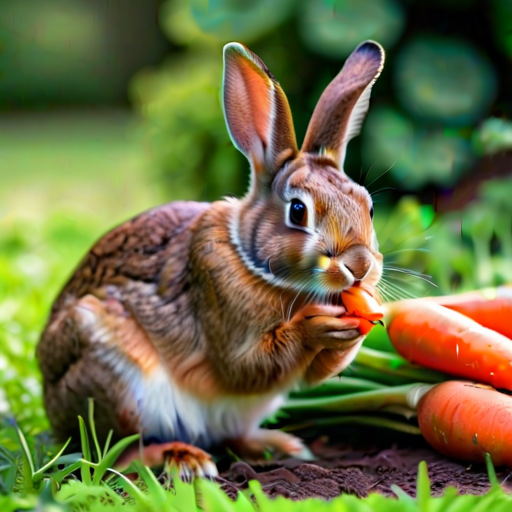


Rank[2]
Category: rabbit
Prompt: a rabbit sitting on a wooden table, surrounded by fresh vegetables, soft natural lighting, highly detailed.
Cosine Similarity Score: 0.305


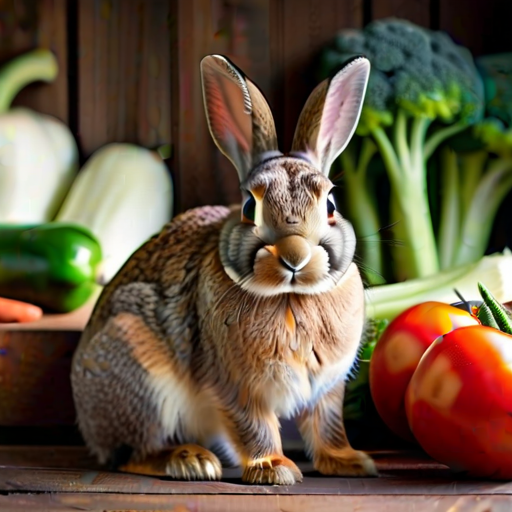

'====================================================='

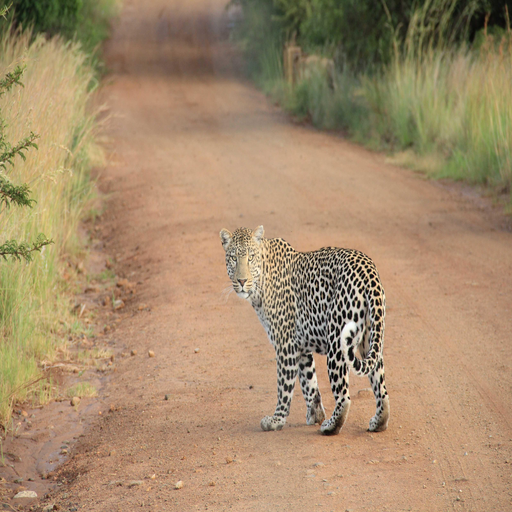

Rank[1]
Category: lion
Prompt: a lioness stalking prey in the savanna, intense focus in her eyes, soft natural lighting, highly detailed, 8k resolution.
Cosine Similarity Score: 0.840


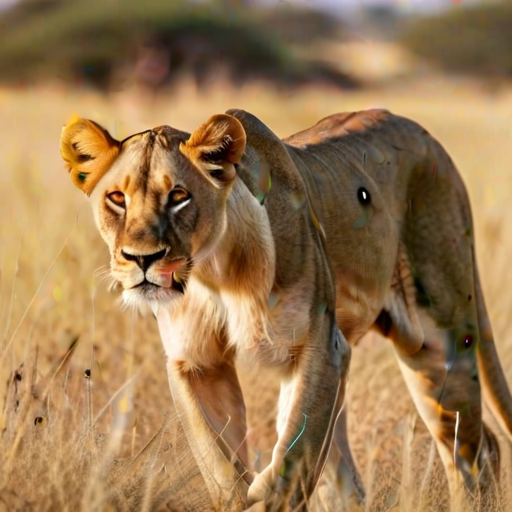


Rank[2]
Category: lion
Prompt: a lioness standing guard over her cubs, soft natural lighting, highly detailed, ultra-realistic, 8k resolution.
Cosine Similarity Score: 0.817


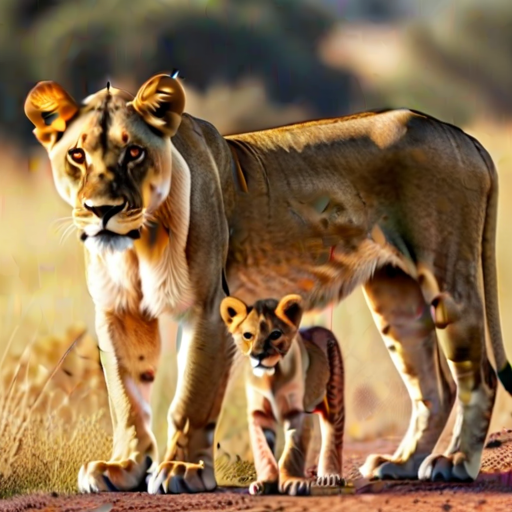

In [39]:
#######################################
# EXEMPLE D'UTILISATION
#######################################

# Configuration de l'embedding model
MODEL = "ViT-B-16-quickgelu"
CHECKPOINT = "openai"
multimodal_embedding = OpenCLIPEmbeddings(
    model_name=MODEL,
    checkpoint=CHECKPOINT
)

# Charger le dataset
dataset = load_dataset("Pupba/animal-180", split="train")
dataset = dataset.shuffle()

# Sélectionner 50 images (et leurs métadonnées associées)
images = dataset["png"][:50]  # PIL Images
metas = dataset["json"][:50]

# Récupérer prompt et catégorie pour chaque image
prompts = [data["prompt"] for data in metas]
categories = [data["category"] for data in metas]

# Connexion à Chroma en mémoire
collection, unique_ids = connect_to_chroma(
    mode="in-memory",
    collection_name="animaux-180",
    distance_metric="cosine"
)

# Prétraitement des images : création de "documents" adaptés à Chroma
image_documents = preprocess_image_documents(
    images=images,
    prompts=prompts,
    categories=categories
)

# Ajout des document dans le store
ids, unique_ids = add_images(
    collection=collection,
    unique_ids=unique_ids,
    image_documents=image_documents,
    embeddings=multimodal_embedding
)

In [ ]:
# Recherche via requête texte
text_query = "a rabbit eating a carrot"
display("=====================================================")
display(text_query)
results = searching_text_query(
    collection=collection,
    text_query=text_query,
    embeddings=multimodal_embedding,
    k=2
)
show_docs(results)

# Recherche via requête image
# img_url = "https://i.pinimg.com/736x/b2/e9/f4/b2e9f449c1c5f8a29e31cafb8671c8b2.jpg"
img_url = 'https://fastly.picsum.photos/id/219/5000/3333.jpg?hmac=nQIYAD6CmzCXEG3xtEckzbu3iauIE3DpHiqnQy3gdG4'
image_query = load_image_from_url(img_url)
display("=====================================================")
display(image_query)

results = search_image_query(
    collection=collection,
    query_image=image_query,
    embeddings=multimodal_embedding,
    k=2,
    # filters={"category": "rabbit"}
)
show_docs(results)

# Les techniques avancées de RAG

Dan ce chapitre, des implementation de techniques avancées vous sont expliquées et partiellement implementées avec ChatGPT comme base.  

En raison de la complexité de ces rêquetes, il est conseillé d'utiliser des LLM hébérgés puisque l'intelligence limitée des modèles locaux risquerait de nuire à vos résultats mais vous êtes **bien sûr** encouragés à tester par vous-même et constater les résultats.



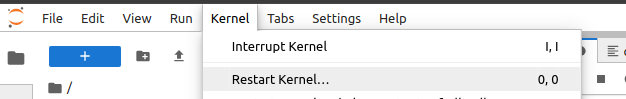

**Restart le kernel ici** pour permettre avoir un environnment propre de toute exécution précédente.

In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from the custom file
load_dotenv("config.env")

## Exercise 1


En partant du RAG 2, emplacez le multiquery par l'approche STEP BACK.

L’approche **Step-Back Prompting** est une technique avancée d’ingénierie de prompts visant à **améliorer les capacités de raisonnement des modèles de langage (LLMs)**. Elle encourage le modèle à **prendre du recul**, à **généraliser** une question avant de chercher une réponse détaillée, ce qui **renforce la cohérence et la pertinence des réponses**.  

---

### 🏗 **Comment fonctionne Step-Back Prompting ?**  

L’approche repose sur **deux étapes clés** :  

1️⃣ **Reformulation en question plus générique**  
   - Avant de répondre directement à une question spécifique, le modèle reformule cette dernière sous une forme plus générale.  
   - Cela lui permet d’identifier les **principes fondamentaux** et d’éviter des biais liés à des détails superflus.  

2️⃣ **Utilisation de la reformulation pour guider la réponse finale**  
   - Le modèle répond ensuite en tenant compte de cette **abstraction**, ce qui améliore la clarté et la précision du raisonnement.  

---

### 🔍 **Exemples concrets**  

#### 🎯 **Exemple 1 : Compréhension en histoire**  
📌 **Question originale** :  
🧐 *"Quel a été l'impact économique du blocus de Napoléon sur l’Europe ?"*  

📌 **Reformulation Step-Back** :  
🔄 *"Quels ont été les principaux effets économiques des blocus militaires dans l’histoire ?"*  

📌 **Réponse finale basée sur Step-Back** :  
✅ **En expliquant d’abord comment les blocus économiques influencent généralement les nations**, le modèle est mieux préparé pour analyser le cas spécifique du blocus napoléonien.  

---

#### 🎯 **Exemple 2 : Sciences et physique**  
📌 **Question originale** :  
🧐 *"Que se passe-t-il lorsque l'on double la température d’un gaz parfait tout en diminuant son volume de moitié ?"*  

📌 **Reformulation Step-Back** :  
🔄 *"Quels sont les paramètres influençant la pression d’un gaz parfait ?"*  

📌 **Réponse finale basée sur Step-Back** :  
✅ **Le modèle identifie d’abord la loi des gaz parfaits (PV = nRT), puis applique cette connaissance au cas spécifique.**  

---

### 📖 **Pourquoi utiliser Step-Back Prompting ?**  

✅ **Amélioration du raisonnement** : Le modèle adopte une approche analytique avant de répondre, réduisant ainsi les erreurs de logique.  
✅ **Généralisation efficace** : Il est capable de traiter des variantes similaires d’un même problème en identifiant les principes sous-jacents.  
✅ **Moins de biais et d’hallucinations** : En évitant de se concentrer trop tôt sur des détails, le modèle limite la propagation d’erreurs.  

---

### 🏗 **Mise en œuvre avec LangChain**  

L’implémentation peut être réalisée avec un prompt structuré incluant **des exemples Few-Shot** pour guider le modèle.  

```python
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

# Exemples d’application de Step-Back
examples = [
    {
        "input": "Quel est l'impact de la révolution industrielle sur la population urbaine ?",
        "output": "Quels sont les effets généraux des révolutions technologiques sur la démographie urbaine ?",
    },
    {
        "input": "Comment fonctionne un moteur à combustion interne ?",
        "output": "Quels sont les principes généraux des moteurs thermiques ?",
    },
]

# Création du modèle de prompt avec exemples
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Tu es un expert en connaissances générales. Ta tâche est de reformuler une question en une version plus générique et plus simple à traiter. Voici quelques exemples :""",
        ),
        few_shot_prompt,
        ("user", "{question}"),
    ]
)

# Génération des reformulations Step-Back
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "Quels sont les effets économiques des cryptomonnaies sur les banques traditionnelles ?"
generate_queries_step_back.invoke({"question": question})
```

---

### 🎯 **Challenge pour les apprenants !**  

💡 **Mettez en œuvre Step-Back Prompting dans vos propres modèles !**  

🔹 **Exercice 1** : Trouvez une question complexe et appliquez la technique Step-Back pour générer une reformulation plus générique.  
🔹 **Exercice 2** : Implémentez un pipeline qui utilise cette reformulation pour améliorer la recherche d’informations dans un système RAG.  
🔹 **Exercice 3** : Comparez les réponses d’un modèle avec et sans Step-Back pour voir l’impact sur la qualité des résultats.  

🚀 **En intégrant Step-Back Prompting, vous renforcerez la robustesse et la pertinence des réponses de vos LLMs !**

## Exercise 2

Dans cet exercice, nous allons **utiliser un retriever basé sur Wikipedia** pour récupérer des informations réelles après avoir généré un **document hypothétique** avec l'approche **HyDE**.

---

### 🏗 **Pourquoi utiliser Wikipedia comme Retriever ?**  

✅ **Données riches et vérifiées** : Wikipedia est une source fiable pour des faits et concepts.  
✅ **Large couverture** : Idéal pour tester l’amélioration de la récupération d’information avec HyDE.  
✅ **Accès rapide** : Via l’API LangChain, nous pouvons interroger Wikipedia efficacement.

---

### 🛠 **Plan d'implémentation**
1️⃣ **Génération d’un document hypothétique** avec un modèle de langage (**HyDE**).  
2️⃣ **Utilisation de Wikipedia Retriever** pour chercher des documents correspondants à ce document.  
3️⃣ **Comparaison** des résultats obtenus avec et sans HyDE.  
4️⃣ **Génération de la réponse finale** en utilisant **RAG**.

---

### 🔍 **Code d’implémentation**

Si ce n'est pas encore fait, installez les modules associés :
```bash
pip install wikipedia
```

### 2️⃣ **Implémentation**
#### 📌 **Étape 1 : Génération du document hypothétique**
```python
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Définition du prompt HyDE
template = """Please write a scientific paper passage to answer the question:
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

# Chaîne de génération du document hypothétique
generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser()
)

# Exécution de la génération
question = "What is task decomposition for LLM agents?"
hypothetical_doc = generate_docs_for_retrieval.invoke({"question": question})
print("\nHypothetical Document:\n", hypothetical_doc)
```

#### 📌 **Étape 2 : Recherche d’informations sur Wikipedia avec le Retriever**
```python
from langchain.retrievers import WikipediaRetriever

# Initialisation du Wikipedia Retriever
retriever = WikipediaRetriever()

# Recherche sur Wikipedia avec le document généré par HyDE
retrieved_docs = retriever.invoke(hypothetical_doc)

# Affichage des résultats
print("\n🔍 Retrieved Documents from Wikipedia:")
for doc in retrieved_docs:
    print(f"- {doc.metadata['title']}\n{doc.page_content[:300]}...\n")
```

---

### 🎯 **Travail demandé**
1️⃣ **Exécutez le code en testant différentes questions**.  
2️⃣ **Comparez les résultats obtenus avec et sans HyDE** (exécutez le retriever Wikipedia directement avec la question d'origine et observez la différence).  
3️⃣ **Analysez la pertinence des réponses finales** générées avec le RAG.  
4️⃣ **Bonus 🚀** : Ajoutez **FAISS** ou **ChromaDB** pour comparer les performances entre Wikipedia et une base locale.  

📌 **Livrables attendus** :
- **Code Python fonctionnel**.
- **Comparaison des résultats avec et sans HyDE**.
- **Réflexion sur l’impact de Wikipedia comme Retriever**.

Bonne implémentation ! 🚀

## Exercise 3

Dans cet exercice, nous allons **utiliser le routage sémantique** pour **diriger dynamiquement les requêtes des utilisateurs vers des experts virtuels** spécialisés dans différents domaines. L'objectif est de **sélectionner automatiquement l'expert le plus pertinent** en fonction de la question posée, en utilisant **les embeddings et la similarité de cosinus**.

---

### 🏗 **Pourquoi utiliser le Semantic Routing ?**  

✅ **Amélioration de la précision** : En dirigeant les questions vers les experts les plus adaptés, le système fournit des réponses plus pertinentes.  
✅ **Gestion flexible des connaissances** : Permet de créer une architecture où chaque domaine est traité par un modèle spécifique.  
✅ **Évolutivité** : Facile à étendre avec de nouveaux experts sans altérer la structure existante.  

---

### 🛠 **Plan d'implémentation**
1️⃣ **Création des profils des experts** sous forme de prompts spécifiques.  
2️⃣ **Encodage des prompts et de la requête utilisateur** en vecteurs d’embeddings.  
3️⃣ **Calcul de la similarité entre la requête et les experts disponibles**.  
4️⃣ **Sélection automatique de l’expert le plus adapté**.  
5️⃣ **Génération de la réponse à l’aide du modèle sélectionné**.  

---

### 🔍 **Exemple concret: Routage sémantique entre trois experts virtuels**  

Nous allons créer **trois profils d'experts** spécialisés dans des domaines distincts :  
- **Un archéologue** (histoire et civilisations anciennes)  
- **Un médecin** (biologie et santé)  
- **Un ingénieur en IA** (intelligence artificielle et automatisation)  

📌 **Exemple de requête utilisateur** :  
*"Comment l’intelligence artificielle influence-t-elle la médecine moderne ?"*  

Le système devra reconnaître que cette question concerne à la fois **l’intelligence artificielle et la santé**, et l’assignera à **l’expert en IA ou au médecin**, selon le contexte dominant.

---

### 2️⃣ **Implémentation du routage sémantique**

#### 📌 **Étape 1 : Création des experts et de leurs prompts**  
```python
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Définition des experts sous forme de prompts
archaeologist_template = """Vous êtes un archéologue renommé spécialisé dans les civilisations anciennes. Vous répondez aux questions sur l'histoire, les sites archéologiques, et les découvertes historiques avec des explications précises et fascinantes.

Voici une question :
{query}"""

doctor_template = """Vous êtes un médecin expert en biologie et en santé. Vous donnez des explications détaillées sur les maladies, les traitements et le fonctionnement du corps humain. Vous basez vos réponses sur des faits scientifiques et des études médicales reconnues.

Voici une question :
{query}"""

ai_engineer_template = """Vous êtes un ingénieur en intelligence artificielle et en automatisation. Vous êtes spécialisé dans les réseaux de neurones, l'apprentissage automatique et les modèles de langage. Vous expliquez les concepts d’IA de manière claire et pédagogique.

Voici une question :
{query}"""

# Stockage des prompts
prompt_templates = [archaeologist_template, doctor_template, ai_engineer_template]

# Initialisation du modèle d'embeddings
embeddings = OpenAIEmbeddings()
prompt_embeddings = embeddings.embed_documents(prompt_templates)
```

---

#### 📌 **Étape 2 : Fonction de routage des experts**  
```python
def expert_router(input):
    # Encoder la requête utilisateur
    query_embedding = embeddings.embed_query(input["query"])
    # Calculer la similarité
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    
    # Déterminer quel expert a été sélectionné
    if most_similar == archaeologist_template:
        print("📜 Expert sélectionné : Archéologue")
    elif most_similar == doctor_template:
        print("🩺 Expert sélectionné : Médecin")
    else:
        print("🤖 Expert sélectionné : Ingénieur en IA")

    return PromptTemplate.from_template(most_similar)
```

---

### 🎯 **Travail demandé**
2️⃣ **Testez le routage avec plusieurs questions variées** et vérifiez quel expert est sélectionné.  
3️⃣ **Ajoutez une phase d'affinage** où l’utilisateur peut **confirmer ou ajuster l’expert sélectionné** avant d’obtenir la réponse finale.  

📌 **Livrables attendus** :
- **Code Python fonctionnel**.
- **Comparaison des résultats avec différentes questions**.
- **Réflexion sur l’impact du routage sémantique pour améliorer l'interaction avec un chatbot ou un assistant IA**.  

🚀 **En maîtrisant le Semantic Routing, vous serez en mesure de concevoir des IA plus intelligentes et spécialisées !**

## Exercise 4

### 📌 **Pourquoi utiliser le Multi-Representation Indexing ?**  
✅ **Recherche plus efficace** : Indexe plusieurs représentations d'un même document pour améliorer la pertinence des résultats.  
✅ **Optimisation du coût des appels API** : En stockant des résumés, on réduit le volume de texte à traiter.  
✅ **Support des données semi-structurées** : Fonctionne avec du texte, des tableaux et d'autres formats.  
✅ **Meilleure gestion du contexte** : Permet de retrouver des informations précises même dans de grands corpus.  

---

### 🛠 **Plan d'implémentation**  
1️⃣ **Charger des documents** (articles, rapports, notes) dans LangChain.  
2️⃣ **Créer plusieurs représentations** : résumé, extraits clés, embeddings sémantiques.  
3️⃣ **Stocker les résumés et les documents originaux** dans un système multi-index.  
4️⃣ **Mettre en place un retriever** qui utilise ces différentes représentations pour améliorer la recherche.  
5️⃣ **Tester des requêtes** et comparer les résultats avec une approche classique.  

---

### 🔍 **Exemple concret : Recherche d’informations sur la réglementation IA**  
Nous disposons d’articles de presse et de rapports gouvernementaux sur la régulation de l’IA.  
Nous voulons retrouver rapidement **les passages pertinents sur l'impact des régulations sur les startups**.

**📌 Étapes de l'implémentation :**

#### **1️⃣ Charger et structurer les documents**
```python
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document

# Charger des documents sur la régulation de l’IA
loader1 = WebBaseLoader("https://digital-strategy.ec.europa.eu/en/policies/regulatory-framework-ai")
loader2 = WebBaseLoader("https://bidenwhitehouse.archives.gov/ostp/ai-bill-of-rights/")

docs = loader1.load() + loader2.load()
```

---

#### **2️⃣ Générer des résumés des documents**
```python
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Générer des résumés concis
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following legal document:\n\n{doc}")
    | ChatOpenAI(model="gpt-4o-mini", max_retries=0)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})
```

---

#### **3️⃣ Indexer les résumés et documents originaux**
```python
import uuid
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Initialisation du stockage multi-représentation
vectorstore = Chroma(collection_name="regulations",
                     embedding_function=OpenAIEmbeddings())

store = InMemoryByteStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(vectorstore=vectorstore, byte_store=store, id_key=id_key)

# Associer chaque résumé à son document parent
doc_ids = [str(uuid.uuid4()) for _ in docs]
summary_docs = [Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(summaries)]

# Ajouter les documents à l'index
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))
```

---

#### **4️⃣ Rechercher une information spécifique**
```python
query = "Impact des régulations IA sur les startups"

# Recherche vectorielle sur les résumés
sub_docs = vectorstore.similarity_search(query, k=1)
print(sub_docs[0].page_content)

# Recherche via le retriever multi-vector
retrieved_docs = retriever.get_relevant_documents(query, n_results=1)
print(retrieved_docs[0].page_content[:500])
```

---

### 🎯 **Travail demandé**  
1️⃣ **Tester avec des requêtes sur différents aspects de la régulation IA** (ex : protection des données, biais algorithmiques).  
2️⃣ **Ajouter un pré-traitement** pour extraire et indexer uniquement les sections juridiques pertinentes.  
3️⃣ **Comparer avec une recherche naïve** pour mesurer l’impact du multi-indexing sur la précision des résultats.  

🚀 **Le Multi-Representation Indexing améliore l'accès aux documents réglementaires en combinant résumés et stockage structuré !**

## Exercise 5

Dans cet exercice, nous allons mettre en œuvre une stratégie dite **Corrective-RAG** pour **Retrieval-Augmented Generation**, qui s’appuie sur :

1. L’extraction initiale de documents depuis un ensemble de sources.  
2. L’**auto-évaluation** de la pertinence de ces documents.  
3. La possibilité de **rechercher** d’autres informations sur le web, grâce à **DuckDuckGo**, si les documents sont jugés insuffisants ou non pertinents.

Notre objectif est de **générer une réponse fiable** à partir de différentes sources :  
- Des fichiers disponibles sur GitHub (plusieurs fichiers `.md`).  
- Une recherche dynamique via **DuckDuckGo** si nécessaire.

Les technologies employées sont :  
- **LangGraph**, qui permet d’orchestrer et de tracer un flux entre différentes étapes de traitement.  
- Un **retriever** (Chroma) pour indexer et récupérer les documents.  
- Un **grader** basé sur un modèle LLM pour filtrer les documents non pertinents.  

---

### **Pourquoi utiliser le Corrective-RAG ?**

✅ **Amélioration de la fiabilité** : En notant la pertinence de chaque document, on réduit le risque d’inclure des informations hors-sujet.  
✅ **Recherche web intégrée** : Le système peut déclencher une recherche en ligne via DuckDuckGo pour combler les lacunes lorsque la base de connaissances locale ne suffit pas.  
✅ **Réécriture de la question** : Optimise la requête pour obtenir des résultats plus précis, que ce soit en local ou via internet.  
✅ **Extensibilité** : La structure en nœuds (graph) facilite l’ajout de nouvelles étapes (filtrage plus poussé, agrégation, etc.).  

---

### **Plan d’implémentation**

1. **Indexation** : Charger et indexer les fichiers (`.md` depuis GitHub ici dans les exemples), puis créer un retriever (Chroma).  
2. **Grader** : Mettre en place un modèle de notation (LLM) qui évalue la pertinence de chaque document par rapport à la question.  
3. **Recherche additionnelle** : Si les documents locaux sont jugés non pertinents, réécrire la question pour lancer une recherche via DuckDuckGo.  
4. **Combiner les données** : Fusionner (ou remplacer) les documents jugés hors-sujet avec les résultats pertinents de DuckDuckGo.  
5. **Générer la réponse** : Construire la réponse finale à partir de l’ensemble de documents validés.  

---

### **Exemple Concret**

Imaginons qu’un utilisateur pose la question : **« Comment puis-je mettre en place un flux RAG efficace avec LangGraph ? »**  

1. Le système tente d’abord de récupérer des informations depuis les sources statiques (les fichiers `.md` hébergés sur GitHub).  
2. Le **grader** passe en revue chaque document pour vérifier s’il aborde la notion de RAG et de LangGraph.  
3. Si la majorité des documents sont jugés « hors sujet » ou manquent d’informations, le système déclenche la **recherche DuckDuckGo** en réécrivant éventuellement la requête pour une meilleure précision.  
4. Les nouveaux résultats sont ajoutés au contexte, et le modèle génère enfin une réponse combinant ces différentes informations.  

---

### **Implémentation Technique**

#### **Création et Indexation des Documents**

Nous allons charger plusieurs fichiers `.md` depuis GitHub, puis les indexer dans Chroma.

```python
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# URLs des documents à indexer
source_urls = [
    "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
    "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
    "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
    "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langraph.md",
    "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md"
]

docs = []
for url in source_urls:
    docs.extend(WebBaseLoader(url).load())

# Découper les documents pour un meilleur index
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,
    chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs)

# Création du vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
    collection_name="crag-chroma"
)
retriever = vectorstore.as_retriever()
```

---

#### **Grader pour Évaluer la Pertinence**

Nous allons utiliser un modèle LLM (ChatGPT) qui renvoie un score binaire (“yes”/“no”) indiquant si un document est pertinent par rapport à la question.

```python
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

class GradeDocuments(BaseModel):
    """Score binaire : 'yes' si pertinent, 'no' sinon."""
    binary_score: str = Field(description="Répondre 'yes' ou 'no' selon la pertinence.")

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments, method="function_calling")

system_grader_text = """Tu dois évaluer si le document répond à la question de l'utilisateur.
Dis 'yes' si c'est pertinent, 'no' sinon."""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system_grader_text),
    ("human", "Document:\n\n{document}\n\nQuestion:\n{question}")
])

retrieval_grader = grade_prompt | structured_llm_grader
```

---

#### **Chaîne de Génération et Réécriture de la Question**

Pour générer la réponse finale, nous allons créer un **prompt** RAG, puis un **réécrivain** de requête si les documents initiaux semblent insuffisants.

```python
from langchain import hub
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class RAGResponse(BaseModel):
    """Structured output for the RAG system response."""
    answer: str = Field(..., description="The generated answer based on retrieved documents.")

class RewrittenQuery(BaseModel):
    """Structured output for the rewritten question optimized for search engines."""
    optimized_query: str = Field(..., description="The improved question reformulated for better web search results.")

# Define RAG generation pipeline with structured output
rag_prompt = hub.pull("rlm/rag-prompt")  # Prompt from: https://smith.langchain.com/hub/rlm/rag-prompt
llm_rag = ChatOpenAI(model_name="gpt-4o", temperature=0.03)

# Chain with structured response
rag_chain = rag_prompt | llm_rag.with_structured_output(RAGResponse, method="function_calling")

# Define query rewriting with structured output
rewrite_system = """Tu vas réécrire la question pour la rendre plus claire et ciblée à destination d'un moteur de recherche web. Ne change pas le sens, seulement la formulation et les mots-clés si nécessaire."""

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", rewrite_system),
    ("human", "Question initiale:\n\n{question}\n\nFormule la question optimisée.")
])

llm_rewrite = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Chain with structured output for query rewriting
question_rewriter = re_write_prompt | llm_rewrite.with_structured_output(RewrittenQuery, method="function_calling")
```

---

#### **Recherche Web avec DuckDuckGo**

Nous créons un outil pour rechercher des informations supplémentaires. Vous pouvez utiliser un wrapper qui appelle directement DuckDuckGo et renvoie quelques résultats.

```python
# Hypothétique outil d'intégration DuckDuckGo
from langchain_community.tools.duckduckgo_search import DuckDuckGoSearchResults
from langchain.schema import Document

# Voir: https://python.langchain.com/api_reference/community/tools/langchain_community.tools.ddg_search.tool.DuckDuckGoSearchResults.html
web_search_tool = DuckDuckGoSearchResults(k=3)  # On récupère 3 résultats max

def duckduckgo_search(query: str):
    results = web_search_tool.invoke({"query": query})
    # Fusionner les contenus dans un Document unique ou sous forme de liste
    combined_text = "\n".join([r["content"] for r in results])
    return Document(page_content=combined_text)
```

---

#### **Création du Flux Corrective-RAG avec LangGraph**

Nous allons définir un “GraphState” et différentes fonctions pour former le pipeline CRAG.  

```python
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]

def retrieve(state):
    question = state["question"]
    docs = retriever.get_relevant_documents(question)
    return {"documents": docs, "question": question}

def grade_documents(state):
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search_needed = "No"

    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        if score.binary_score == "yes":
            filtered_docs.append(d)
        else:
            web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search": web_search_needed}

def transform_query(state):
    better_question = question_rewriter.invoke({"question": state["question"]})
    return {"documents": state["documents"], "question": better_question}

def run_duckduckgo_search(state):
    query = state["question"]
    doc_ddg = duckduckgo_search(query)
    new_docs = state["documents"] + [doc_ddg]
    return {"documents": new_docs, "question": query}

def generate_answer(state):
    question = state["question"]
    documents = state["documents"]
    result = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": result}

def decide_step(state):
    # Si la note a révélé des documents non pertinents, on fait une recherche web
    if state["web_search"] == "Yes":
        return "transform_query"
    else:
        return "generate_answer"
```

---

### **Travail Demandé**

1. **Adapter la recherche** :  
   - **Augmentez le paramètre** `k` de `DuckDuckGoSearchResults` à 5 et observez l’impact sur la qualité des réponses.  
   - **Critère de réussite** : Les réponses sont mieux renseignées ? Ou trop longues ?

2. **Personnaliser la phase de grading** :  
   - Introduisez un **score de similarité** (par exemple, en calculant la similarité cosinus entre la question et le document) avant même l’appel au LLM.  
   - **Critère de réussite** : Filtrer davantage de documents inutiles.  

3. **Tester plusieurs questions** :  
   - Par exemple, “Quelles sont les principales familles de langages pour la génération de texte ?”.  
   - **Critère de réussite** : Analyser l’activation du module DuckDuckGo si les documents locaux ne répondent pas.  

---

### **Livrables Attendus**

- **Code Python** intégral avec vos modifications (notamment la recherche DuckDuckGo et la personnalisation du grader).  
- **Rapport** décrivant :  
  - Les questions posées et les réponses obtenues.  
  - Comment le flux CRAG s’est déroulé (pertinence des documents, déclenchement de la recherche web, etc.).  
  - Les pistes d’amélioration identifiées (filtrage, scoring, etc.).  

Avec cette approche **Corrective-RAG**, vous optimisez la génération de réponses en recourant à un **mélange de sources locales et web**. La flexibilité de **LangGraph** vous permet de personnaliser finement le flux : vous pouvez aisément introduire de nouvelles étapes (filtrage supplémentaire, validation par un autre modèle, etc.).  

En maîtrisant ce type de pipeline, vous serez en mesure de concevoir des systèmes plus robustes et plus réactifs, capables de fournir des réponses de qualité supérieure, même lorsque la base de connaissances initiale est limitée.  
**En avant pour des solutions RAG innovantes et fiables !**

# END